# BioE C242 - Final Project - Adrien Bourgain - HIV Dataset

In [1]:
import numpy as np 
import pandas as pd 
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
from rdkit import Chem, rdBase
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem, PandasTools, Descriptors
from rdkit.Chem.Draw import IPythonConsole

print(f"rdBase.rdkitVersion: {rdBase.rdkitVersion}")

rdBase.rdkitVersion: 2023.09.4


## 1. Loading the data

In [3]:
HIV_PATH = "./Datasets/HIV/HIV.csv"

In [4]:
hiv_df = pd.read_csv(HIV_PATH)
hiv_df.head()

smiles activity  HIV_active
0  CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...       CI           0
1  C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...       CI           0
2                   CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21       CI           0
3    Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1       CI           0
4                             O=S(=O)(O)CCS(=O)(=O)O       CI           0

In [5]:
print(f"number of molecules: {hiv_df.shape[0]}, number of columns: {hiv_df.shape[1]}")
print(f"column names: {list(hiv_df.columns)}")

number of molecules: 41127, number of columns: 3
column names: ['smiles', 'activity', 'HIV_active']


In [6]:
hiv_active_molecules = hiv_df[hiv_df["HIV_active"] == 1]
hiv_inactive_molecules = hiv_df[hiv_df["HIV_active"] == 0]
cm_molecules = hiv_df[hiv_df["activity"] == "CM"]
ca_molecules = hiv_df[hiv_df["activity"] == "CA"]
ci_molecules = hiv_df[hiv_df["activity"] == "CI"]

print("Molecules in the dataset:")

print(f"    - total: {hiv_df.shape[0]}")
print("* HIV active:")
print(f"    - HIV active: {hiv_active_molecules.shape[0]} ({hiv_active_molecules.shape[0] / hiv_df.shape[0] * 100:.1f}%)")
print(f"    - HIV inactive: {hiv_inactive_molecules.shape[0]} ({hiv_inactive_molecules.shape[0] / hiv_df.shape[0] * 100:.1f}%)")

print("* Activity:")
print(f"    - CM: {cm_molecules.shape[0]} ({cm_molecules.shape[0] / hiv_df.shape[0] * 100:.1f}%)")
print(f"    - CA: {ca_molecules.shape[0]} ({ca_molecules.shape[0] / hiv_df.shape[0] * 100:.1f}%)")
print(f"    - CI: {ci_molecules.shape[0]} ({ci_molecules.shape[0] / hiv_df.shape[0] * 100:.1f}%)")


Molecules in the dataset:
    - total: 41127
* HIV active:
    - HIV active: 1443 (3.5%)
    - HIV inactive: 39684 (96.5%)
* Activity:
    - CM: 1039 (2.5%)
    - CA: 404 (1.0%)
    - CI: 39684 (96.5%)


**NB: Only 3.5% of the molecules are active; the dataset is very imbalanced and we should take it into account in the future.**

We can verify that CI (inactive) molecules are represented by 0 in the binary classification (HIV_active) and that CM and CA are represented by 1:

In [7]:
# Number of CI molecules
print(f"Number of CI molecules: {hiv_df[hiv_df['activity'] == 'CI'].shape[0]}")
# Number of CI molecules with HIV_active = 1
print(f"-> Number of CI molecules with HIV_active = 1: {hiv_df[(hiv_df['activity'] == 'CI') & (hiv_df['HIV_active'] == 1)].shape[0]}")
# Number of CI molecules with HIV_active = 0
print(f"-> Number of CI molecules with HIV_active = 0: {hiv_df[(hiv_df['activity'] == 'CI') & (hiv_df['HIV_active'] == 0)].shape[0]}")

# Number of non-CI molecules
print(f"Number of non-CI molecules: {hiv_df[hiv_df['activity'] != 'CI'].shape[0]}")
# Number of non-CI molecules with HIV_active = 1
print(f"-> Number of non-CI molecules with HIV_active = 1: {hiv_df[(hiv_df['activity'] != 'CI') & (hiv_df['HIV_active'] == 1)].shape[0]}")
# Number of non-CI molecules with HIV_active = 0
print(f"-> Number of non-CI molecules with HIV_active = 0: {hiv_df[(hiv_df['activity'] != 'CI') & (hiv_df['HIV_active'] == 0)].shape[0]}")

Number of CI molecules: 39684
-> Number of CI molecules with HIV_active = 1: 0
-> Number of CI molecules with HIV_active = 0: 39684
Number of non-CI molecules: 1443
-> Number of non-CI molecules with HIV_active = 1: 1443
-> Number of non-CI molecules with HIV_active = 0: 0


## 2. Visualization of the molecules

In [8]:
PandasTools.AddMoleculeColumnToFrame(hiv_df,'smiles')
print(f"hiv_df.shape: {hiv_df.shape}")
hiv_df.head()

[21:57:28] WARNING: not removing hydrogen atom without neighbors
[21:57:28] WARNING: not removing hydrogen atom without neighbors


hiv_df.shape: (41127, 4)


smiles activity  HIV_active  \
0  CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...       CI           0   
1  C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...       CI           0   
2                   CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21       CI           0   
3    Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1       CI           0   
4                             O=S(=O)(O)CCS(=O)(=O)O       CI           0   

                                           ROMol  
0  <rdkit.Chem.rdchem.Mol object at 0x1445cf900>  
1  <rdkit.Chem.rdchem.Mol object at 0x1445cff20>  
2  <rdkit.Chem.rdchem.Mol object at 0x1445cfa50>  
3  <rdkit.Chem.rdchem.Mol object at 0x1445cff90>  
4  <rdkit.Chem.rdchem.Mol object at 0x144607040>

In [9]:
hiv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41127 entries, 0 to 41126
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   smiles      41127 non-null  object
 1   activity    41127 non-null  object
 2   HIV_active  41127 non-null  int64 
 3   ROMol       41127 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.3+ MB


### Call descriptors through ROMol

In [10]:
for i,j in Descriptors.descList:
    hiv_df[i] = hiv_df['ROMol'].map(j)

[21:58:38] WARNING: not removing hydrogen atom without neighbors
[21:58:38] WARNING: not removing hydrogen atom without neighbors
[22:00:24] WARNING: not removing hydrogen atom without neighbors
[22:00:24] WARNING: not removing hydrogen atom without neighbors
[22:00:35] WARNING: not removing hydrogen atom without neighbors
[22:00:35] WARNING: not removing hydrogen atom without neighbors
[22:00:38] WARNING: not removing hydrogen atom without neighbors
[22:00:38] WARNING: not removing hydrogen atom without neighbors
[22:00:40] WARNING: not removing hydrogen atom without neighbors
[22:00:40] WARNING: not removing hydrogen atom without neighbors
[22:00:43] WARNING: not removing hydrogen atom without neighbors
[22:00:43] WARNING: not removing hydrogen atom without neighbors
[22:00:46] WARNING: not removing hydrogen atom without neighbors
[22:00:46] WARNING: not removing hydrogen atom without neighbors
[22:00:49] WARNING: not removing hydrogen atom without neighbors
[22:00:49] WARNING: not r

In [11]:
print(f"hiv_df.shape: {hiv_df.shape}")
hiv_df.head()

hiv_df.shape: (41127, 214)


smiles activity  HIV_active  \
0  CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...       CI           0   
1  C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...       CI           0   
2                   CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21       CI           0   
3    Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1       CI           0   
4                             O=S(=O)(O)CCS(=O)(=O)O       CI           0   

                                           ROMol  MaxAbsEStateIndex  \
0  <rdkit.Chem.rdchem.Mol object at 0x1445cf900>           5.925903   
1  <rdkit.Chem.rdchem.Mol object at 0x1445cff20>           6.515117   
2  <rdkit.Chem.rdchem.Mol object at 0x1445cfa50>          12.177015   
3  <rdkit.Chem.rdchem.Mol object at 0x1445cff90>          11.401803   
4  <rdkit.Chem.rdchem.Mol object at 0x144607040>           9.857917   

   MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex       qed        SPS  \
0        5.925903           0.759994       -2.330012  0.434358  23.368421   
1        6.515117           0.475558       -2.879653  0.104103  17.435897   
2       12.177015           0.041001        0.041001  0.581359  12.904762   
3       11.401803           0.087790       -4.524487  0.357615  12.583333   
4        9.857917           0.980324       -4.296481  0.538723  13.400000   

   ...  fr_sulfide  fr_sulfonamd  fr_sulfone  fr_term_acetylene  fr_tetrazole  \
0  ...           0             0           0                  0             0   
1  ...           0             0           0                  0             0   
2  ...           0             0           0                  0             0   
3  ...           0             0           0                  0             0   
4  ...           0             0           0                  0             0   

   fr_thiazole  fr_thiocyan  fr_thiophene  fr_unbrch_alkane  fr_urea  
0            0            0             0                 0        0  
1            0            0             0                 0        0  
2            0            0             0                 0        0  
3            0            0             0                 0        0  
4            0            0             0                 0        0  

[5 rows x 214 columns]

In [12]:
hiv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41127 entries, 0 to 41126
Columns: 214 entries, smiles to fr_urea
dtypes: float64(106), int64(105), object(3)
memory usage: 67.1+ MB


In [13]:
hiv_df.to_csv("./Datasets/HIV/hiv_descriptors.csv", index=False)

### Structure of HIV molecular  

smiles activity  HIV_active  \
0      CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...       CI           0   
1      C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...       CI           0   
2                       CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21       CI           0   
3        Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1       CI           0   
4                                 O=S(=O)(O)CCS(=O)(=O)O       CI           0   
...                                                  ...      ...         ...   
41122  CCC1CCC2c3c([nH]c4ccc(C)cc34)C3C(=O)N(N(C)C)C(...       CI           0   
41123  Cc1ccc2[nH]c3c(c2c1)C1CCC(C(C)(C)C)CC1C1C(=O)N...       CI           0   
41124  Cc1ccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)C...       CI           0   
41125  Cc1cccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)...       CI           0   
41126  CCCCCC=C(c1cc(Cl)c(OC)c(-c2nc(C)no2)c1)c1cc(Cl...       CI           0   

                                               ROMol  MaxAbsEStateIndex  \
0      <rdkit.Chem.rdchem.Mol object at 0x1445cf900>           5.925903   
1      <rdkit.Chem.rdchem.Mol object at 0x1445cff20>           6.515117   
2      <rdkit.Chem.rdchem.Mol object at 0x1445cfa50>          12.177015   
3      <rdkit.Chem.rdchem.Mol object at 0x1445cff90>          11.401803   
4      <rdkit.Chem.rdchem.Mol object at 0x144607040>           9.857917   
...                                              ...                ...   
41122  <rdkit.Chem.rdchem.Mol object at 0x153cc0190>          13.370142   
41123  <rdkit.Chem.rdchem.Mol object at 0x153cc0200>          14.160262   
41124  <rdkit.Chem.rdchem.Mol object at 0x153cc0270>          13.962959   
41125  <rdkit.Chem.rdchem.Mol object at 0x153cc02e0>          13.989331   
41126  <rdkit.Chem.rdchem.Mol object at 0x153cc0350>           6.694141   

       MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex       qed        SPS  \
0            5.925903           0.759994       -2.330012  0.434358  23.368421   
1            6.515117           0.475558       -2.879653  0.104103  17.435897   
2           12.177015           0.041001        0.041001  0.581359  12.904762   
3           11.401803           0.087790       -4.524487  0.357615  12.583333   
4            9.857917           0.980324       -4.296481  0.538723  13.400000   
...               ...                ...             ...       ...        ...   
41122       13.370142           0.007185       -0.366239  0.804191  32.035714   
41123       14.160262           0.075082       -0.480928  0.427745  28.888889   
41124       13.962959           0.011372       -0.415582  0.450949  29.212121   
41125       13.989331           0.009754       -0.416314  0.450949  29.212121   
41126        6.694141           0.317797        0.317797  0.187492  11.000000   

       ...  fr_sulfide  fr_sulfonamd  fr_sulfone  fr_term_acetylene  \
0      ...           0             0           0                  0   
1      ...           0             0           0                  0   
2      ...           0             0           0                  0   
3      ...           0             0           0                  0   
4      ...           0             0           0                  0   
...    ...         ...           ...         ...                ...   
41122  ...           0             0           0                  0   
41123  ...           0             0           0                  0   
41124  ...           0             0           0                  0   
41125  ...           0             0           0                  0   
41126  ...           0             0           0                  0   

       fr_tetrazole  fr_thiazole  fr_thiocyan  fr_thiophene  fr_unbrch_alkane  \
0                 0            0            0             0                 0   
1                 0            0            0             0                 0   
2                 0            0            0             0                 0   
3                 0       
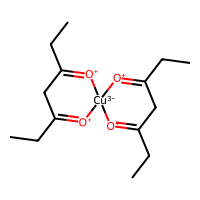
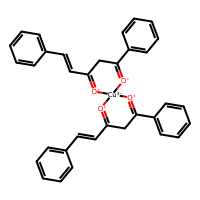
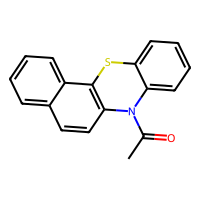
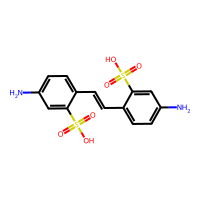
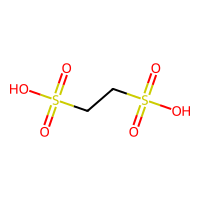
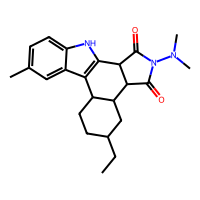
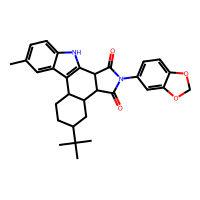
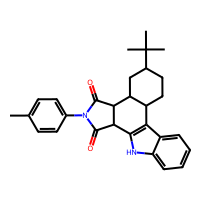
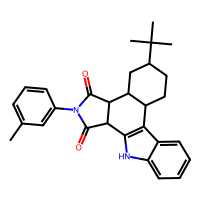
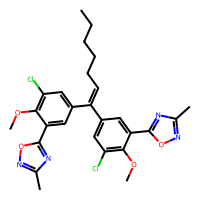

In [14]:
hiv_df

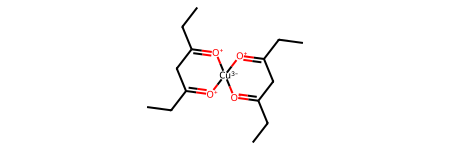

In [15]:
hiv_df_0 = Chem.MolFromSmiles(hiv_df.smiles[0])
hiv_df_0

#### Activity types

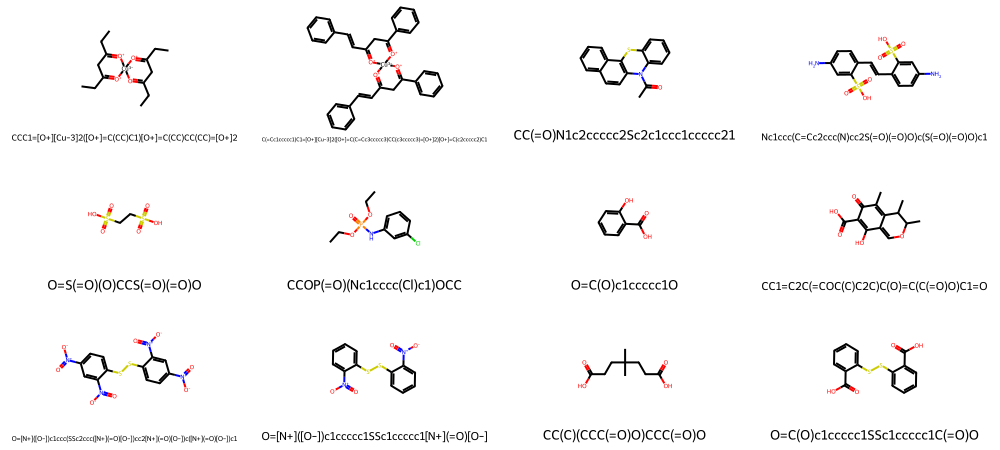

In [16]:
# CI activity 
CI_activity = hiv_df[hiv_df.activity=="CI"]
CI_activity_12 = PandasTools.FrameToGridImage(CI_activity[:12], 
                                                  column='ROMol', legendsCol='smiles', 
                                                  molsPerRow=4, subImgSize=(250,150))
CI_activity_12

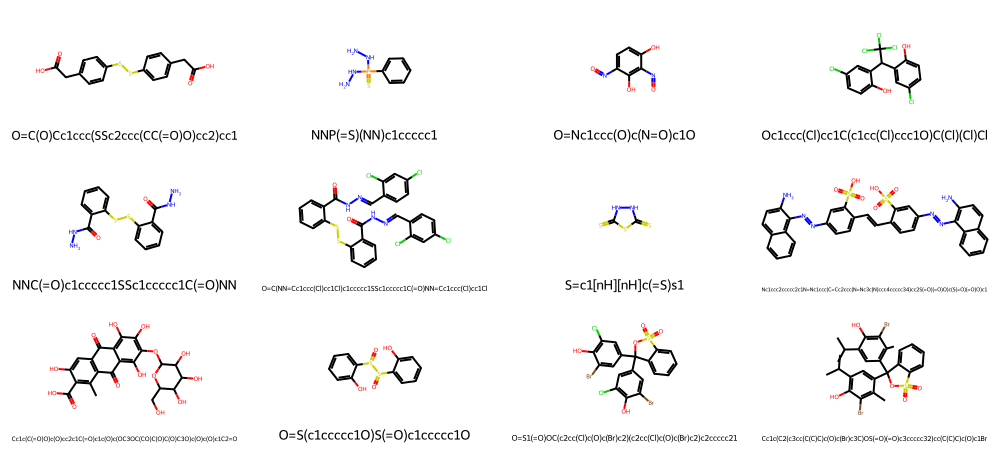

In [17]:
# CM activity 
CM_activity = hiv_df[hiv_df.activity=="CM"]
CM_activity_12 = PandasTools.FrameToGridImage(CM_activity[:12], 
                                                  column='ROMol', legendsCol='smiles', 
                                                  molsPerRow=4, subImgSize=(250,150))
CM_activity_12

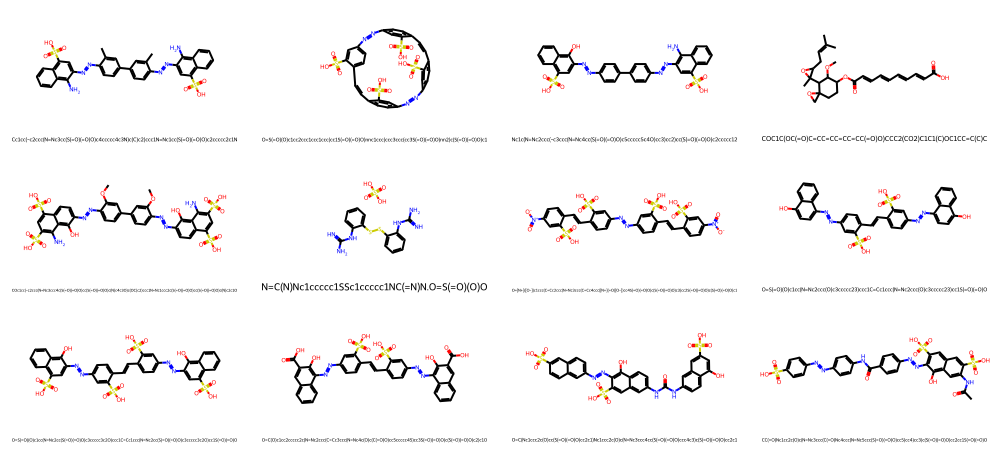

In [18]:
# CA activity 
CA_activity = hiv_df[hiv_df.activity=="CA"]
CA_activity_12 = PandasTools.FrameToGridImage(CA_activity[:12], 
                                                  column='ROMol', legendsCol='smiles', 
                                                  molsPerRow=4, subImgSize=(250,150))
CA_activity_12

#### HIV Activity Types

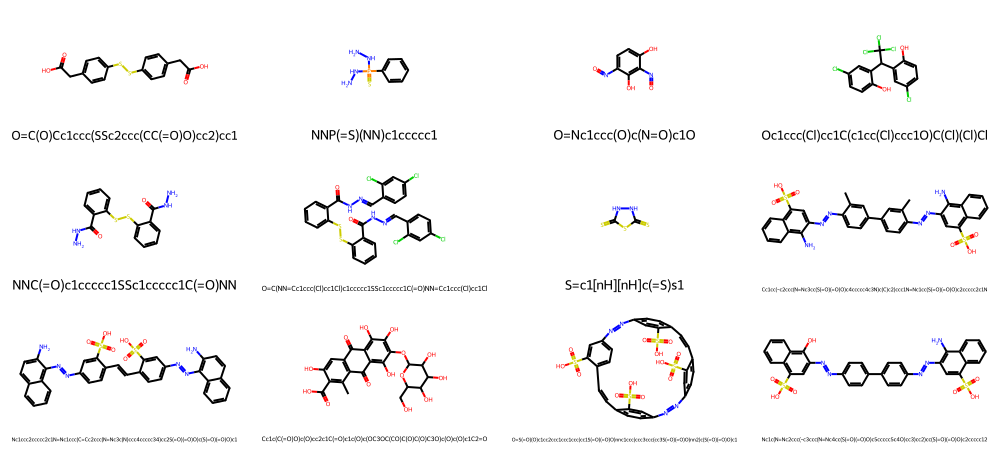

In [19]:
# HIV active
HIV_active = hiv_df[hiv_df.HIV_active==1]
HIV_active_12 = PandasTools.FrameToGridImage(HIV_active[:12], 
                                                  column='ROMol', legendsCol='smiles', 
                                                  molsPerRow=4, subImgSize=(250,150))
HIV_active_12

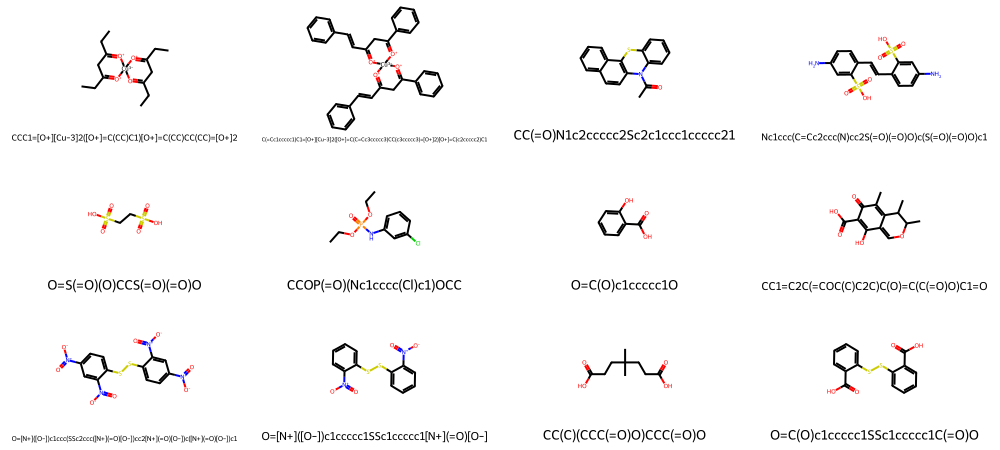

In [20]:
# HIV inactive
HIV_inactive = hiv_df[hiv_df.HIV_active==0]
HIV_inactive_12 = PandasTools.FrameToGridImage(HIV_inactive[:12], 
                                                  column='ROMol', legendsCol='smiles', 
                                                  molsPerRow=4, subImgSize=(250,150))
HIV_inactive_12

## 3. General Descriptors

### 3.1. Abnormal values (np.nan, np.inf, >1e15)

We can identify if there are any abnormal values in the dataset: 
+ duplicates (rows and columns),
+ nan values,
+ infinite values, 
+ too large values.

In [21]:
hiv_df = pd.read_csv("./Datasets/HIV/hiv_descriptors.csv")
hiv_df.head()

smiles activity  HIV_active  \
0  CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...       CI           0   
1  C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...       CI           0   
2                   CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21       CI           0   
3    Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1       CI           0   
4                             O=S(=O)(O)CCS(=O)(=O)O       CI           0   

                                           ROMol  MaxAbsEStateIndex  \
0  <rdkit.Chem.rdchem.Mol object at 0x1445cf900>           5.925903   
1  <rdkit.Chem.rdchem.Mol object at 0x1445cff20>           6.515117   
2  <rdkit.Chem.rdchem.Mol object at 0x1445cfa50>          12.177015   
3  <rdkit.Chem.rdchem.Mol object at 0x1445cff90>          11.401803   
4  <rdkit.Chem.rdchem.Mol object at 0x144607040>           9.857917   

   MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex       qed        SPS  \
0        5.925903           0.759994       -2.330012  0.434358  23.368421   
1        6.515117           0.475558       -2.879653  0.104103  17.435897   
2       12.177015           0.041001        0.041001  0.581359  12.904762   
3       11.401803           0.087790       -4.524487  0.357615  12.583333   
4        9.857917           0.980324       -4.296481  0.538723  13.400000   

   ...  fr_sulfide  fr_sulfonamd  fr_sulfone  fr_term_acetylene  fr_tetrazole  \
0  ...           0             0           0                  0             0   
1  ...           0             0           0                  0             0   
2  ...           0             0           0                  0             0   
3  ...           0             0           0                  0             0   
4  ...           0             0           0                  0             0   

   fr_thiazole  fr_thiocyan  fr_thiophene  fr_unbrch_alkane  fr_urea  
0            0            0             0                 0        0  
1            0            0             0                 0        0  
2            0            0             0                 0        0  
3            0            0             0                 0        0  
4            0            0             0                 0        0  

[5 rows x 214 columns]

In [22]:
# Number of duplicates
print(f"Number of duplicates: {hiv_df.duplicated().sum()}")

Number of duplicates: 0


In [23]:
# Number of nan values 
print(f"Number of NaN: {hiv_df.isna().sum().sum()}")

# Number of inf values
print(f"Number of inf values: {hiv_df.isin([np.inf, -np.inf]).sum().sum()}")

# Number of too large values (> 1e15)
print(f"Number of too large values: {hiv_df.drop(columns=['smiles', 'activity', 'HIV_active', 'ROMol']).apply(lambda x: x.abs() > 1e15).sum().sum()}")

Number of NaN: 19368
Number of inf values: 32
Number of too large values: 439


In [24]:
# Find the columns with NaN values
nan_columns = hiv_df.columns[hiv_df.isna().any()].tolist()
print(f"Columns with NaN values: {nan_columns}")

Columns with NaN values: ['MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW']


**NB: To handle missing values, we could take the mean for each concerned column for example. However, for the following, we will use models like decision trees or XGBoost, which can handle missing values on their own.** 

**Nonetheless, these models cannot handle inf or too large values. We have to replace these values with np.nan.**

In [25]:
# replace NaN values with the mean of the column
hiv_clean_df = hiv_df.replace([np.inf, -np.inf], np.nan)

# > 1e15 values are considered as too large and are replaced by nan for the columns that contain non str values
hiv_clean_df = hiv_clean_df.drop(columns=['smiles', 'activity', 'HIV_active', 'ROMol']).mask(hiv_clean_df.drop(columns=['smiles', 'activity', 'HIV_active', 'ROMol']).abs() > 1e15)

In [26]:
# Merge with the first columns and save the dataframe
hiv_df = pd.concat([hiv_df[['smiles', 'activity', 'HIV_active', 'ROMol']], hiv_clean_df], axis=1)
hiv_df.to_csv("./Datasets/HIV/hiv_descriptors_clean.csv", index=False)

### 3.2. Exploration of the descriptors

In [91]:
hiv_df = pd.read_csv("./Datasets/HIV/hiv_descriptors_clean.csv")

<Axes: xlabel='MolWt', ylabel='MolLogP'>

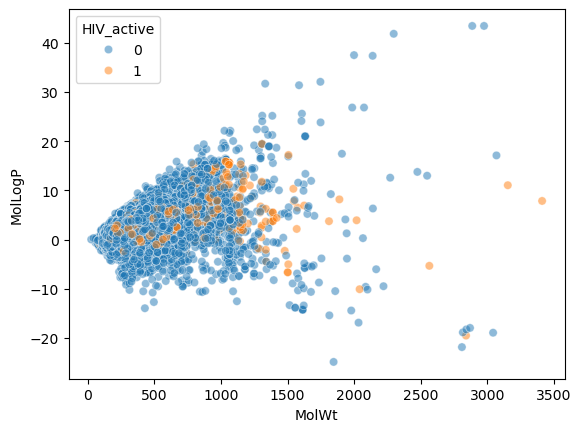

In [83]:
sns.scatterplot(data=hiv_df, x="MolWt", y="MolLogP", hue="HIV_active", alpha=0.5)

Constitutional descriptors that reflect the composition and connectivity of atoms within a molecule. Examples include the number of atoms, molecular weight, and the number of specific atom types. Some examples are:
  - MolWt, HeavyAtomMolWt, ExactMolWt: Molecular weight descriptors.
  - NumValenceElectrons, NumRadicalElectrons: Descriptors related to electron count inside the molecule.
  - HeavyAtomCount, NHOHCount, NOCount: Count of specific types of atoms or groups.
  - FractionCSP3: Fraction of sp3 hybridized carbons.
Topological descriptors capture the molecular shape and connectivity without regard to the 3D positions of atoms. Some examples are:
  - Chi**: Chi connectivity indices.
  - Kappa*: Shape descriptors.
  - HallKierAlpha: Describes molecular shape in terms of alpha values.
  - Ipc, AvgIpc: Information content indices.
  - BalabanJ: Balaban's J index is a topological descriptor.
  - RingCount, NumAliphaticRings, NumAromaticRings, NumSaturatedRings: Count of rings and their types.
Geometrical descriptors relate to the 3D structure of molecules (distances, angles, and other geometric features, such as the radius of gyration and the eccentric connectivity index). An example is:
  - LabuteASA: Labute's Approximate Surface Area.
Electronic descriptors describe electronic properties such as electronegativity or the energy of the highest occupied molecular orbital. Some examples are:
  - MaxAbsEStateIndex, MaxEStateIndex, MinAbsEStateIndex, MinEStateIndex: Electronegativity and electronic state indices.
  - MaxPartialCharge, MinPartialCharge, MaxAbsPartialCharge, MinAbsPartialCharge: Descriptors related to partial charges.
  - BCUT2D_***: BCUT descriptors capture both electronic and structural information.
Hydrophobicity and solubility descriptors quantify aspects of a molecule's interaction with water and lipids (such as the logP value, which estimates the partition coefficient between octanol and water). Some examples are:
  - MolLogP, SlogP_VSA***, SMR_VSA***, PEOE_VSA***: Partition coefficient and solvent accessible surface area descriptors.
  - qed: Quantitative Estimate of Drug-likeness.
Pharmacophore features include features important for drug design, such as hydrogen bond donors and acceptors, and the presence of specific pharmacophore groups. Some examples are:
  - NumHAcceptors, NumHDonors: Number of hydrogen bond acceptors and donors respectively.
  - TPSA: Topological Polar Surface Area.
Molecular fingerprints encode representations capturing the presence of particular substructures or patterns within molecules. Some examples are:
  - FpDensityMorgan*: Density of Morgan fingerprints at different radii.
Functional group counts are specific instances of chemical moieties. Descriptors starting with fr_ (e.g., fr_Al_COO, fr_amide, fr_ether) are counts of specific functional groups or structural features within the molecule.

In [106]:
# Descriptors to be used among: ROMol,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,AvgIpc,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA8,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,SlogP_VSA9,TPSA,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,FractionCSP3,HeavyAtomCount,NHOHCount,NOCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,RingCount,MolLogP,MolMR,fr_Al_COO,fr_Al_OH,fr_Al_OH_noTert,fr_ArN,fr_Ar_COO,fr_Ar_N,fr_Ar_NH,fr_Ar_OH,fr_COO,fr_COO2,fr_C_O,fr_C_O_noCOO,fr_C_S,fr_HOCCN,fr_Imine,fr_NH0,fr_NH1,fr_NH2,fr_N_O,fr_Ndealkylation1,fr_Ndealkylation2,fr_Nhpyrrole,fr_SH,fr_aldehyde,fr_alkyl_carbamate,fr_alkyl_halide,fr_allylic_oxid,fr_amide,fr_amidine,fr_aniline,fr_aryl_methyl,fr_azide,fr_azo,fr_barbitur,fr_benzene,fr_benzodiazepine,fr_bicyclic,fr_diazo,fr_dihydropyridine,fr_epoxide,fr_ester,fr_ether,fr_furan,fr_guanido,fr_halogen,fr_hdrzine,fr_hdrzone,fr_imidazole,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
descriptors = [col for col in hiv_df.columns if col not in ('Unnamed: 0', 'smiles', 'activity', 'HIV_active', 'ROMol')]

constitutional_descriptors = [
    "MolWt", "HeavyAtomMolWt", "ExactMolWt",
    "NumValenceElectrons", "NumRadicalElectrons",
    "HeavyAtomCount", "NHOHCount", "NOCount",
    "FractionCSP3"
]

topological_descriptors = [
    "HallKierAlpha", "Ipc", "BalabanJ",
    "RingCount", 
] + [col for col in descriptors if col.startswith("Num") and col not in ("NumValenceElectrons", "NumRadicalElectrons", "NumHAcceptors", "NumHDonors")]

chi_descriptors = [col for col in descriptors if col.startswith("Chi")]
kappa_descriptors = [col for col in descriptors if col.startswith("Kappa")]

geometrical_descriptors = [
    "LabuteASA"
]

electronic_descriptors = [
    "MaxAbsEStateIndex", "MaxEStateIndex", "MinAbsEStateIndex", "MinEStateIndex",
    "MaxPartialCharge", "MinPartialCharge", "MaxAbsPartialCharge", "MinAbsPartialCharge",
] 

bcut2d_descriptors = [col for col in descriptors if col.startswith("BCUT2D")]
estate_vsa_descriptors = [col for col in descriptors if col.startswith("EState_VSA")]
vsa_estate_descriptors = [col for col in descriptors if col.startswith("VSA_EState")]

hydrophobicity_solubility_descriptors = [
    "MolLogP", "qed"
]
slogp_vsa_descriptors = [col for col in descriptors if col.startswith("SlogP_VSA")]
smr_vsa_descriptors = [col for col in descriptors if col.startswith("SMR_VSA")]
peoe_vsa_descriptors = [col for col in descriptors if col.startswith("PEOE_VSA")]

pharmacophore_descriptors = [
    "NumHAcceptors", "NumHDonors", "TPSA"
]

molecular_descriptors = [col for col in descriptors if col.startswith("FpDensityMorgan")]

functional_group_counts = [
    column for column in hiv_df.columns if column.startswith("fr_")
]

other_descriptors = [
    'SPS', 'AvgIpc', 'BertzCT', 'MolMR'
]

desc_dict = {
    "constitutional": constitutional_descriptors,
    "topological": topological_descriptors,
    "chi": chi_descriptors,
    "kappa": kappa_descriptors,
    "electronic": electronic_descriptors,
    "bcut2d": bcut2d_descriptors,
    "estate_vsa": estate_vsa_descriptors,
    "vsa_estate": vsa_estate_descriptors,
    "hydrophobicity_solubility": hydrophobicity_solubility_descriptors,
    "slogp_vsa": slogp_vsa_descriptors,
    "smr_vsa": smr_vsa_descriptors,
    "peoe_vsa": peoe_vsa_descriptors,
    "pharmacophore": pharmacophore_descriptors,
    "molecular": molecular_descriptors,
    "functional_group_counts": functional_group_counts,
    "other": other_descriptors
}

# Verify that all descriptors from the dataset are included in the lists above
selected_descriptors = constitutional_descriptors + topological_descriptors + chi_descriptors + kappa_descriptors + geometrical_descriptors + electronic_descriptors + bcut2d_descriptors + estate_vsa_descriptors + vsa_estate_descriptors + hydrophobicity_solubility_descriptors + slogp_vsa_descriptors + smr_vsa_descriptors + peoe_vsa_descriptors + pharmacophore_descriptors + molecular_descriptors + functional_group_counts + other_descriptors
# Order the descriptors in the same order as in the dataset
selected_descriptors = [col for col in hiv_df.columns if col in selected_descriptors]

print(f"Number of selected descriptors: {len(selected_descriptors)}")
print(f"Number of columns in the dataset: {len(descriptors)}")
assert set(descriptors) == set(selected_descriptors), "Issue with the selected descriptors..."

Number of selected descriptors: 210
Number of columns in the dataset: 210


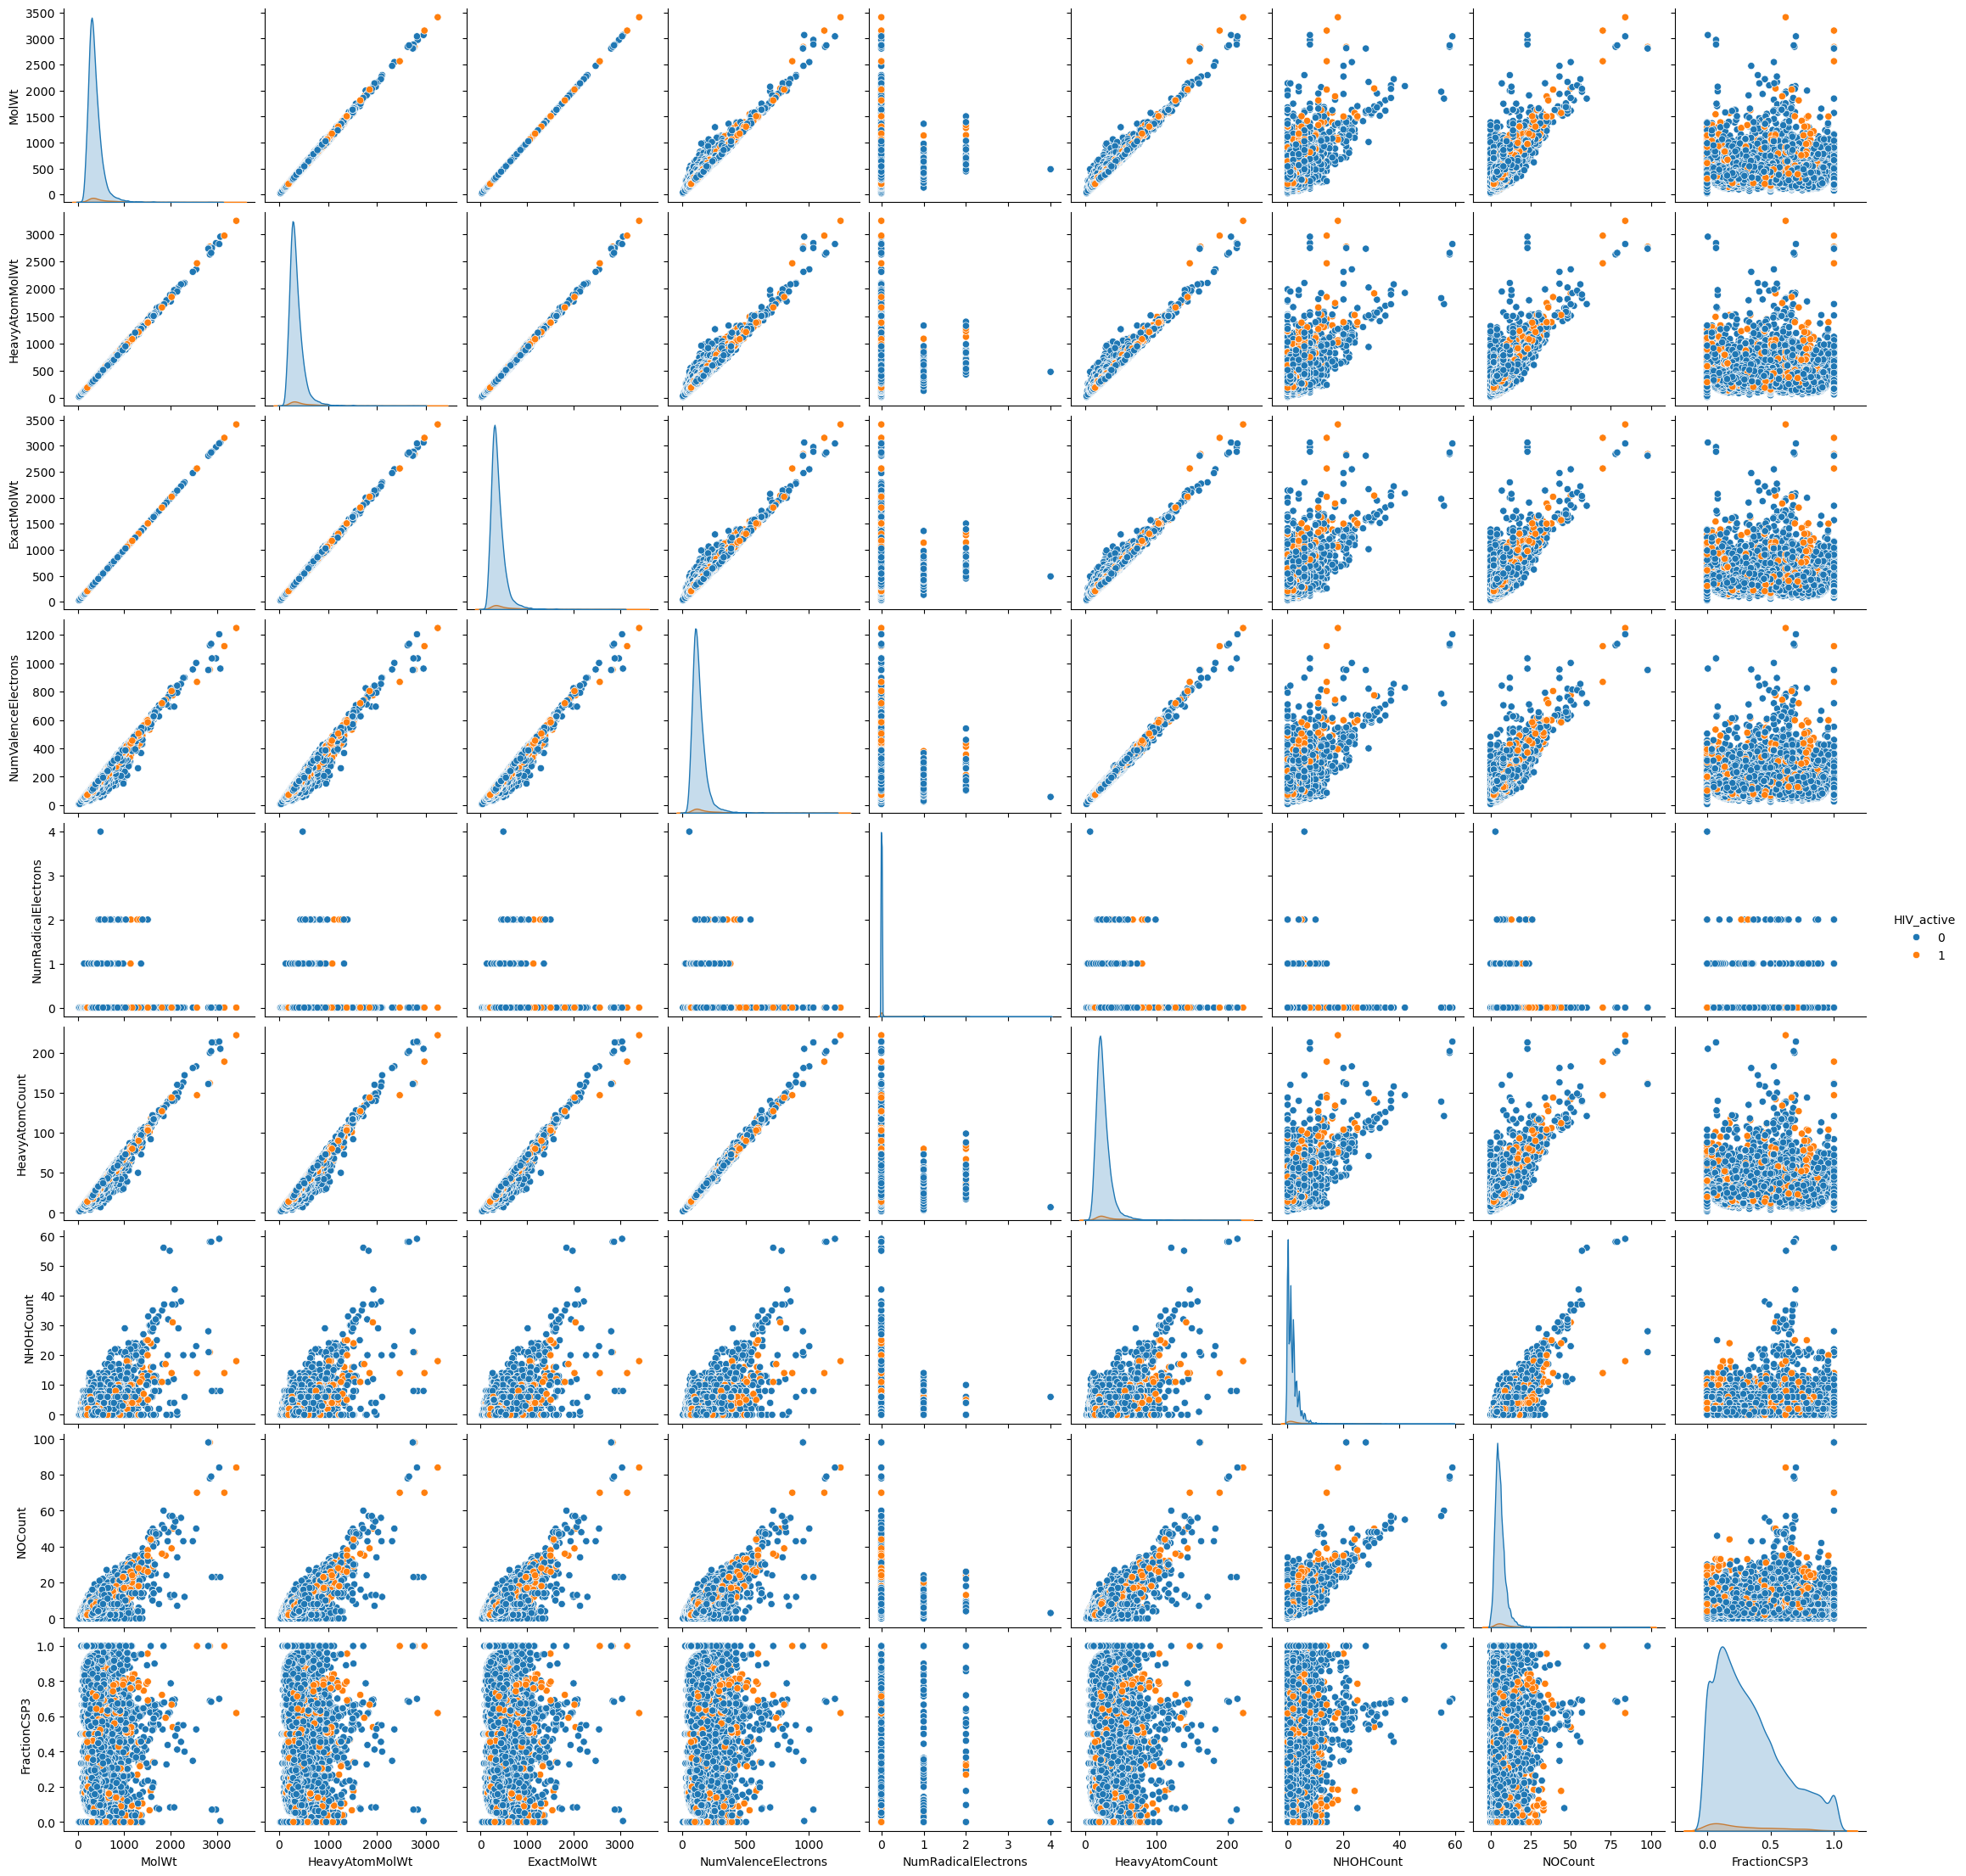

In [29]:
sns.pairplot(data=hiv_df[constitutional_descriptors + ['HIV_active']], hue='HIV_active', diag_kind='kde')

#### 3.2.1.1. PCA inside descriptor type

Number of rows before dropping NaN: 41127
Number of rows after dropping NaN: 39111


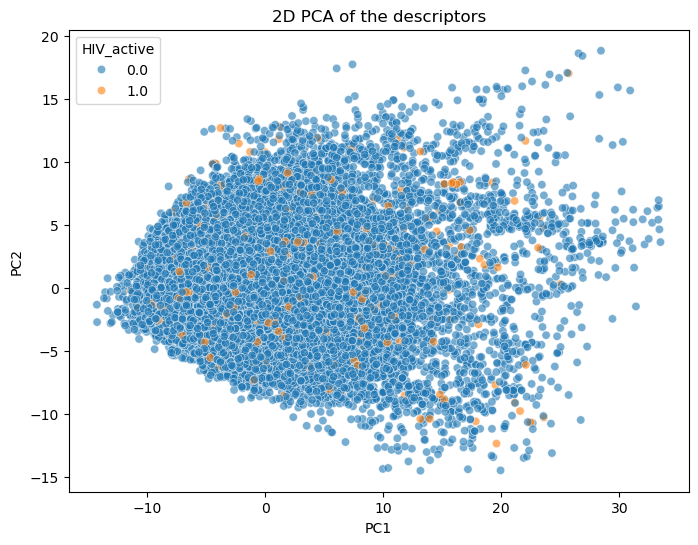

In [103]:
# Create a 2d PCA plot of the fingerprints
from sklearn.decomposition import PCA

# Drop the rows with NaN values
print(f"Number of rows before dropping NaN: {hiv_df.shape[0]}")
hiv_pca_df = hiv_df[selected_descriptors + ["HIV_active"]].dropna()

# Remove the columns with constant values
constant_values = hiv_pca_df.columns[hiv_pca_df.apply(pd.Series.nunique) == 1]
hiv_pca_df = hiv_pca_df.loc[:, hiv_pca_df.columns.difference(constant_values)]
selected_descriptors = [col for col in selected_descriptors if col not in constant_values]

# Normalize each column
hiv_pca_df[selected_descriptors] = (hiv_pca_df[selected_descriptors] - hiv_pca_df[selected_descriptors].mean()) / hiv_pca_df[selected_descriptors].std()
hiv_pca_df = hiv_pca_df[selected_descriptors + ["HIV_active"]].dropna()
print(f"Number of rows after dropping NaN: {hiv_pca_df.shape[0]}")

pca = PCA(n_components=2)
pca_result = pca.fit_transform(hiv_pca_df[selected_descriptors])
pca_df = pd.DataFrame(pca_result, columns=["PC1", "PC2"])
pca_df["HIV_active"] = hiv_pca_df["HIV_active"]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="HIV_active", alpha=0.6)
plt.title("2D PCA of the descriptors")
plt.show()

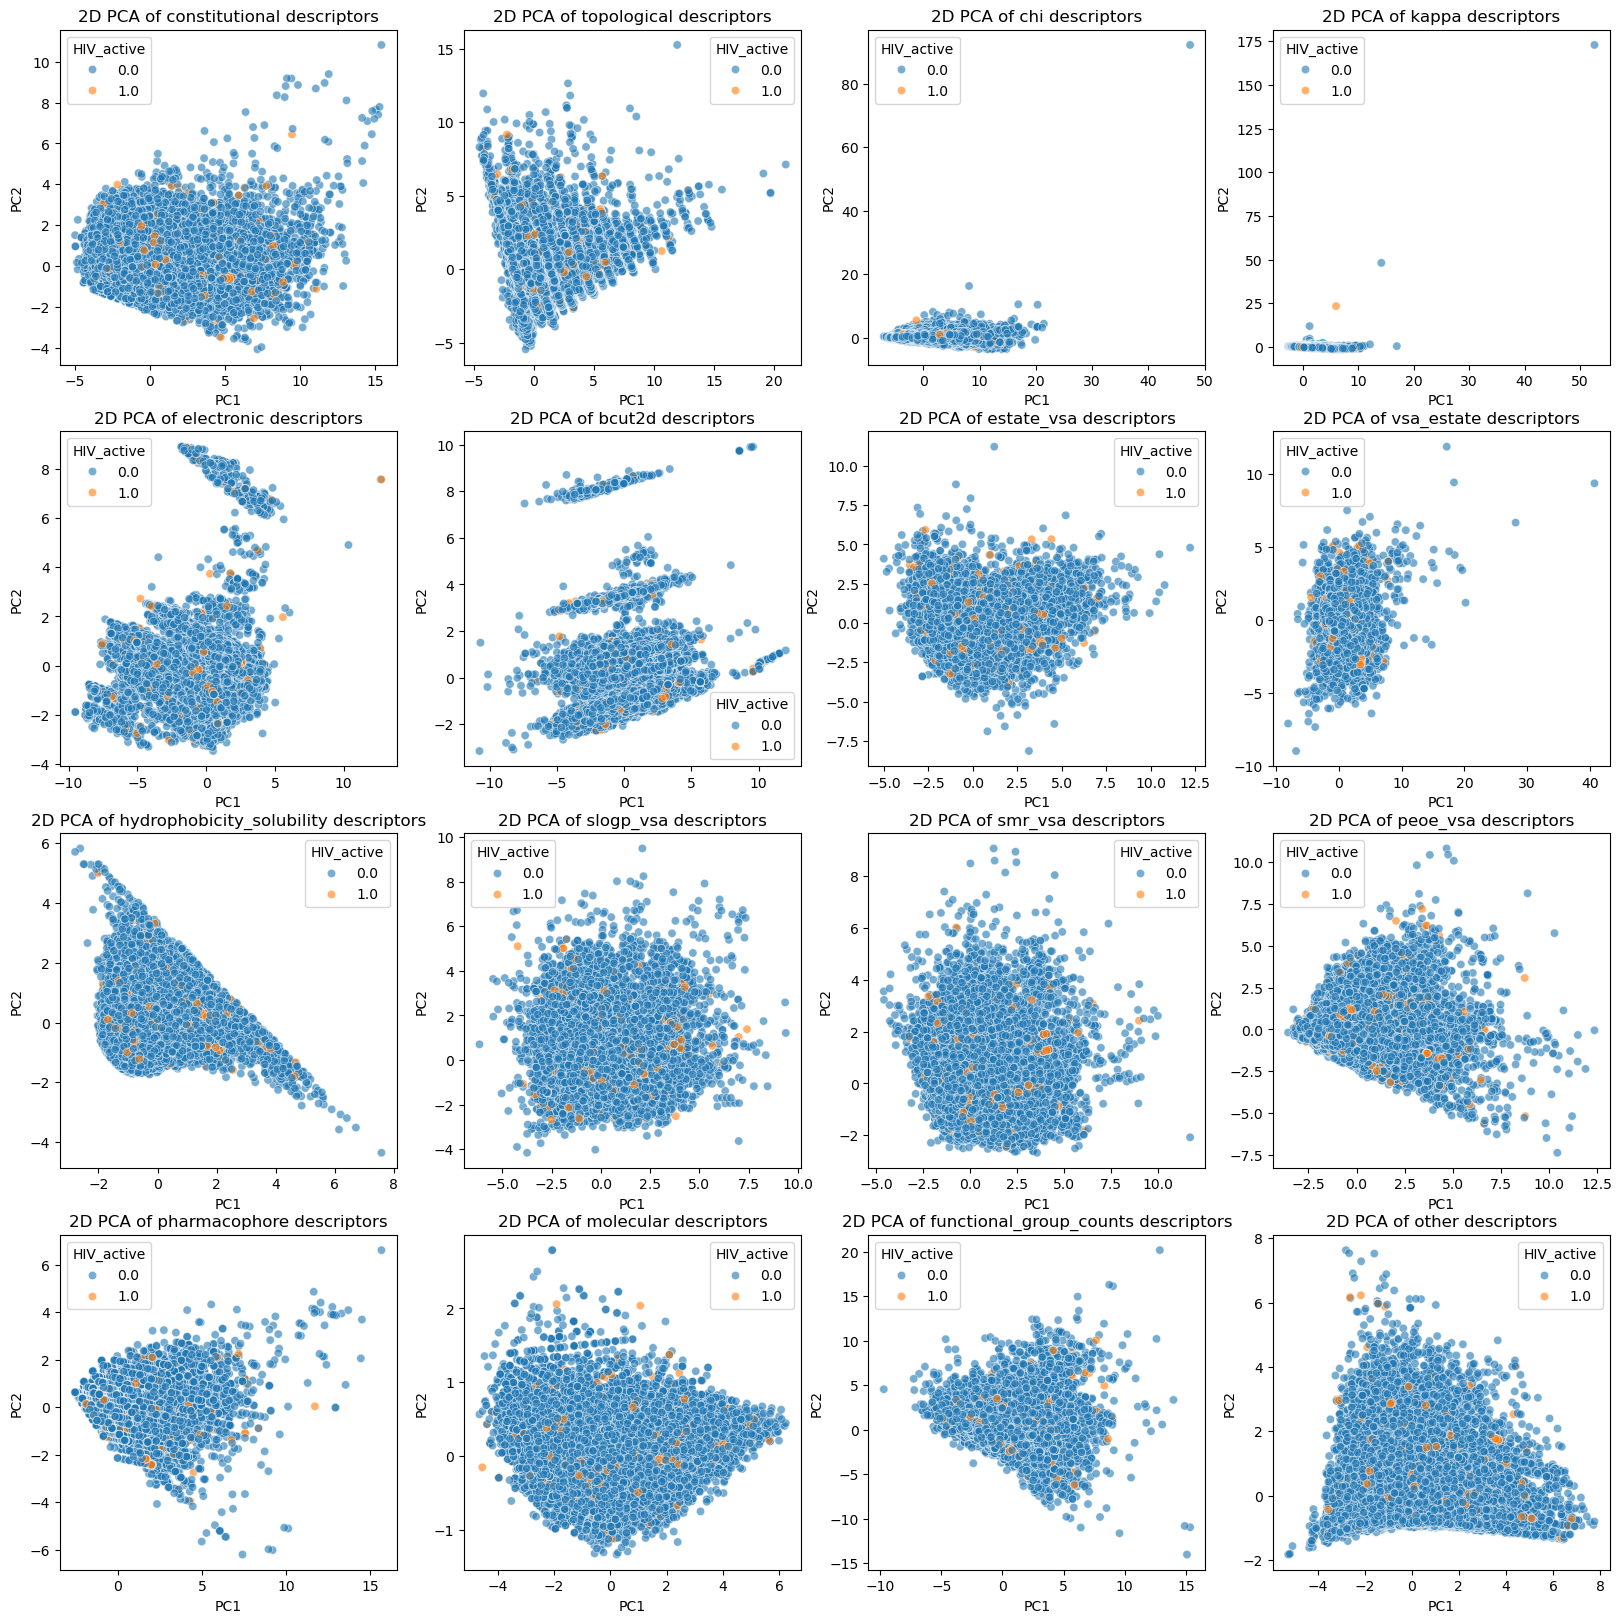

In [107]:
# Transform-fit a PCA on each of the different descriptor type
figure = plt.figure(figsize=(20, 20))
for i, (key, value) in enumerate(desc_dict.items()):
    value = [col for col in value if col not in constant_values]
    if len(value) < 2:
        continue
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(hiv_pca_df[value])
    pca_df = pd.DataFrame(pca_result, columns=["PC1", "PC2"])
    pca_df["HIV_active"] = hiv_pca_df["HIV_active"]
    
    ax = figure.add_subplot(4, 4, i + 1)
    sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="HIV_active", alpha=0.6, ax=ax)
    ax.set_title(f"2D PCA of {key} descriptors")

### 3.3. Correlations between the descriptors

We can also study the correlations between the features. If features are highly correlated, it seems that information is duplicated and can be detrimental to any model applied to this data. A solution is then to remove or combine these features to avoid multicollinearity.

In [30]:
features = hiv_df[selected_descriptors]
print(f"features.shape: {features.shape}")

describe = features.describe()
describe

features.shape: (41127, 210)


MaxAbsEStateIndex  MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex  \
count       41127.000000    41127.000000       41127.000000    41127.000000   
mean           11.132494       11.131486           0.194309       -1.094696   
std             2.676993        2.679170           0.250468        1.532044   
min             1.500000        1.500000           0.000000      -13.993847   
25%            10.647623       10.644848           0.037272       -1.398614   
50%            12.033794       12.033794           0.109845       -0.596935   
75%            12.768292       12.768292           0.247596       -0.182248   
max            19.543884       19.543884           7.668295        1.744213   

                qed           SPS         MolWt  HeavyAtomMolWt    ExactMolWt  \
count  41127.000000  41127.000000  41127.000000    41127.000000  41127.000000   
mean       0.512574     18.108191    370.116515      349.760415    369.679841   
std        0.220989      9.833362    173.628953      163.621868    173.457602   
min        0.005733      3.500000     25.939000       25.939000     26.014408   
25%        0.350863     11.250000    267.403500      252.253000    267.137162   
50%        0.534708     14.520000    333.395000      316.188000    333.085721   
75%        0.687707     21.322005    426.914000      404.298000    426.207062   
max        0.947141    101.200000   3411.450000     3242.106000   3408.552285   

       NumValenceElectrons  ...    fr_sulfide  fr_sulfonamd    fr_sulfone  \
count         41127.000000  ...  41127.000000  41127.000000  41127.000000   
mean            134.115447  ...      0.107618      0.044253      0.019063   
std              64.752073  ...      0.419567      0.248198      0.154922   
min               8.000000  ...      0.000000      0.000000      0.000000   
25%              96.000000  ...      0.000000      0.000000      0.000000   
50%             120.000000  ...      0.000000      0.000000      0.000000   
75%             154.000000  ...      0.000000      0.000000      0.000000   
max            1248.000000  ...     12.000000      8.000000      5.000000   

       fr_term_acetylene  fr_tetrazole   fr_thiazole   fr_thiocyan  \
count       41127.000000  41127.000000  41127.000000  41127.000000   
mean            0.003550      0.002748      0.032023      0.000875   
std             0.065322      0.054172      0.198400      0.036890   
min             0.000000      0.000000      0.000000      0.000000   
25%             0.000000      0.000000      0.000000      0.000000   
50%             0.000000      0.000000      0.000000      0.000000   
75%             0.000000      0.000000      0.000000      0.000000   
max             3.000000      2.000000      6.000000      3.000000   

       fr_thiophene  fr_unbrch_alkane       fr_urea  
count  41127.000000      41127.000000  41127.000000  
mean       0.027938          0.368809      0.037129  
std        0.211686          2.083506      0.223498  
min        0.000000          0.000000      0.000000  
25%        0.000000          0.000000      0.000000  
50%        0.000000          0.000000      0.000000  
75%        0.000000          0.000000      0.000000  
max        8.000000         71.000000      4.000000  

[8 rows x 210 columns]

In [31]:
# Clean features: remove nan, inf, and too large values
features = features.replace([np.inf, -np.inf], np.nan)
# > 1e15 values are considered as too large and are replaced by nan
features = features.mask(features.abs() > 1e15)
features = features.dropna()

features = features.values
print(f"features.shape: {features.shape}")

features.shape: (39111, 210)


In [32]:
# Check for zero variance
zero_variance = np.var(features, axis=0) == 0
if np.any(zero_variance):
    zero_variance_columns = [selected_descriptors[i] for i in np.where(zero_variance)[0]]
    print("Columns with zero variance:", zero_variance_columns)
    features = features[:, ~zero_variance]
    selected_descriptors = [col for col in selected_descriptors if col not in zero_variance_columns]

# Check for NaN values
nan_presence = np.isnan(features).any(axis=0)
if np.any(nan_presence):
    print("Columns with NaN values:", np.where(nan_presence)[0])

# Check for infinite values
inf_presence = np.isinf(features).any(axis=0)
if np.any(inf_presence):
    print("Columns with Inf values:", np.where(inf_presence)[0])

Columns with zero variance: ['NumRadicalElectrons', 'SMR_VSA8', 'SlogP_VSA9', 'fr_prisulfonamd']


In [33]:
# Use numpy to calculate corr coef
corr_mat = np.corrcoef(features.T)
print(f"corr_mat.shape: {corr_mat.shape}")

corr_mat.shape: (206, 206)


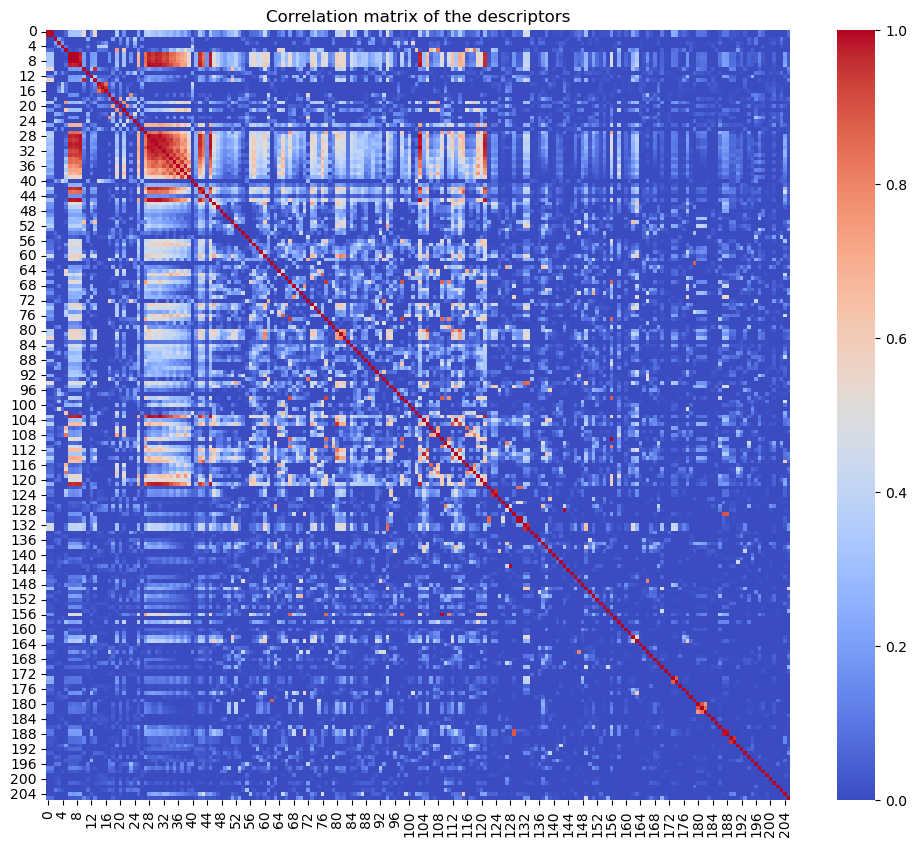

In [34]:
# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_mat, annot=False, cmap='coolwarm', vmin=0, vmax=1)
plt.title("Correlation matrix of the descriptors")
plt.show()  

Some features seems correlated, we can apply a threshold to select them and plot them for conveniently.

In [35]:
# Plot the heatmap with the highly correlated features only 
threshold = 0.95
highly_correlated = np.where(np.abs(corr_mat) > threshold)
highly_correlated = [(selected_descriptors[i], selected_descriptors[j]) for i, j in zip(*highly_correlated) if i != j and i < j]
highly_correlated_descriptors = list(set([item for sublist in highly_correlated for item in sublist]))
print(f"Number of highly correlated features: {len(highly_correlated_descriptors)}")

Number of highly correlated features: 40


In [36]:
# Create a new correlation matrix with only the highly correlated features
highly_correlated_features = hiv_df[[col for col in selected_descriptors if col in highly_correlated_descriptors]]
# Clean features: remove nan, inf, and too large values
highly_correlated_features = highly_correlated_features.replace([np.inf, -np.inf], np.nan)
# > 1e15 values are considered as too large and are replaced by nan
highly_correlated_features = highly_correlated_features.mask(highly_correlated_features.abs() > 1e15)
highly_correlated_features = highly_correlated_features.dropna()

In [37]:
highly_correlated_corr_mat = np.corrcoef(highly_correlated_features.T)
print(f"highly_correlated_corr_mat.shape: {highly_correlated_corr_mat.shape}")

highly_correlated_corr_mat.shape: (40, 40)


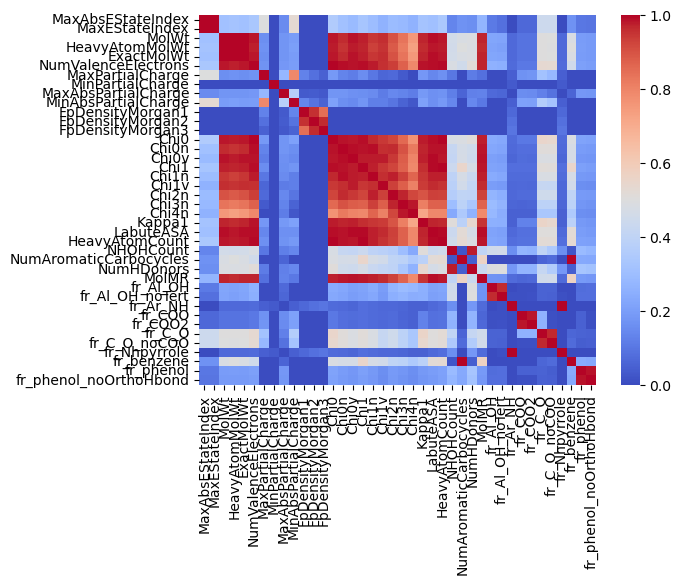

In [38]:
# Plot the heatmap with the highly correlated features only
ax = sns.heatmap(highly_correlated_corr_mat, cmap='coolwarm', xticklabels=highly_correlated_features.columns, yticklabels=highly_correlated_features.columns, vmin=0, vmax=1)

Some features seem highly correlated and could be removed from the dataset to avoid duplication of the information.

In [39]:
# Keep only one of the two variables that are highly correlated
# Create correlation matrix
corr_matrix = hiv_df[selected_descriptors].corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print(f"Number of features to drop: {len(to_drop)}")
print(f"Features to drop: {to_drop}")

Number of features to drop: 30
Features to drop: ['MaxEStateIndex', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'FpDensityMorgan2', 'FpDensityMorgan3', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi3n', 'Chi4n', 'Chi4v', 'Kappa1', 'LabuteASA', 'SlogP_VSA6', 'HeavyAtomCount', 'NOCount', 'NumHDonors', 'MolMR', 'fr_Al_OH_noTert', 'fr_COO2', 'fr_C_O_noCOO', 'fr_Nhpyrrole', 'fr_benzene', 'fr_phenol_noOrthoHbond', 'fr_phos_ester']


In [40]:
# Drop features
features = hiv_df[["smiles", "activity", "HIV_active", "ROMol"] + selected_descriptors].drop(columns=to_drop)
features

smiles activity  HIV_active  \
0      CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...       CI           0   
1      C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...       CI           0   
2                       CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21       CI           0   
3        Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1       CI           0   
4                                 O=S(=O)(O)CCS(=O)(=O)O       CI           0   
...                                                  ...      ...         ...   
41122  CCC1CCC2c3c([nH]c4ccc(C)cc34)C3C(=O)N(N(C)C)C(...       CI           0   
41123  Cc1ccc2[nH]c3c(c2c1)C1CCC(C(C)(C)C)CC1C1C(=O)N...       CI           0   
41124  Cc1ccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)C...       CI           0   
41125  Cc1cccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)...       CI           0   
41126  CCCCCC=C(c1cc(Cl)c(OC)c(-c2nc(C)no2)c1)c1cc(Cl...       CI           0   

                                               ROMol  MaxAbsEStateIndex  \
0      <rdkit.Chem.rdchem.Mol object at 0x1445cf900>           5.925903   
1      <rdkit.Chem.rdchem.Mol object at 0x1445cff20>           6.515117   
2      <rdkit.Chem.rdchem.Mol object at 0x1445cfa50>          12.177015   
3      <rdkit.Chem.rdchem.Mol object at 0x1445cff90>          11.401803   
4      <rdkit.Chem.rdchem.Mol object at 0x144607040>           9.857917   
...                                              ...                ...   
41122  <rdkit.Chem.rdchem.Mol object at 0x153cc0190>          13.370142   
41123  <rdkit.Chem.rdchem.Mol object at 0x153cc0200>          14.160262   
41124  <rdkit.Chem.rdchem.Mol object at 0x153cc0270>          13.962959   
41125  <rdkit.Chem.rdchem.Mol object at 0x153cc02e0>          13.989331   
41126  <rdkit.Chem.rdchem.Mol object at 0x153cc0350>           6.694141   

       MinAbsEStateIndex  MinEStateIndex       qed        SPS    MolWt  ...  \
0               0.759994       -2.330012  0.434358  23.368421  319.888  ...   
1               0.475558       -2.879653  0.104103  17.435897  564.140  ...   
2               0.041001        0.041001  0.581359  12.904762  291.375  ...   
3               0.087790       -4.524487  0.357615  12.583333  370.408  ...   
4               0.980324       -4.296481  0.538723  13.400000  190.198  ...   
...                  ...             ...       ...        ...      ...  ...   
41122           0.007185       -0.366239  0.804191  32.035714  379.504  ...   
41123           0.075082       -0.480928  0.427745  28.888889  484.596  ...   
41124           0.011372       -0.415582  0.450949  29.212121  440.587  ...   
41125           0.009754       -0.416314  0.450949  29.212121  440.587  ...   
41126           0.317797        0.317797  0.187492  11.000000  543.451  ...   

       fr_sulfide  fr_sulfonamd  fr_sulfone  fr_term_acetylene  fr_tetrazole  \
0               0             0           0                  0             0   
1               0             0           0                  0             0   
2               0             0           0                  0             0   
3               0             0           0                  0             0   
4               0             0           0                  0             0   
...           ...           ...         ...                ...           ...   
41122           0             0           0                  0             0   
41123           0             0           0                  0             0   
41124           0             0           0                  0             0   
41125           0             0           0                  0             0   
41126           0             0           0                  0             0   

       fr_thiazole  fr_thiocyan  fr_thiophene  fr_unbrch_alkane  fr_urea  
0                0            0             0                 0        0  
1                0            0             0                 0        0  
2                0            0          

In [41]:
# Save the selected descriptors to csv
features.to_csv("./Datasets/HIV/hiv_selected_descriptors.csv", index=False)

**NB: We dropped some of the highly correlated features from the dataset. By doing so, we avoid multicollinearity and keep some explainability (real descriptors). Another way would have been to use PCA and keep a subset of the initial dataset with enough variance. However, the drawback of this method is the explainability: new orthogonal features are created and we lose the sense of the descriptors.**

### 3.4. First models (decision tree and XGBoost)

Let's implement a first supervised model. Due to the number of features, a Decision Tree or an XGBoost (which handles np.NaN in the dataset) could be interesting to implement. We can test a basic implementation of each one and fine-tune the best model among them.

In [42]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve

In [43]:
features = hiv_df[selected_descriptors]
target = hiv_df['HIV_active']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
print(f"X_train.shape: {X_train.shape}, X_test.shape: {X_test.shape}")

X_train.shape: (32901, 206), X_test.shape: (8226, 206)


In [44]:
def evaluate_model(clf, X_test, y_test):
    """
    Evaluate the model on the test set.
    
    @param clf: the classifier
    @param X_test: the test features
    @param y_test: the test target

    @return: a dictionary with the evaluation metrics
    """
    y_pred = clf.predict(X_test)

    accuracy = clf.score(X_test, y_test)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

    print(f"Accuracy on the training set: {accuracy*100:.2f}%")
    print("Test set:")
    print(f"    - Accuracy: {clf.score(X_test, y_test)*100:.2f}%")
    print(f"    - Precision: {precision*100:.2f}%")
    print(f"    - Recall: {recall*100:.2f}%")
    print(f"    - F1-score: {f1*100:.2f}%")
    print(f"    - ROC AUC: {roc_auc*100:.2f}%")

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc-auc": roc_auc
    }

#### 3.4.1. Dummy model

We can first create a baseline model to compare our models. 

In [46]:
# Baseline model
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy='prior', random_state=2308)

dummy_clf.fit(X_train, y_train)

print("Dummy Classifier:")

_ = evaluate_model(dummy_clf, X_test, y_test)

Dummy Classifier:
Accuracy on the training set: 96.39%
Test set:
    - Accuracy: 96.39%
    - Precision: 0.00%
    - Recall: 0.00%
    - F1-score: 0.00%
    - ROC AUC: 50.00%


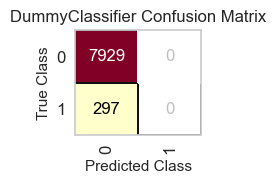

ConfusionMatrix(ax=<Axes: title={'center': 'DummyClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>,
                classes=array([0, 1]),
                cmap=<matplotlib.colors.ListedColormap object at 0x35eb11ac0>,
                estimator=DummyClassifier(random_state=2308))

In [47]:
from yellowbrick.classifier import confusion_matrix

plt.figure(figsize=(2, 2))
classes = target.unique() 
confusion_matrix(dummy_clf, X_train, y_train, X_test, y_test, classes=classes)

**Conclusion:** The dummy model is biased towards the majority class (HIV inactive molecules): all the molecules are predicted inactive. 

The accuracy is not a good metric due to the imbalance of the dataset. We can compute other metrics like recall, precision, or f1-score that give other information. For the following, we will also consider the **ROC-AUC score** (the area under the ROC curve), which serves as a comparison of this dataset according to the MoleculeNet website.

#### 3.4.2. Decision Tree and XGBoost

In [48]:
from sklearn.tree import DecisionTreeClassifier
decision_tree_clf = DecisionTreeClassifier()

decision_tree_clf.fit(X_train, y_train)

print("Decision Tree Classifier:")

_ = evaluate_model(decision_tree_clf, X_test, y_test)

Decision Tree Classifier:
Accuracy on the training set: 96.55%
Test set:
    - Accuracy: 96.55%
    - Precision: 55.12%
    - Recall: 23.57%
    - F1-score: 33.02%
    - ROC AUC: 68.06%


In [50]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier()

xgb_clf.fit(X_train, y_train)

print("XGBoost Classifier:")

_ = evaluate_model(xgb_clf, X_test, y_test)

XGBoost Classifier:
Accuracy on the training set: 97.08%
Test set:
    - Accuracy: 97.08%
    - Precision: 72.80%
    - Recall: 30.64%
    - F1-score: 43.13%
    - ROC AUC: 82.49%


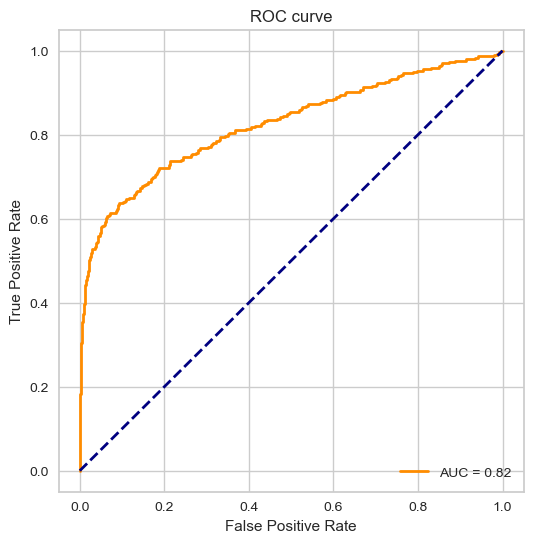

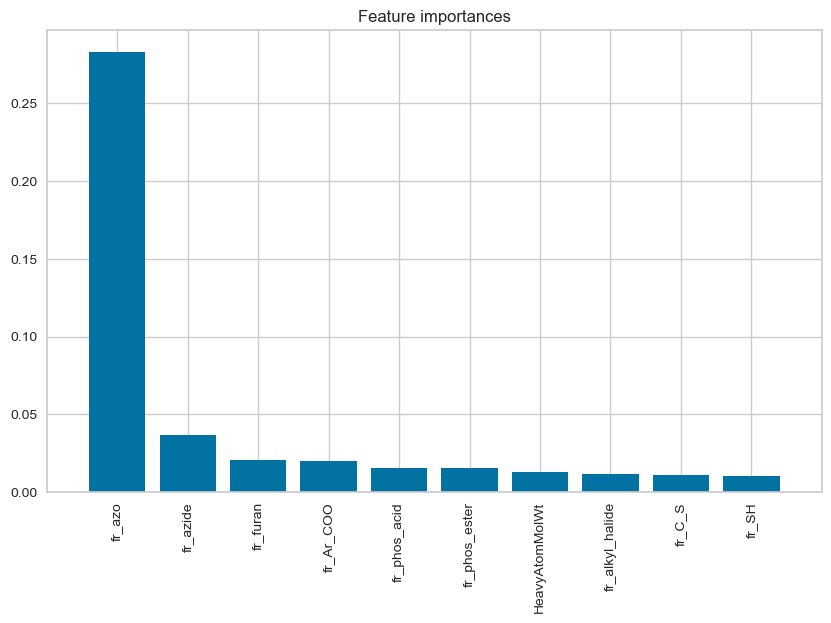

In [51]:
# AUC-ROC
from sklearn.metrics import roc_auc_score, roc_curve

y_pred_proba = xgb_clf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"AUC = {roc_auc_score(y_test, y_pred_proba):.2f}")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

# Feature importance, keep only the top 10 features
feature_importances = xgb_clf.feature_importances_
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(10), feature_importances[indices[:10]], align="center")
plt.xticks(range(10), np.array(selected_descriptors)[indices[:10]], rotation=90)
plt.xlim([-1, 10])
plt.show()

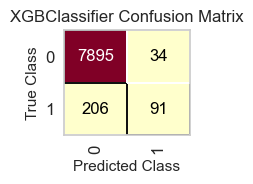

ConfusionMatrix(ax=<Axes: title={'center': 'XGBClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>,
                classes=array([0, 1]),
                cmap=<matplotlib.colors.ListedColormap object at 0x372598460>,
                estimator=XGBClassifier(base_score=None, booster=None,
                                        callbacks=None, colsample_bylevel=None,
                                        colsample_bynode=None,
                                        colsample_bytree=None, device=None,
                                        early_...
                                        gamma=None, grow_policy=None,
                                        importance_type=None,
                                        interaction_constraints=None,
                                        learning_rate=None, max_bin=None,
                                        max_cat_threshold=None,
                                        max_cat_to_onehot=None,
                                        max_delta_step=None, max_depth=None,
                                        max_leaves=None, min_child_weight=None,
                                        missing=nan, monotone_constraints=None,
                                        multi_strategy=None, n_estimators=None,
                                        n_jobs=None, num_parallel_tree=None,
                                        random_state=None, ...))

In [52]:
plt.figure(figsize=(2, 2))
confusion_matrix(xgb_clf, X_train, y_train, X_test, y_test, classes=classes)

**NB: The basic implementation of XGBoost seems to offer the best performance (compared to the decision tree). We can try to search the best hyperparameters for this ensemble model.**

### 3.5. Grid Search for XGBoost

To find the best hyperparameters, train, and evaluate the XGBoost, we will use the scaffold split further explained in Part 9. We do that using the [ogb library](https://ogb.stanford.edu).

In [111]:
# Download Dataset
from ogb.graphproppred import PygGraphPropPredDataset

DATASET_NAME = "ogbg-molhiv"
DATASET_ROOT = "./Datasets"
dataset = PygGraphPropPredDataset(name=DATASET_NAME, root=DATASET_ROOT)

In [112]:
hiv_df = pd.read_csv("./Datasets/HIV/hiv_selected_descriptors.csv")
hiv_df.head()

smiles activity  HIV_active  \
0  CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...       CI           0   
1  C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...       CI           0   
2                   CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21       CI           0   
3    Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1       CI           0   
4                             O=S(=O)(O)CCS(=O)(=O)O       CI           0   

                                           ROMol  MaxAbsEStateIndex  \
0  <rdkit.Chem.rdchem.Mol object at 0x1445cf900>           5.925903   
1  <rdkit.Chem.rdchem.Mol object at 0x1445cff20>           6.515117   
2  <rdkit.Chem.rdchem.Mol object at 0x1445cfa50>          12.177015   
3  <rdkit.Chem.rdchem.Mol object at 0x1445cff90>          11.401803   
4  <rdkit.Chem.rdchem.Mol object at 0x144607040>           9.857917   

   MinAbsEStateIndex  MinEStateIndex       qed        SPS    MolWt  ...  \
0           0.759994       -2.330012  0.434358  23.368421  319.888  ...   
1           0.475558       -2.879653  0.104103  17.435897  564.140  ...   
2           0.041001        0.041001  0.581359  12.904762  291.375  ...   
3           0.087790       -4.524487  0.357615  12.583333  370.408  ...   
4           0.980324       -4.296481  0.538723  13.400000  190.198  ...   

   fr_sulfide  fr_sulfonamd  fr_sulfone  fr_term_acetylene  fr_tetrazole  \
0           0             0           0                  0             0   
1           0             0           0                  0             0   
2           0             0           0                  0             0   
3           0             0           0                  0             0   
4           0             0           0                  0             0   

   fr_thiazole  fr_thiocyan  fr_thiophene  fr_unbrch_alkane  fr_urea  
0            0            0             0                 0        0  
1            0            0             0                 0        0  
2            0            0             0                 0        0  
3            0            0             0                 0        0  
4            0            0             0                 0        0  

[5 rows x 180 columns]

In [116]:
target = hiv_df["HIV_active"]
features = hiv_df.drop(columns=["smiles", "activity", "HIV_active", "ROMol"])
feature_names = features.columns

split_idx = dataset.get_idx_split()

train_idx, valid_idx, test_idx = split_idx["train"], split_idx["valid"], split_idx["test"]

X_train, y_train = features.iloc[train_idx].values, target.iloc[train_idx].values
X_valid, y_valid = features.iloc[valid_idx].values, target.iloc[valid_idx].values
X_test, y_test = features.iloc[test_idx].values, target.iloc[test_idx].values

print(f"X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}")
print(f"X_valid.shape: {X_valid.shape}, y_valid.shape: {y_valid.shape}")
print(f"X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}")

assert X_train.shape[0] + X_valid.shape[0] + X_test.shape[0] == features.shape[0], "Some data is missing"

data = {
    "train": {
        "X": X_train,
        "y": y_train
    },
    "valid": {
        "X": X_valid,
        "y": y_valid
    },
    "test": {
        "X": X_test,
        "y": y_test
    }
}

fit_params = {
    'eval_set': [(data["valid"]["X"], data["valid"]["y"])],
    'verbose': False}

X_train.shape: (32901, 176), y_train.shape: (32901,)
X_valid.shape: (4113, 176), y_valid.shape: (4113,)
X_test.shape: (4113, 176), y_test.shape: (4113,)


In [114]:
from sklearn.metrics import roc_auc_score, roc_curve

def evaluate_model(clf, X_train, y_train, X_valid, y_valid, X_test, y_test, verbose:bool=True):
    y_train_pred = clf.predict_proba(X_train)[:, 1]
    y_valid_pred = clf.predict_proba(X_valid)[:, 1]
    y_test_pred = clf.predict_proba(X_test)[:, 1]

    train_auc = roc_auc_score(y_train, y_train_pred)
    valid_auc = roc_auc_score(y_valid, y_valid_pred)
    test_auc = roc_auc_score(y_test, y_test_pred)

    if verbose:
        print(f"Train AUC: {train_auc*100:.2f}%")
        print(f"Valid AUC: {valid_auc*100:.2f}%")
        print(f"Test AUC: {test_auc*100:.2f}%")
    
    return train_auc, valid_auc, test_auc

In [61]:
def xgb_cv(clf, data, use_train_cv=True, cv_folds=5, early_stopping_rounds=50, plot:bool=True):

    X_train, y_train = data["train"]["X"], data["train"]["y"]
    X_valid, y_valid = data["valid"]["X"], data["valid"]["y"]
    X_test, y_test = data["test"]["X"], data["test"]["y"]
    
    if use_train_cv:
        xgb_param = clf.get_xgb_params()
        dtrain = xgb.DMatrix(X_train, label=y_train)
        cvresult = xgb.cv(
            xgb_param, 
            dtrain, 
            num_boost_round=clf.get_params()['n_estimators'], 
            nfold=cv_folds,
            metrics='auc', 
            early_stopping_rounds=early_stopping_rounds
            )#, show_progress=False)
        clf.set_params(
            n_estimators=cvresult.shape[0],
            eval_metric='auc'
            )
    
    # Fit the algorithm on the data
    clf.fit(X_train, y_train)
        
    # Print model report:
    _ = evaluate_model(clf, X_train, y_train, X_valid, y_valid, X_test, y_test)

    if plot: 
        feature_imp = pd.Series(clf.get_booster().get_score(importance_type='weight')).sort_values(ascending=False)[:90]
        feature_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score (Weight)')

        # Optionally, you can also increase the figure size for better readability
        plt.gcf().set_size_inches(12, 8)  # Width, Height in inches 

        # Set the features names as xticks
        feat_index = [int(f[1:]) for f in feature_imp.index]
        plt.xticks(range(len(feature_imp)), feature_names[feat_index])

        plt.show()

In [62]:
from sklearn.model_selection import GridSearchCV
import json


def get_gridsearch_results(gsearch, save=False, save_path=None):
    # To get the complete results (similar to the old grid_scores_), use cv_results_
    cv_results = gsearch.cv_results_

    # If you want to print the mean test scores for each parameter combination:
    mean_test_scores = cv_results['mean_test_score']
    params_combinations = cv_results['params']
    for score, params in zip(mean_test_scores, params_combinations):
        print(f"Mean test score: {score:.6f}, params: {params}")

    # Get the best parameters and the best score
    best_parameters = gsearch.best_params_
    best_score = gsearch.best_score_
    print(f"-> Best parameters: {best_parameters}, Best score: {best_score:.6f}")

    if save:
        save_path = save_path or "./gridsearch_results.json"
        with open(save_path, "w") as f:
            json.dump({
                "best_parameters": best_parameters,
                "best_score": best_score
            }, f)

    return cv_results, best_parameters, best_score


Model Report:
Accuracy (Train): 99.64%
Accuracy (Valid): 98.30%
Accuracy (Test): 97.13%
ROC AUC (Train): 99.99%
ROC AUC (Valid): 78.33%
ROC AUC (Test): 71.71%


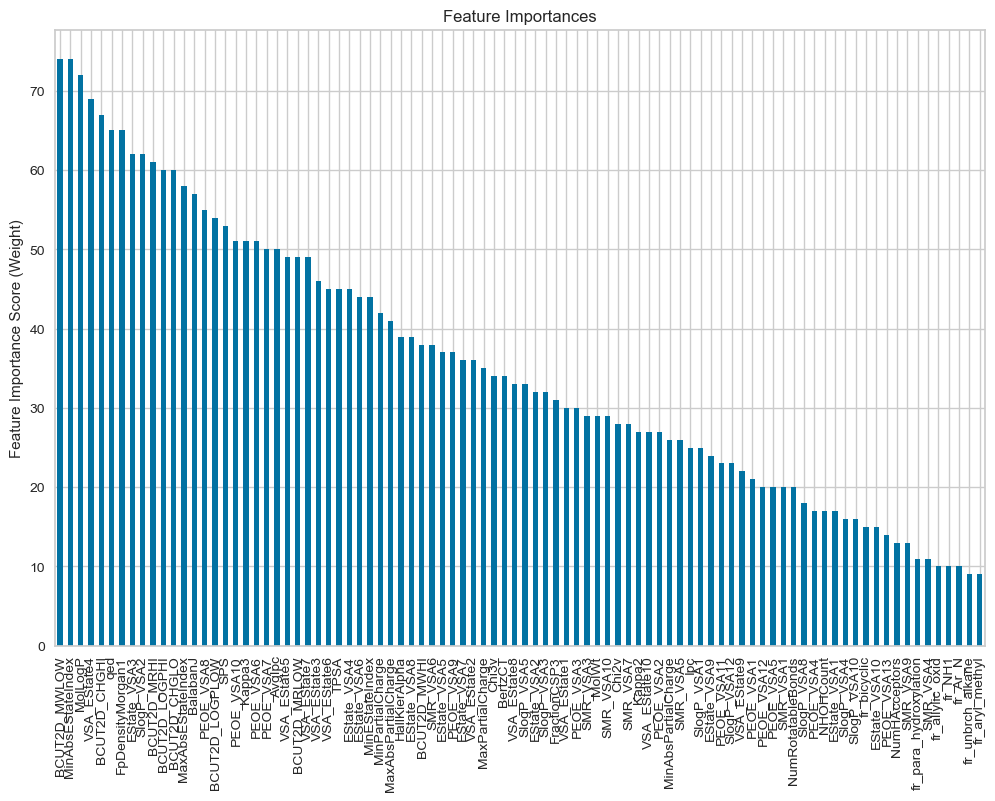

In [63]:
xgb_clf = XGBClassifier(n_estimators = 1000)

xgb_cv(xgb_clf, data, use_train_cv=True, cv_folds=5, early_stopping_rounds=50)

#### 3.5.1. Grid Search, step by step

We can first search for potential optimal hyperparameters step by step.

##### Step 1: Tune max_depth and min_child_weight.

In [64]:
param_test1 = {
 'max_depth': range(3,10,2),
 'min_child_weight': range(1,6,2)
}

gsearch1 = GridSearchCV(
    estimator = XGBClassifier(
        learning_rate = 0.1, n_estimators = 1000,
        max_depth = 5, min_child_weight = 1,
        gamma = 0,
        subsample = 0.8, colsample_bytree = 0.8,
        objective = 'binary:logistic', nthread = 4, scale_pos_weight = 1, seed = 42
    ), 
    param_grid = param_test1, 
    scoring = 'roc_auc',
    n_jobs = 4,
    cv = 5
)
gsearch1.fit(data["train"]["X"], data["train"]["y"], **fit_params)

_ = get_gridsearch_results(gsearch1)

Mean test score: 0.769615, params: {'max_depth': 3, 'min_child_weight': 1}
Mean test score: 0.773257, params: {'max_depth': 3, 'min_child_weight': 3}
Mean test score: 0.769452, params: {'max_depth': 3, 'min_child_weight': 5}
Mean test score: 0.769099, params: {'max_depth': 5, 'min_child_weight': 1}
Mean test score: 0.764986, params: {'max_depth': 5, 'min_child_weight': 3}
Mean test score: 0.771048, params: {'max_depth': 5, 'min_child_weight': 5}
Mean test score: 0.772701, params: {'max_depth': 7, 'min_child_weight': 1}
Mean test score: 0.768200, params: {'max_depth': 7, 'min_child_weight': 3}
Mean test score: 0.773102, params: {'max_depth': 7, 'min_child_weight': 5}
Mean test score: 0.775953, params: {'max_depth': 9, 'min_child_weight': 1}
Mean test score: 0.769763, params: {'max_depth': 9, 'min_child_weight': 3}
Mean test score: 0.774786, params: {'max_depth': 9, 'min_child_weight': 5}
-> Best parameters: {'max_depth': 9, 'min_child_weight': 1}, Best score: 0.775953


We can refine the search:

In [65]:
param_test1b = {
    'max_depth': [6, 7, 8, 9, 10],
    'min_child_weight': [1, 2, 3]
}

gsearch1b = GridSearchCV(
    estimator = XGBClassifier(
        learning_rate = 0.1, n_estimators = 1000,
        max_depth = 9, min_child_weight = 1,
        gamma = 0,
        subsample = 0.8, colsample_bytree = 0.8,
        objective = 'binary:logistic', nthread = 4, scale_pos_weight = 1, seed = 42
    ), 
    param_grid = param_test1b, 
    scoring = 'roc_auc',
    n_jobs = 4,
    cv = 5
)
gsearch1b.fit(data["train"]["X"], data["train"]["y"], **fit_params)

_ = get_gridsearch_results(gsearch1b)

Mean test score: 0.772211, params: {'max_depth': 6, 'min_child_weight': 1}
Mean test score: 0.774184, params: {'max_depth': 6, 'min_child_weight': 2}
Mean test score: 0.769443, params: {'max_depth': 6, 'min_child_weight': 3}
Mean test score: 0.772701, params: {'max_depth': 7, 'min_child_weight': 1}
Mean test score: 0.766419, params: {'max_depth': 7, 'min_child_weight': 2}
Mean test score: 0.768200, params: {'max_depth': 7, 'min_child_weight': 3}
Mean test score: 0.775615, params: {'max_depth': 8, 'min_child_weight': 1}
Mean test score: 0.773489, params: {'max_depth': 8, 'min_child_weight': 2}
Mean test score: 0.776754, params: {'max_depth': 8, 'min_child_weight': 3}
Mean test score: 0.775953, params: {'max_depth': 9, 'min_child_weight': 1}
Mean test score: 0.770743, params: {'max_depth': 9, 'min_child_weight': 2}
Mean test score: 0.769763, params: {'max_depth': 9, 'min_child_weight': 3}
Mean test score: 0.772336, params: {'max_depth': 10, 'min_child_weight': 1}
Mean test score: 0.77652

Let's test the result:

In [66]:
xgb1 = XGBClassifier(
    learning_rate = 0.1, n_estimators = 1000,
    max_depth = 8, min_child_weight = 3,
    gamma = 0.0,
    subsample = 0.8, colsample_bytree = 0.8,
    objective = 'binary:logistic', nthread = 4, scale_pos_weight = 1, seed = 42
)
xgb_cv(xgb1, data, plot=False)

Model Report:
Accuracy (Train): 99.87%
Accuracy (Valid): 98.27%
Accuracy (Test): 97.11%
ROC AUC (Train): 100.00%
ROC AUC (Valid): 79.81%
ROC AUC (Test): 73.94%


In [67]:
xgb1b = XGBClassifier(
    learning_rate = 0.1, n_estimators = 1000,
    max_depth = 9, min_child_weight = 1,
    gamma = 0.0,
    subsample = 0.8, colsample_bytree = 0.8,
    objective = 'binary:logistic', nthread = 4, scale_pos_weight = 1, seed = 42
)
xgb_cv(xgb1b, data, plot=False)

Model Report:
Accuracy (Train): 99.99%
Accuracy (Valid): 98.35%
Accuracy (Test): 97.20%
ROC AUC (Train): 100.00%
ROC AUC (Valid): 81.57%
ROC AUC (Test): 76.94%


In [72]:
xgb1c = XGBClassifier(
    learning_rate = 0.1, n_estimators = 1000,
    max_depth = 8, min_child_weight = 1,
    gamma = 0.0,
    subsample = 0.8, colsample_bytree = 0.8,
    objective = 'binary:logistic', nthread = 4, scale_pos_weight = 1, seed = 42
)
xgb_cv(xgb1c, data, plot=False)

Model Report:
Accuracy (Train): 98.23%
Accuracy (Valid): 98.23%
Accuracy (Test): 97.18%
ROC AUC (Train): 99.63%
ROC AUC (Valid): 81.92%
ROC AUC (Test): 77.81%


##### Step 2: Tune gamma

In [68]:
param_test2 = {
    'gamma': [i/10.0 for i in range(0,5)]
}

gsearch2 = GridSearchCV(
    estimator = XGBClassifier(
        learning_rate = 0.1, n_estimators = 1000,
        max_depth = 9, min_child_weight = 1,
        gamma = 0,
        subsample = 0.8, colsample_bytree = 0.8,
        objective = 'binary:logistic', nthread = 4, scale_pos_weight = 1, seed = 42
    ), 
    param_grid = param_test2, 
    scoring = 'roc_auc',
    n_jobs = 4,
    cv = 5
)
gsearch2.fit(data["train"]["X"], data["train"]["y"], **fit_params)

_ = get_gridsearch_results(gsearch2)

Mean test score: 0.775953, params: {'gamma': 0.0}
Mean test score: 0.776279, params: {'gamma': 0.1}
Mean test score: 0.776695, params: {'gamma': 0.2}
Mean test score: 0.774123, params: {'gamma': 0.3}
Mean test score: 0.778739, params: {'gamma': 0.4}
-> Best parameters: {'gamma': 0.4}, Best score: 0.778739


In [73]:
xgb2 = XGBClassifier(
    learning_rate = 0.1, n_estimators = 1000,
    max_depth = 8, min_child_weight = 1,
    gamma = 0.4,
    subsample = 0.8, colsample_bytree = 0.8,
    objective = 'binary:logistic', nthread = 4, scale_pos_weight = 1, seed = 42
)
xgb_cv(xgb2, data, plot=False)

Model Report:
Accuracy (Train): 99.17%
Accuracy (Valid): 98.27%
Accuracy (Test): 97.08%
ROC AUC (Train): 99.97%
ROC AUC (Valid): 79.71%
ROC AUC (Test): 75.42%


In [74]:
xgb2 = XGBClassifier(
    learning_rate = 0.1, n_estimators = 1000,
    max_depth = 8, min_child_weight = 1,
    gamma = 0.0,
    subsample = 0.8, colsample_bytree = 0.8,
    objective = 'binary:logistic', nthread = 4, scale_pos_weight = 1, seed = 42
)
xgb_cv(xgb2, data, plot=False)

Model Report:
Accuracy (Train): 98.23%
Accuracy (Valid): 98.23%
Accuracy (Test): 97.18%
ROC AUC (Train): 99.63%
ROC AUC (Valid): 81.92%
ROC AUC (Test): 77.81%


##### Step 3: Tune subsample and colsample_bytree

In [75]:
param_test3 = {
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}

gsearch3 = GridSearchCV(
    estimator = XGBClassifier(
        learning_rate = 0.1, n_estimators = 1000,
        max_depth = 8, min_child_weight = 1,
        gamma = 0.0,
        subsample = 0.8, colsample_bytree = 0.8,
        objective = 'binary:logistic', nthread = 4, scale_pos_weight = 1, seed = 42
    ), 
    param_grid = param_test3, 
    scoring = 'roc_auc',
    n_jobs = 4,
    cv = 5
)
gsearch3.fit(data["train"]["X"], data["train"]["y"], **fit_params)

_ = get_gridsearch_results(gsearch3)

Mean test score: 0.773872, params: {'colsample_bytree': 0.6, 'subsample': 0.6}
Mean test score: 0.772858, params: {'colsample_bytree': 0.6, 'subsample': 0.7}
Mean test score: 0.775374, params: {'colsample_bytree': 0.6, 'subsample': 0.8}
Mean test score: 0.773786, params: {'colsample_bytree': 0.6, 'subsample': 0.9}
Mean test score: 0.769810, params: {'colsample_bytree': 0.7, 'subsample': 0.6}
Mean test score: 0.774289, params: {'colsample_bytree': 0.7, 'subsample': 0.7}
Mean test score: 0.771451, params: {'colsample_bytree': 0.7, 'subsample': 0.8}
Mean test score: 0.778383, params: {'colsample_bytree': 0.7, 'subsample': 0.9}
Mean test score: 0.761792, params: {'colsample_bytree': 0.8, 'subsample': 0.6}
Mean test score: 0.768312, params: {'colsample_bytree': 0.8, 'subsample': 0.7}
Mean test score: 0.775615, params: {'colsample_bytree': 0.8, 'subsample': 0.8}
Mean test score: 0.777319, params: {'colsample_bytree': 0.8, 'subsample': 0.9}
Mean test score: 0.765735, params: {'colsample_bytre

In [76]:
param_test3b = {
    'colsample_bytree':[i/100.0 for i in range(65, 90, 5)],
    'subsample':[i/100.0 for i in range(75, 95, 5)]
}

gsearch3b = GridSearchCV(
    estimator = XGBClassifier(
        learning_rate = 0.1, n_estimators = 100,
        max_depth = 8, min_child_weight = 1,
        gamma = 0.0,
        subsample = 0.8, colsample_bytree = 0.8,
        objective = 'binary:logistic', nthread = 4, scale_pos_weight = 1, seed = 42
    ), 
    param_grid = param_test3b, 
    scoring = 'roc_auc',
    n_jobs = 4,
    cv = 5
)
gsearch3b.fit(data["train"]["X"], data["train"]["y"], **fit_params)

_ = get_gridsearch_results(gsearch3b)

Mean test score: 0.781687, params: {'colsample_bytree': 0.65, 'subsample': 0.75}
Mean test score: 0.771718, params: {'colsample_bytree': 0.65, 'subsample': 0.8}
Mean test score: 0.774502, params: {'colsample_bytree': 0.65, 'subsample': 0.85}
Mean test score: 0.780074, params: {'colsample_bytree': 0.65, 'subsample': 0.9}
Mean test score: 0.781597, params: {'colsample_bytree': 0.7, 'subsample': 0.75}
Mean test score: 0.775840, params: {'colsample_bytree': 0.7, 'subsample': 0.8}
Mean test score: 0.780149, params: {'colsample_bytree': 0.7, 'subsample': 0.85}
Mean test score: 0.784670, params: {'colsample_bytree': 0.7, 'subsample': 0.9}
Mean test score: 0.787182, params: {'colsample_bytree': 0.75, 'subsample': 0.75}
Mean test score: 0.777776, params: {'colsample_bytree': 0.75, 'subsample': 0.8}
Mean test score: 0.772302, params: {'colsample_bytree': 0.75, 'subsample': 0.85}
Mean test score: 0.777332, params: {'colsample_bytree': 0.75, 'subsample': 0.9}
Mean test score: 0.782316, params: {'c

In [78]:
xgb3 = XGBClassifier(
    learning_rate = 0.1, n_estimators = 1000,
    max_depth = 8, min_child_weight = 1,
    gamma = 0.0,
    subsample = 0.75, colsample_bytree = 0.75,
    objective = 'binary:logistic', nthread = 4, scale_pos_weight = 1, seed = 42
)
xgb_cv(xgb3, data, plot=False)

Model Report:
Accuracy (Train): 98.51%
Accuracy (Valid): 98.32%
Accuracy (Test): 97.16%
ROC AUC (Train): 99.86%
ROC AUC (Valid): 82.27%
ROC AUC (Test): 76.63%


##### Step 4: Tuning regularization parameters

In [80]:
param_test4 = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
    'reg_lambda':[1e-5, 1e-2, 0.1, 1, 100],
}

gsearch4 = GridSearchCV(
    estimator = XGBClassifier(
        learning_rate = 0.1, n_estimators = 1000,
        max_depth = 8, min_child_weight = 1,
        gamma = 0.0,
        subsample = 0.8, colsample_bytree = 0.8,
        objective = 'binary:logistic', nthread = 4, scale_pos_weight = 1, seed = 42
    ), 
    param_grid = param_test4, 
    scoring = 'roc_auc',
    n_jobs = 4,
    cv = 5
)
gsearch4.fit(data["train"]["X"], data["train"]["y"], **fit_params)

_ = get_gridsearch_results(gsearch4)

Mean test score: 0.771707, params: {'reg_alpha': 1e-05, 'reg_lambda': 1e-05}
Mean test score: 0.769078, params: {'reg_alpha': 1e-05, 'reg_lambda': 0.01}
Mean test score: 0.771916, params: {'reg_alpha': 1e-05, 'reg_lambda': 0.1}
Mean test score: 0.774701, params: {'reg_alpha': 1e-05, 'reg_lambda': 1}
Mean test score: 0.782221, params: {'reg_alpha': 1e-05, 'reg_lambda': 100}
Mean test score: 0.766757, params: {'reg_alpha': 0.01, 'reg_lambda': 1e-05}
Mean test score: 0.770137, params: {'reg_alpha': 0.01, 'reg_lambda': 0.01}
Mean test score: 0.773337, params: {'reg_alpha': 0.01, 'reg_lambda': 0.1}
Mean test score: 0.772510, params: {'reg_alpha': 0.01, 'reg_lambda': 1}
Mean test score: 0.778369, params: {'reg_alpha': 0.01, 'reg_lambda': 100}
Mean test score: 0.767758, params: {'reg_alpha': 0.1, 'reg_lambda': 1e-05}
Mean test score: 0.773133, params: {'reg_alpha': 0.1, 'reg_lambda': 0.01}
Mean test score: 0.771282, params: {'reg_alpha': 0.1, 'reg_lambda': 0.1}
Mean test score: 0.775185, para

In [81]:
xgb4 = XGBClassifier(
    learning_rate = 0.1, n_estimators = 1000,
    max_depth = 8, min_child_weight = 1,
    gamma = 0.0,
    subsample = 0.8, colsample_bytree = 0.8,
    reg_alpha=1e-05, reg_lambda=100,
    objective = 'binary:logistic', nthread = 4, scale_pos_weight = 1, seed = 42
)
xgb_cv(xgb4, data, plot=False)

Model Report:
Accuracy (Train): 98.44%
Accuracy (Valid): 98.30%
Accuracy (Test): 97.20%
ROC AUC (Train): 99.79%
ROC AUC (Valid): 81.32%
ROC AUC (Test): 74.62%


#### 3.5.2. Brute Force Grid Search

Now we have a better idea of the parameters, we can perform a grid search and all the hyperparameters at the same time. It will take a long time to process!

In [55]:
param_test = {
    'max_depth': range(3,10,2),
    'min_child_weight': range(1,6,2),
    'gamma': [i/10.0 for i in range(0,3)],
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)],
}

gsearch = GridSearchCV(
    estimator = XGBClassifier(
        learning_rate = 0.1, n_estimators = 1000,
        max_depth = 8, min_child_weight = 1,
        gamma = 0.0,
        subsample = 0.9, colsample_bytree = 0.7,
        objective = 'binary:logistic', nthread = 4, scale_pos_weight = 1, seed = 42,
    ), 
    param_grid = param_test, 
    scoring = 'roc_auc',
    n_jobs = 4,
    cv = 5
)
gsearch.fit(data["train"]["X"], data["train"]["y"], **fit_params)

_ = get_gridsearch_results(gsearch, save=True)

Mean test score: 0.773076, params: {'colsample_bytree': 0.6, 'gamma': 0.0, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.6}
Mean test score: 0.770344, params: {'colsample_bytree': 0.6, 'gamma': 0.0, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.7}
Mean test score: 0.770025, params: {'colsample_bytree': 0.6, 'gamma': 0.0, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.8}
Mean test score: 0.767989, params: {'colsample_bytree': 0.6, 'gamma': 0.0, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.9}
Mean test score: 0.768711, params: {'colsample_bytree': 0.6, 'gamma': 0.0, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.6}
Mean test score: 0.773484, params: {'colsample_bytree': 0.6, 'gamma': 0.0, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.7}
Mean test score: 0.772392, params: {'colsample_bytree': 0.6, 'gamma': 0.0, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.8}
Mean test score: 0.769458, params: {'colsample_bytree': 0.6, 'gamma': 0.0, '

NB: The results seem optimal for the train and validation sets, we can still play around with the hyperparameters to determine the best for the test set.

In [82]:
xgb5 = XGBClassifier(
    learning_rate = 1e-1, n_estimators = 1000,
    max_depth = 9, min_child_weight = 1,
    gamma = 0.2,
    subsample = 0.9, colsample_bytree = 0.9,
    objective = 'binary:logistic', nthread = 4, scale_pos_weight = 1, seed = 42,
)
xgb_cv(xgb5, data, plot=False)

Model Report:
Accuracy (Train): 100.00%
Accuracy (Valid): 98.27%
Accuracy (Test): 97.11%
ROC AUC (Train): 100.00%
ROC AUC (Valid): 82.40%
ROC AUC (Test): 74.41%


Finally, the best configuration for the XGBoost seems to be the following one:

In [83]:
xgb_best = XGBClassifier(
    learning_rate = 0.1, n_estimators = 1000,
    max_depth = 8, min_child_weight = 1,
    gamma = 0.0,
    subsample = 0.8, colsample_bytree = 0.8,
    objective = 'binary:logistic', nthread = 4, scale_pos_weight = 1, seed = 42,
)
xgb_cv(xgb_best, data, plot=False)

Model Report:
Accuracy (Train): 98.23%
Accuracy (Valid): 98.23%
Accuracy (Test): 97.18%
ROC AUC (Train): 99.63%
ROC AUC (Valid): 81.92%
ROC AUC (Test): 77.81%


#### 3.5.3. Imbalanced Dataset

As described previously, the dataset is very imbalanced (~3% of active molecules). We can try to change the `scale_pos_weight` parameter and see if it improves the results.

In [84]:
scale_pos_weight = np.sqrt((len(y_train) - sum(y_train)) / sum(y_train))
print(f"scale_pos_weight: {scale_pos_weight}")

scale_pos_weight: 5.070045082921565


In [115]:
xgb6 = XGBClassifier(
    learning_rate = 0.1, n_estimators = 1000,
    max_depth = 7, min_child_weight = 2, 
    gamma = 0.0,
    subsample = 0.8, colsample_bytree = 0.8,
    scale_pos_weight=scale_pos_weight,
    objective = 'binary:logistic', nthread = 4, seed = 42,
)
xgb_cv(xgb6, data, plot=False)

Model Report:
Accuracy (Train): 99.55%
Accuracy (Valid): 98.20%
Accuracy (Test): 97.08%
ROC AUC (Train): 99.93%
ROC AUC (Valid): 82.04%
ROC AUC (Test): 74.79%


**NB:** Here, it does not seem to improve the model...

### 3.6. Summary of the exploration

In the end, we extensively explored the hyperparameter space:

| Hyperparameter        | Description                                                                                   | Space Explored                  |
|-----------------------|-----------------------------------------------------------------------------------------------|---------------------------------|
| `learning_rate`       | The step size shrinkage used to prevent overfitting.                                          | {0.1, 1e-3}                             |
| `n_estimators`        | The number of gradient boosted trees.                                                         | {25, 40, 50, 60, 100, 500, 1000}                            |
| `max_depth`           | The maximum depth of the trees.                                                               | {3, 5, 7, 9}                      |
| `min_child_weight`    | Minimum sum of instance weight (hessian) needed in a child.                                   | {1, 3, 5}                         |
| `gamma`               | Minimum loss reduction required to make a further partition on a leaf node of the tree.       | {0.0, 0.1, 0.2}                   |
| `subsample`           | Subsample ratio of the training instances.                                                    | {0.6, 0.7, 0.8, 0.9}              |
| `colsample_bytree`    | Subsample ratio of columns when constructing each tree.                                       | {0.6, 0.7, 0.8, 0.9}              |
| `objective`           | The learning task and the corresponding learning objective.                                   | 'binary:logistic'               |
| `nthread`             | Number of parallel threads used to run XGBoost.                                               | 4                               |
| `scale_pos_weight`    | Balancing of positive and negative weights.                                                   | {1, 5.07}                               |


In [187]:
import matplotlib.pyplot as plt

import xgboost as xgb
from xgboost import XGBClassifier

def xgb_modelfit(xgb_clf, data, folds:int=5, plot:bool=False):
    train_aucs, valid_aucs, test_aucs = [], [], []
    
    for _ in range(folds):
        X_train, y_train = data["train"]["X"], data["train"]["y"]
        X_valid, y_valid = data["valid"]["X"], data["valid"]["y"]
        X_test, y_test = data["test"]["X"], data["test"]["y"]
        xgb_clf.fit(X_train, y_train)
        train_auc, valid_auc, test_auc = evaluate_model(xgb_clf, X_train, y_train, X_valid, y_valid, X_test, y_test, verbose=False)
        train_aucs.append(train_auc)
        valid_aucs.append(valid_auc)
        test_aucs.append(test_auc)
    
    print(f"\t-> Training AUC: {np.mean(train_aucs) * 100:.2f}% +/- {np.std(train_aucs) * 100:.2f}")
    print(f"\t-> Validation AUC: {np.mean(valid_aucs) * 100:.2f}% +/- {np.std(valid_aucs) * 100:.2f}")
    print(f"\t-> Test AUC: {np.mean(test_aucs) * 100:.2f}% +/- {np.std(test_aucs) * 100:.2f}")

    if plot: 
        # Plot the ROC-AUC curve for the train, validation, test
        fpr, tpr, _ = roc_curve(y_train, xgb_clf.predict_proba(X_train)[:, 1])
        train_auc = roc_auc_score(y_train, xgb_clf.predict_proba(X_train)[:, 1])
        plt.plot(fpr, tpr, label=f"Train AUC: {train_auc*100:.2f}%")

        fpr, tpr, _ = roc_curve(y_valid, xgb_clf.predict_proba(X_valid)[:, 1])
        valid_auc = roc_auc_score(y_valid, xgb_clf.predict_proba(X_valid)[:, 1])
        plt.plot(fpr, tpr, label=f"Valid AUC: {valid_auc*100:.2f}%")

        fpr, tpr, _ = roc_curve(y_test, xgb_clf.predict_proba(X_test)[:, 1])
        test_auc = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1])
        plt.plot(fpr, tpr, lw=2, label=f"Test AUC: {test_auc*100:.2f}%")

        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC curve')
        plt.legend(loc="lower right")
        plt.show()

In [157]:
scale_pos_weight = np.sqrt((len(y_train) - sum(y_train)) / sum(y_train))
print(f"scale_pos_weight: {scale_pos_weight}")

scale_pos_weight: 5.070045082921565


	-> Training AUC: 97.94% +/- 0.00
	-> Validation AUC: 80.15% +/- 0.00
	-> Test AUC: 76.34% +/- 0.00


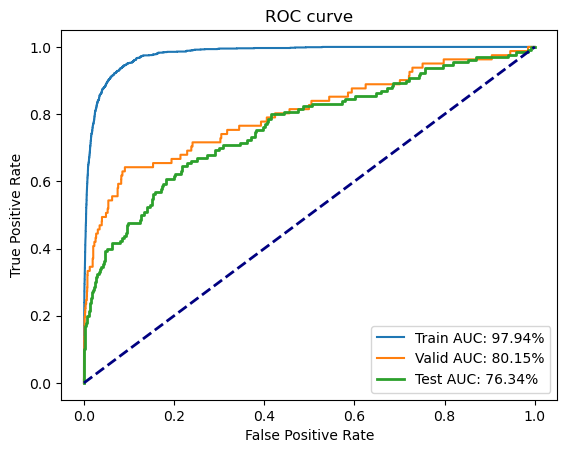

In [185]:
xgb_clf = XGBClassifier(
    learning_rate = 1e-1, n_estimators = 50, 
    max_depth = 6, min_child_weight = 1,
    gamma = 0.1,
    subsample = 0.9, colsample_bytree = 0.95,
    objective = 'binary:logistic', nthread = 4, scale_pos_weight = scale_pos_weight, 
    warm_start=True
)
xgb_modelfit(xgb_clf, data, folds=30, plot=True)

## 4. Molecular Fingerprints

In the following, we will consider another type of descriptors for the molecules, introduces by [Rogers et al.](https://pubs.acs.org/doi/epdf/10.1021/ci100050t): extended-connectivity fingerprints are a novel class of topological fingerprints designed to capture features relevant to molecular activity.

Molecular fingerprints such as Morgan, RDKit, and MACCS Keys, used here, offer  advantages for encoding chemical structures into a format that algorithms can process efficiently. Morgan Fingerprints capture local molecular structures with variable granularity by representing the presence or absence of substructures around each atom. RDKit Fingerprints generate a binary vector from paths of atoms up to a certain length, providing detailed topological information. MACCS Keys use a predefined set of 166 keys that represent common molecular substructures.

These fingerprints effectively summarize complex chemical information into structured formats that capture both the presence and absence of specific molecular features. In the following, we will use them as inputs of ensemble models like xgboost or random forest.

### 4.1. Load the fingerprints

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from rdkit import Chem
from rdkit.Chem import AllChem, MACCSkeys

from ogb.graphproppred import GraphPropPredDataset, Evaluator

In [4]:
dataset = GraphPropPredDataset(name = "ogbg-molhiv", root = './Datasets')

data = pd.read_csv(f"./dataset/ogbg_molhiv/mapping/mol.csv.gz".replace("-", "_"))
smiles = data["smiles"]
outcome = data.set_index("smiles").drop(["mol_id"], axis = 1)

smi = data.smiles
mol = [Chem.MolFromSmiles(x) for x in smi]

[21:34:05] WARNING: not removing hydrogen atom without neighbors
[21:34:05] WARNING: not removing hydrogen atom without neighbors


In [5]:
# Morgan Fingerprint 
MFP_df = pd.DataFrame(np.array([AllChem.GetMorganFingerprintAsBitVect(x,radius = 3, nBits=3*1024) for x in tqdm(mol)], dtype= np.int8))
MFP_df = pd.concat([data.HIV_active,MFP_df], axis=1)
print(f"MFP_df.shape: {MFP_df.shape}")
MFP_df.head()

100%|██████████| 41127/41127 [00:02<00:00, 14123.83it/s]


MFP_df.shape: (41127, 3073)


HIV_active  0  1  2  3  4  5  6  7  8  ...  3062  3063  3064  3065  3066  \
0           0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0   
1           0  0  0  0  0  0  0  0  0  1  ...     0     0     0     0     0   
2           0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     1   
3           0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0   
4           0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0   

   3067  3068  3069  3070  3071  
0     0     0     0     0     0  
1     0     0     0     0     0  
2     0     0     0     0     0  
3     0     0     0     0     0  
4     0     0     0     0     0  

[5 rows x 3073 columns]

In [6]:
# MACCS Keys 
MACCS_keys_df = pd.DataFrame(np.array([MACCSkeys.GenMACCSKeys(x) for x in tqdm(mol)], dtype=np.int8))
print(f"MACCS_keys_df.shape: {MACCS_keys_df.shape}")
MACCS_keys_df.head()

  0%|          | 0/41127 [00:00<?, ?it/s]

100%|██████████| 41127/41127 [00:29<00:00, 1394.29it/s]


MACCS_keys_df.shape: (41127, 167)


0    1    2    3    4    5    6    7    8    9    ...  157  158  159  160  \
0    0    0    0    0    0    0    0    0    0    0  ...    0    0    1    1   
1    0    0    0    0    0    0    0    0    0    0  ...    0    0    1    0   
2    0    0    0    0    0    0    0    0    0    0  ...    0    1    0    1   
3    0    0    0    0    0    0    0    0    0    0  ...    0    1    1    0   
4    0    0    0    0    0    0    0    0    0    0  ...    0    0    1    0   

   161  162  163  164  165  166  
0    0    0    1    1    1    0  
1    0    1    1    1    1    0  
2    1    1    1    1    1    0  
3    1    1    1    1    1    0  
4    0    0    0    1    0    0  

[5 rows x 167 columns]

In [7]:
# RDKit Fingerprint
rdkbi = {}
RDFP_df = pd.DataFrame(np.array([Chem.RDKFingerprint(x, maxPath = 5, bitInfo=rdkbi)for x in tqdm(mol)], dtype = np.int8))
print(f"RDFP_df.shape: {RDFP_df.shape}")
RDFP_df.head()

100%|██████████| 41127/41127 [00:34<00:00, 1209.16it/s]


RDFP_df.shape: (41127, 2048)


0     1     2     3     4     5     6     7     8     9     ...  2038  \
0     0     0     0     0     0     0     0     0     0     0  ...     0   
1     0     0     0     0     0     0     0     0     0     0  ...     1   
2     0     0     0     0     0     0     0     0     0     0  ...     0   
3     0     0     0     0     0     0     0     0     0     0  ...     0   
4     0     0     0     0     0     0     0     0     0     0  ...     0   

   2039  2040  2041  2042  2043  2044  2045  2046  2047  
0     0     0     0     0     0     1     0     0     0  
1     0     0     0     0     0     1     0     0     0  
2     0     0     0     0     0     0     0     0     1  
3     0     0     0     0     0     0     0     0     0  
4     0     0     0     0     0     0     0     0     0  

[5 rows x 2048 columns]

In [8]:
# Concatenate the three dataframes and rename columns given only a number
fingerprint_df = pd.concat([MFP_df, MACCS_keys_df, RDFP_df], axis=1)
fingerprint_df.columns = [col if col == "HIV_active" else i for i, col in enumerate(fingerprint_df.columns)]
print(f"fingerprint_df.shape: {fingerprint_df.shape}")
fingerprint_df.head()

fingerprint_df.shape: (41127, 5288)


HIV_active  1  2  3  4  5  6  7  8  9  ...  5278  5279  5280  5281  5282  \
0           0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0   
1           0  0  0  0  0  0  0  0  0  1  ...     1     0     0     0     0   
2           0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0   
3           0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0   
4           0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0   

   5283  5284  5285  5286  5287  
0     0     1     0     0     0  
1     0     1     0     0     0  
2     0     0     0     0     1  
3     0     0     0     0     0  
4     0     0     0     0     0  

[5 rows x 5288 columns]

As for the general descriptors, we can remove highly correlated features.

In [9]:
# Remove columns with only 0 or only 1
fingerprint = fingerprint_df.values
zero_variance = np.var(fingerprint, axis=0) == 0
if np.any(zero_variance):
    zero_variance_columns = [fingerprint_df.columns[i] for i in np.where(zero_variance)[0]]
    print("Columns with zero variance:", zero_variance_columns)
    fingerprint_df = fingerprint_df.drop(columns=zero_variance_columns)
print(f"fingerprint_df.shape: {fingerprint_df.shape}")

Columns with zero variance: [3073, 3074, 3075]
fingerprint_df.shape: (41127, 5285)


In [15]:
# Save the dataframe 
fingerprint_df.to_csv("./Datasets/HIV/hiv_fingerprints.csv", index=False)

In [ ]:
# Load the dataset
fingerprint_df = pd.read_csv("./Datasets/HIV/hiv_fingerprints.csv")

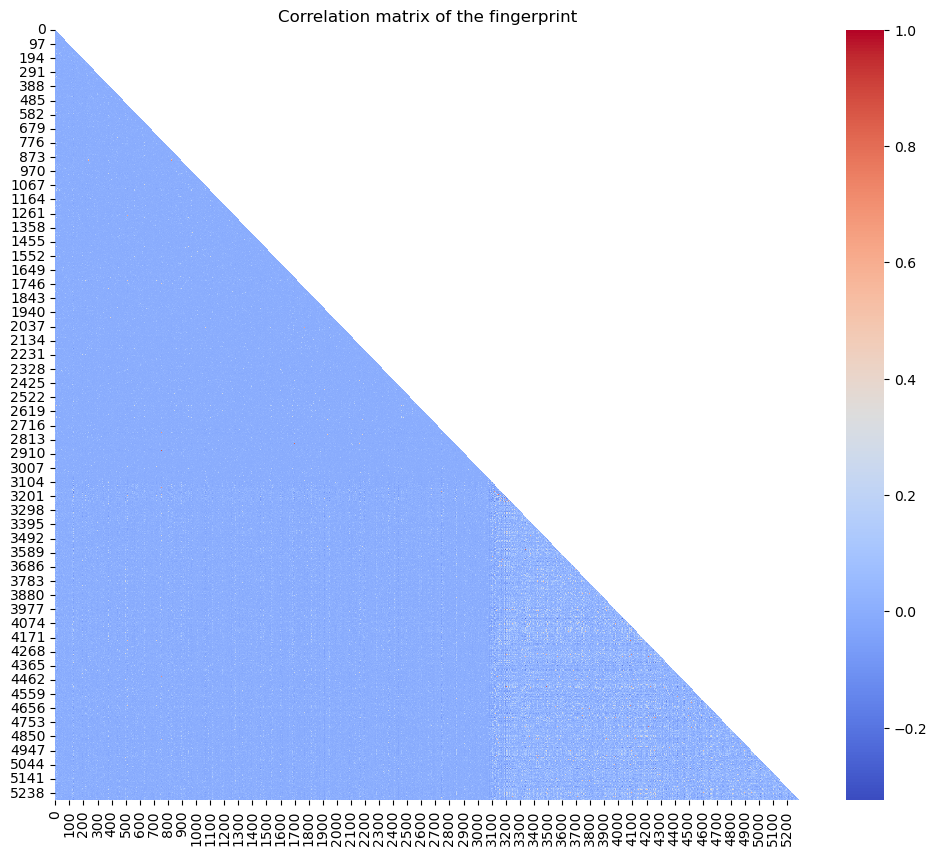

In [10]:
# Creating Correlation-Matrix and eliminating all values above 90% correlation 
corr_mat = pd.DataFrame(np.corrcoef(fingerprint_df.T))
mask = np.triu(np.ones_like(corr_mat, dtype=bool))
tri_df = corr_mat.mask(mask)

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(tri_df, annot=False, cmap='coolwarm')
plt.title("Correlation matrix of the fingerprint")
plt.show()  

In [11]:
# Drop highly correlated columns
to_drop = [x for x in tri_df.columns if any(abs(tri_df[x])>0.9)]
fingerprint_df = fingerprint_df.drop(fingerprint_df.columns[to_drop], axis = 1)

In [12]:
# Settings
EVALUATOR = Evaluator(name = "ogbg-molhiv")
PARAMETERS = [None]
np.random.seed(42)

### 4.2. Observation of the data

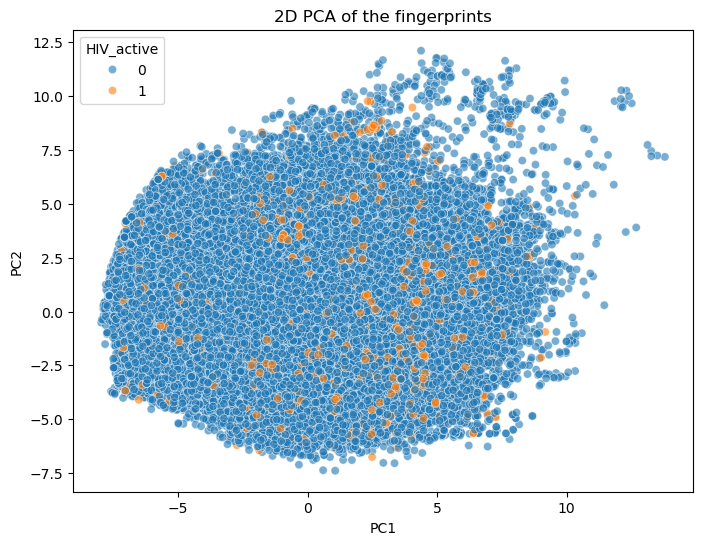

In [61]:
# Create a 2d PCA plot of the fingerprints
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(fingerprint_df.drop(columns=["HIV_active"]))
pca_df = pd.DataFrame(pca_result, columns=["PC1", "PC2"])
pca_df["HIV_active"] = fingerprint_df["HIV_active"]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="HIV_active", alpha=0.6)
plt.title("2D PCA of the fingerprints")
plt.show()

In [80]:
split_idx = dataset.get_idx_split()
train_idx = np.array(split_idx["train"])
valid_idx = np.array(split_idx["valid"])
test_idx = np.array(split_idx["test"])

X_train = fingerprint_df.iloc[train_idx, 1:]
y_train = fingerprint_df.iloc[train_idx, 0]
X_valid = fingerprint_df.iloc[valid_idx, 1:]
y_valid = fingerprint_df.iloc[valid_idx, 0]
X_test = fingerprint_df.iloc[test_idx, 1:]
y_test = fingerprint_df.iloc[test_idx, 0]

# Re-index the dataframes
X_train.index = range(len(X_train))
y_train.index = range(len(y_train))
X_valid.index = range(len(X_valid))
y_valid.index = range(len(y_valid))
X_test.index = range(len(X_test))
y_test.index = range(len(y_test))

data = {
    "train": {"X": X_train, "y": y_train},
    "valid": {"X": X_valid, "y": y_valid},
    "test": {"X": X_test, "y": y_test},
}

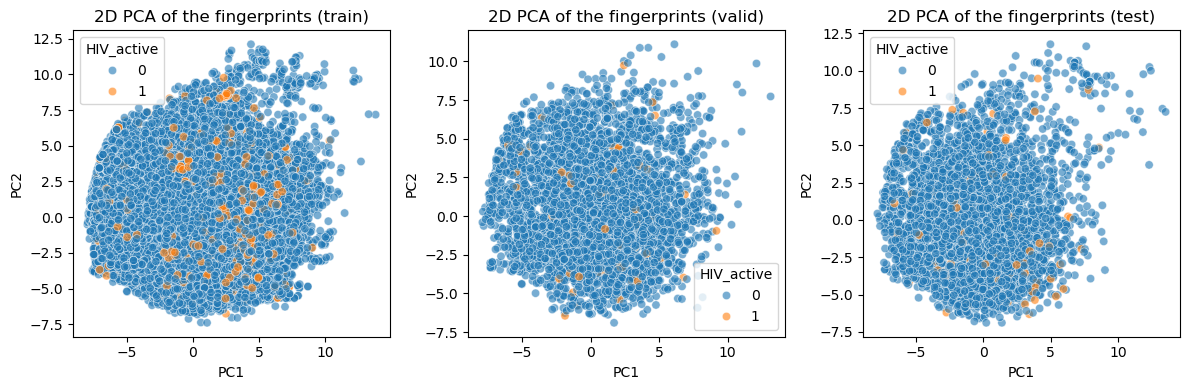

In [81]:
# Create a 2d PCA plot of the fingerprints for train, validation and test 
plt.figure(figsize=(12, 4))
for i, key in enumerate(data.keys()):
    pca_result = pca.transform(data[key]["X"])
    pca_df = pd.DataFrame(pca_result, columns=["PC1", "PC2"])
    pca_df["HIV_active"] = data[key]["y"]

    plt.subplot(1, 3, i+1)
    sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="HIV_active", alpha=0.6)
    plt.title(f"2D PCA of the fingerprints ({key})")
plt.tight_layout()    
plt.show()

### 4.3. Model evaluation 

In [79]:
split_idx = dataset.get_idx_split()
train_idx = np.array(split_idx["train"])
valid_idx = np.array(split_idx["valid"])
test_idx = np.array(split_idx["test"])

X_train = fingerprint_df.iloc[train_idx, 1:]
y_train = fingerprint_df.iloc[train_idx, 0]
X_valid = fingerprint_df.iloc[valid_idx, 1:]
y_valid = fingerprint_df.iloc[valid_idx, 0]
X_test = fingerprint_df.iloc[test_idx, 1:]
y_test = fingerprint_df.iloc[test_idx, 0]

# Re-index the dataframes
X_train.index = range(len(X_train))
y_train.index = range(len(y_train))
X_valid.index = range(len(X_valid))
y_valid.index = range(len(y_valid))
X_test.index = range(len(X_test))
y_test.index = range(len(y_test))

data = {
    "train": {"X": X_train, "y": y_train},
    "valid": {"X": X_valid, "y": y_valid},
    "test": {"X": X_test, "y": y_test},
}

In [25]:
from sklearn.metrics import roc_auc_score, roc_curve

def evaluate_model(clf, X_train, y_train, X_valid, y_valid, X_test, y_test, verbose:bool=True):
    y_train_pred = clf.predict_proba(X_train)[:, 1]
    y_valid_pred = clf.predict_proba(X_valid)[:, 1]
    y_test_pred = clf.predict_proba(X_test)[:, 1]

    train_auc = roc_auc_score(y_train, y_train_pred)
    valid_auc = roc_auc_score(y_valid, y_valid_pred)
    test_auc = roc_auc_score(y_test, y_test_pred)

    if verbose:
        print(f"Train AUC: {train_auc*100:.2f}%")
        print(f"Valid AUC: {valid_auc*100:.2f}%")
        print(f"Test AUC: {test_auc*100:.2f}%")
    
    return train_auc, valid_auc, test_auc

In [58]:
import xgboost as xgb
from xgboost import XGBClassifier

def xgb_cv(clf, data, use_train_cv=True, cv_folds=5, early_stopping_rounds=50, plot:bool=True):
    X_train, y_train = data["train"]["X"], data["train"]["y"]
    X_valid, y_valid = data["valid"]["X"], data["valid"]["y"]
    X_test, y_test = data["test"]["X"], data["test"]["y"]
    
    if use_train_cv:
        xgb_param = clf.get_xgb_params()
        dtrain = xgb.DMatrix(X_train, label=y_train)
        cvresult = xgb.cv(
            xgb_param, 
            dtrain, 
            num_boost_round=clf.get_params()['n_estimators'], 
            nfold=cv_folds,
            metrics='auc', 
            early_stopping_rounds=early_stopping_rounds
            )
        clf.set_params(
            n_estimators=cvresult.shape[0],
            eval_metric='auc'
            )
    
    # Fit the algorithm on the data
    clf.fit(X_train, y_train)
        
    # Print model report:
    _ = evaluate_model(clf, X_train, y_train, X_valid, y_valid, X_test, y_test)

    if plot: 
        feature_imp = pd.Series(clf.get_booster().get_score(importance_type='weight')).sort_values(ascending=False)[:90]
        feature_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score (Weight)')
        # Optionally, you can also increase the figure size for better readability
        plt.gcf().set_size_inches(12, 8)  # Width, Height in inches 
        # Set the features names as xticks
        feat_index = [int(f[1:]) for f in feature_imp.index]
        plt.xticks(range(len(feature_imp)), feature_names[feat_index])
        plt.show()

In [59]:
def xgb_modelfit(clf, data, folds:int=5, plot:bool=False):
    train_aucs, valid_aucs, test_aucs = [], [], []
    
    for i in range(folds):
        xgb_params = clf.get_params()
        xgb_params['random_state'] = i
        xgb_clf = XGBClassifier(**xgb_params)
        X_train, y_train = data["train"]["X"], data["train"]["y"]
        X_valid, y_valid = data["valid"]["X"], data["valid"]["y"]
        X_test, y_test = data["test"]["X"], data["test"]["y"]
        xgb_clf.fit(X_train, y_train)
        train_auc, valid_auc, test_auc = evaluate_model(xgb_clf, X_train, y_train, X_valid, y_valid, X_test, y_test, verbose=False)
        train_aucs.append(train_auc)
        valid_aucs.append(valid_auc)
        test_aucs.append(test_auc)
    
    print(f"\t-> Training AUC: {np.mean(train_aucs) * 100:.2f}% +/- {np.std(train_aucs) * 100:.2f}")
    print(f"\t-> Validation AUC: {np.mean(valid_aucs) * 100:.2f}% +/- {np.std(valid_aucs) * 100:.2f}")
    print(f"\t-> Test AUC: {np.mean(test_aucs) * 100:.2f}% +/- {np.std(test_aucs) * 100:.2f}")

    if plot: 
        # Plot the ROC-AUC curve for the train, validation, test
        fpr, tpr, _ = roc_curve(y_train, xgb_clf.predict_proba(X_train)[:, 1])
        train_auc = roc_auc_score(y_train, xgb_clf.predict_proba(X_train)[:, 1])
        plt.plot(fpr, tpr, label=f"Train AUC: {train_auc*100:.2f}%")

        fpr, tpr, _ = roc_curve(y_valid, xgb_clf.predict_proba(X_valid)[:, 1])
        valid_auc = roc_auc_score(y_valid, xgb_clf.predict_proba(X_valid)[:, 1])
        plt.plot(fpr, tpr, label=f"Valid AUC: {valid_auc*100:.2f}%")

        fpr, tpr, _ = roc_curve(y_test, xgb_clf.predict_proba(X_test)[:, 1])
        test_auc = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1])
        plt.plot(fpr, tpr, lw=2, label=f"Test AUC: {test_auc*100:.2f}%")

        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC curve')
        plt.legend(loc="lower right")
        plt.show()

In [44]:
xgb_clf = XGBClassifier(
    learning_rate = 0.1, n_estimators = 1000,
    max_depth = 10,
    min_child_weight = 3, 
    gamma = 0.5, 
    colsample_bytree = 0.8
)
xgb_cv(xgb_clf, data, plot=False)

Train AUC: 98.7967%
Valid AUC: 80.8867%
Test AUC: 78.2644%


	-> Training AUC: 99.86% +/- 0.01
	-> Validation AUC: 83.34% +/- 0.91
	-> Test AUC: 75.89% +/- 0.62


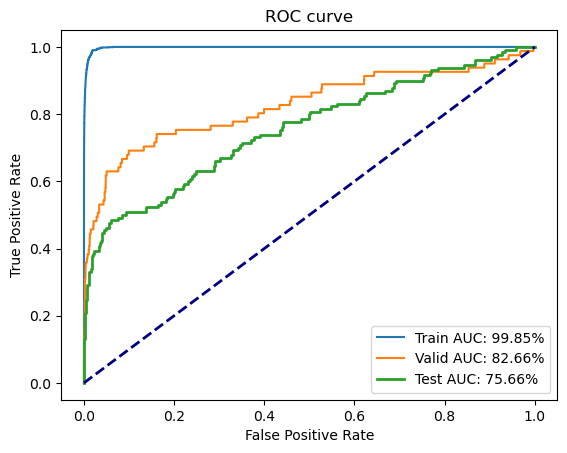

In [60]:
xgb_clf = XGBClassifier(
    learning_rate = 0.1, n_estimators = 1000,
    max_depth = 10,
    min_child_weight = 3, 
    gamma = 0.5, 
    colsample_bytree = 0.8
)
xgb_modelfit(xgb_clf, data, folds=10, plot=True)

In [188]:
from sklearn.ensemble import RandomForestClassifier


def rf_modelfit(rf, data, folds:int=5, plot:bool=False):
    train_aucs, valid_aucs, test_aucs = [], [], []
    
    for _ in range(folds):
        X_train, y_train = data["train"]["X"], data["train"]["y"]
        X_valid, y_valid = data["valid"]["X"], data["valid"]["y"]
        X_test, y_test = data["test"]["X"], data["test"]["y"]
        rf.fit(X_train, y_train)
        train_auc, valid_auc, test_auc = evaluate_model(rf, X_train, y_train, X_valid, y_valid, X_test, y_test, verbose=False)
        train_aucs.append(train_auc)
        valid_aucs.append(valid_auc)
        test_aucs.append(test_auc)
    
    print(f"\t-> Training AUC: {np.mean(train_aucs) * 100:.2f}% +/- {np.std(train_aucs) * 100:.2f}")
    print(f"\t-> Validation AUC: {np.mean(valid_aucs) * 100:.2f}% +/- {np.std(valid_aucs) * 100:.2f}")
    print(f"\t-> Test AUC: {np.mean(test_aucs) * 100:.2f}% +/- {np.std(test_aucs) * 100:.2f}")

    if plot: 
        # Plot the ROC-AUC curve for the train, validation, test
        fpr, tpr, _ = roc_curve(y_train, rf.predict_proba(X_train)[:, 1])
        train_auc = roc_auc_score(y_train, rf.predict_proba(X_train)[:, 1])
        plt.plot(fpr, tpr, label=f"Train AUC: {train_auc*100:.2f}%")

        fpr, tpr, _ = roc_curve(y_valid, rf.predict_proba(X_valid)[:, 1])
        valid_auc = roc_auc_score(y_valid, rf.predict_proba(X_valid)[:, 1])
        plt.plot(fpr, tpr, label=f"Valid AUC: {valid_auc*100:.2f}%")

        fpr, tpr, _ = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
        test_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
        plt.plot(fpr, tpr, lw=2, label=f"Test AUC: {test_auc*100:.2f}%")

        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC curve')
        plt.legend(loc="lower right")
        plt.show()


In [27]:
rf = RandomForestClassifier(
    n_estimators=500,
    criterion="entropy",
    n_jobs = 4, 
    min_samples_leaf=2,
    min_impurity_decrease=0,
    warm_start= True,
    # max_features = "auto",
    max_depth = None,
    min_samples_split=10,
)
rf_modelfit(rf, data)

	-> Training AUC: 99.61% +/- 0.00
	-> Validation AUC: 80.55% +/- 0.65
	-> Test AUC: 81.69% +/- 0.27


**NB:** The Random Forest Classifier seems to perform better than the XGBoost. Let's try to find the best hyperparameters for this model.

#### Manual exploration of the hyperparameters

I explored the space of hyperparameters of Random Forest classifier to find the better hyperparameters. Here is a table that gives an overview of my exploration: 

| Hyperparameter            | Description                                                                                                  | Space Explored                      |
|---------------------------|--------------------------------------------------------------------------------------------------------------|-------------------------------------|
| `n_estimators`            | The number of trees in the forest.                                                                           | 500, 1000                           |
| `min_samples_leaf`        | The minimum number of samples required to be at a leaf node.                                                 | 2, 5                                |
| `min_samples_split`       | The minimum number of samples required to split an internal node.                                            | 2, 5, 10                            |
| `min_impurity_decrease`   | A node will be split if this split induces a decrease of the impurity greater than or equal to this value.   | 0                                   |
| `min_weight_fraction_leaf`| The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. | 0                               |
| `class_weight`             | Weights associated with classes in the form `{class_label: weight}`.                                           | `{0: 1, 1: 26.71}`                         |
| `warm_start`               | When set to `True`, reuse the solution of the previous call to fit and add more estimators to the ensemble.    | `True`, `False`                                                  |

In [110]:
# Compute the class weights because the dataset is imbalanced
class_weight = {
    0: 1,
    1: len(y_train) / sum(y_train),
}
print(f"class_weight: {class_weight}")

class_weight: {0: 1, 1: 26.705357142857142}


	-> Training AUC: 99.24% +/- 0.00
	-> Validation AUC: 80.75% +/- 0.40
	-> Test AUC: 82.24% +/- 0.17


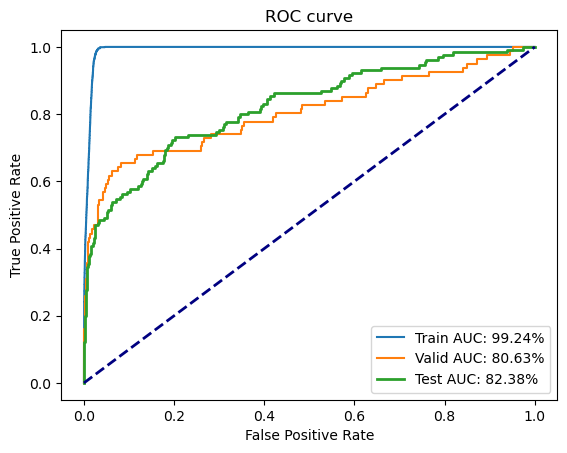

In [57]:
rf = RandomForestClassifier(
    n_estimators=1000,
    criterion="entropy",
    min_samples_leaf=5, 
    min_samples_split=5, 
    min_impurity_decrease=0,
    min_weight_fraction_leaf=0,
    n_jobs = 4,
    warm_start= True,
)
rf_modelfit(rf, data, folds=10, plot=True)

### 4.4. MLP implementation 

We can try to implement a simple MLP to see if it can do better than the Random Forest classifier.

In [24]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from ogb.graphproppred import GraphPropPredDataset

DATASET_NAME = "ogbg-molhiv"
dataset = GraphPropPredDataset(name = DATASET_NAME, root = './dataset')

In [2]:
# Load the dataset
fingerprint_df = pd.read_csv("./Datasets/HIV/hiv_fingerprints.csv")

In [3]:
def load_dataset(dataset):
    split_idx = dataset.get_idx_split()
    train_idx = np.array(split_idx["train"])
    valid_idx = np.array(split_idx["valid"])
    test_idx = np.array(split_idx["test"])

    X_train = fingerprint_df.iloc[train_idx, 1:]
    y_train = fingerprint_df.iloc[train_idx, 0]
    X_valid = fingerprint_df.iloc[valid_idx, 1:]
    y_valid = fingerprint_df.iloc[valid_idx, 0]
    X_test = fingerprint_df.iloc[test_idx, 1:]
    y_test = fingerprint_df.iloc[test_idx, 0]

    # Re-index the dataframes
    X_train.index = range(len(X_train))
    y_train.index = range(len(y_train))
    X_valid.index = range(len(X_valid))
    y_valid.index = range(len(y_valid))
    X_test.index = range(len(X_test))
    y_test.index = range(len(y_test))
    
    X_train = torch.tensor(X_train.to_numpy(), dtype=torch.float)
    y_train = torch.tensor(y_train.to_numpy(), dtype=torch.long)
    X_valid = torch.tensor(X_valid.to_numpy(), dtype=torch.float)
    y_valid = torch.tensor(y_valid.to_numpy(), dtype=torch.long)
    X_test = torch.tensor(X_test.to_numpy(), dtype=torch.float)
    y_test = torch.tensor(y_test.to_numpy(), dtype=torch.long)

    return X_train, y_train, X_valid, y_valid, X_test, y_test

In [4]:
X_train, y_train, X_valid, y_valid, X_test, y_test = load_dataset(dataset)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_valid shape: {X_valid.shape}, y_valid shape: {y_valid.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: torch.Size([32901, 5248]), y_train shape: torch.Size([32901])
X_valid shape: torch.Size([4113, 5248]), y_valid shape: torch.Size([4113])
X_test shape: torch.Size([4113, 5248]), y_test shape: torch.Size([4113])


In [5]:
class MolecularFPDataset(Dataset):
    def __init__(self, X, y):
        super().__init__() # call the constructor of the parent class
        self.X = X
        self.y = y 

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [6]:
from ogb.graphproppred import Evaluator

EVALUATOR = Evaluator(name=DATASET_NAME)
print(f"Expected Input Format: {EVALUATOR.expected_input_format}")
print(f"Expected Output Format: {EVALUATOR.expected_output_format}")
ACC_CRIT = "rocauc"

Expected Input Format: ==== Expected input format of Evaluator for ogbg-molhiv
{'y_true': y_true, 'y_pred': y_pred}
- y_true: numpy ndarray or torch tensor of shape (num_graphs, num_tasks)
- y_pred: numpy ndarray or torch tensor of shape (num_graphs, num_tasks)
where y_pred stores score values (for computing AUC score),
num_task is 1, and each row corresponds to one graph.
nan values in y_true are ignored during evaluation.

Expected Output Format: ==== Expected output format of Evaluator for ogbg-molhiv
{'rocauc': rocauc}
- rocauc (float): ROC-AUC score averaged across 1 task(s)



In [7]:
def focal_loss(inputs, targets, weight, gamma=1.0):
    """
    Compute the focal loss given inputs and targets.

    @param inputs(torch.Tensor): the input tensor
    @param targets(torch.Tensor): the target tensor
    @param weight(torch.Tensor): the weight tensor
    @param gamma(float): the gamma parameter

    @return the focal loss
    """
    probas = torch.sigmoid(inputs)
    loss = (targets * torch.pow(1 - probas, gamma) * torch.log(probas + 1e-12) +
            (1 - targets) * torch.pow(probas, gamma) * torch.log(1 - probas + 1e-12))
    loss = -loss * weight
    return torch.sum(loss)

In [8]:
from sklearn.metrics import roc_curve

import time

def timeit(f):
    def timed(*args, **kw):

        ts = time.time()
        result = f(*args, **kw)
        te = time.time()

        print(f'func:{f.__name__} took: {te-ts:.4f} sec')
        return result
    return timed

class Trainer:
    
    def __init__(
            self, 
            model, 
            learning_rate, 
            batch_size, 
            epoch, 
            l2:float=0.0, 
            gamma:float=0.0, 
            imbalance_factor:int=None, 
            device: str="cpu"
        ):
        self.model = model

        num_params = sum(item.numel() for item in model.parameters())
        print(f"{model.__class__.__name__} - Number of parameters: {num_params}")

        self.device = device
        print(f"Device: {self.device}")

        self.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2)
        self.epoch = epoch
        self.batch_size = batch_size
        self.criterion = nn.BCEWithLogitsLoss() if gamma == 0.0 else focal_loss
        self.gamma = gamma
        self.imbalance_factor = imbalance_factor
        
    @timeit
    def train(self, train_loader, valid_loader, early_stop:bool=True, draw_curve:bool=True):
        self.model.train()
        
        train_loss_list, val_loss_list = [], []  
        train_auc_list, valid_auc_list = [], []
        weights = self.model.state_dict()
        lowest_val_loss = np.inf
        loss_func = self.criterion
        for n in tqdm(range(self.epoch), leave=True):
            for X_batch, y_batch in train_loader:
                self.model.train()
                X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)
                y_pred = self.model(X_batch)
                y_true = y_batch.unsqueeze(1).float()
                
                if self.gamma == 0.0:
                    batch_loss = loss_func(y_pred, y_true)
                else:
                    # Prepare weights
                    if self.imbalance_factor: 
                        weight = torch.where(y_true == 1, self.imbalance_factor * torch.ones_like(y_true), torch.ones_like(y_true))
                    else:
                        weight = torch.ones_like(y_true)  # Assuming equal weight for all samples; modify as needed
                    batch_loss = loss_func(y_pred, y_true, weight, gamma=self.gamma)

                
                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()
            
            train_loss, train_auc, _ = self.evaluate(train_loader)
            train_loss_list.append(train_loss)
            train_auc_list.append(train_auc)
            
            val_loss, val_auc, _ = self.evaluate(valid_loader)
            val_loss_list.append(val_loss)
            valid_auc_list.append(val_auc)
            
            if early_stop:
                if val_loss < lowest_val_loss:
                    lowest_val_loss = val_loss
                    weights = self.model.state_dict()
            
        if draw_curve:
            x_axis = np.arange(self.epoch)
            fig, axes = plt.subplots(1, 2, figsize=(10, 4))
            axes[0].plot(x_axis, train_loss_list, label="Train")
            axes[0].plot(x_axis, val_loss_list, label="Validation")
            axes[0].set_title("Loss")
            axes[0].legend()
            axes[1].plot(x_axis, train_auc_list, label='Train')
            axes[1].plot(x_axis, valid_auc_list, label='Validation')
            axes[1].set_title("AUC")
            axes[1].legend()
            plt.show()
        
        if early_stop:
            self.model.load_state_dict(weights)
        
        return {
            "train_loss_list": train_loss_list,
            "train_auc_list": train_auc_list,
            "val_loss_list": val_loss_list,
            "val_auc_list": valid_auc_list,
        }
    
    def evaluate(self, loader, print_auc:str=None):
        self.model.eval() # enable evaluation mode
        loss_func = self.criterion
        auc, loss = 0.0, 0.0
        y_trues, y_preds = [], []
        for X_batch, y_batch in loader:
            with torch.no_grad():
                X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)

                y_pred = self.model(X_batch)
                y_true = y_batch.unsqueeze(1).float()
                
                if self.gamma == 0.0:
                    batch_loss = loss_func(y_pred, y_true)
                else:
                    # Prepare weights
                    if self.imbalance_factor: 
                        weight = torch.where(y_true == 1, self.imbalance_factor * torch.ones_like(y_true), torch.ones_like(y_true))
                    else:
                        weight = torch.ones_like(y_true)  # Assuming equal weight for all samples; modify as needed
                    batch_loss = loss_func(y_pred, y_true, weight, gamma=self.gamma)

                y_trues.append(y_true.detach().cpu())
                y_preds.append(y_pred.detach().cpu())
        perf_dict = {
            "y_true": np.concatenate(y_trues, axis=0), 
            "y_pred": np.concatenate(y_preds, axis=0)
        }
        batch_auc = EVALUATOR.eval(perf_dict)[ACC_CRIT]
        auc += batch_auc 
        loss += batch_loss.detach().cpu().item() 
        if print_auc:
            print(f"AUC ({print_auc}): {auc*100:.2f}%")
        return loss, auc, perf_dict
    
    def plot_results(self, train_loader, valid_loader, test_loader, verbose:bool=False):
        loader_dict = {
            "Train": train_loader,
            "Valid": valid_loader,
            "Test": test_loader
        }
        for _, (key, loader) in enumerate(loader_dict.items()):
            _, auc, perf_dict = self.evaluate(loader)
            fpr, tpr, _ = roc_curve(perf_dict["y_true"], perf_dict["y_pred"])
            plt.plot(fpr, tpr, label=f"{key} AUC: {auc*100:.2f}%")

            if verbose:
                print(f"ROC AUC: ({key}): {auc*100:.2f}%")
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC curve')
        plt.legend(loc="lower right")
        plt.show()

In [9]:
BATCH_SIZE = 128

train_dataset = MolecularFPDataset(X_train, y_train)
valid_dataset = MolecularFPDataset(X_valid, y_valid)
test_dataset = MolecularFPDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

The MLP architecture is very simple:

In [10]:
class MLP(nn.Module):
    def __init__(self, dropout:float=0.0):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(5248, 12),
            nn.Dropout(p=dropout),
            nn.Sigmoid(),
            nn.Linear(12, 12),
            nn.Dropout(p=dropout),
            nn.Sigmoid(),
            nn.Linear(12, 1),
        )
    
    def forward(self, x):
        return self.layers(x)

In [11]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"device: {device}")

device: mps


MLP - Number of parameters: 63157
Device: mps


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [01:03<00:00,  6.37s/it]


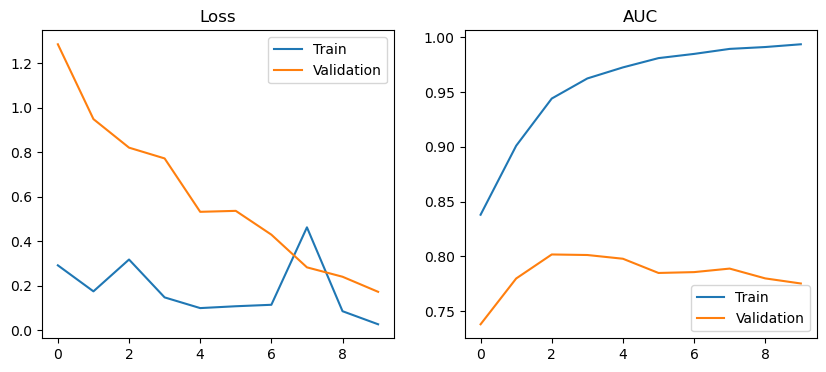

func:train took: 63.9633 sec
AUC (Test): 73.23%
ROC AUC: (Train): 99.35%
ROC AUC: (Valid): 77.51%
ROC AUC: (Test): 73.23%


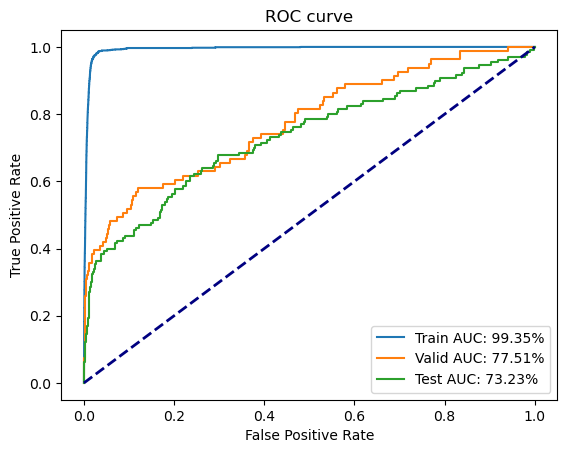

In [12]:
model = MLP(dropout=0.0)
model.to(device)

# Define the trainer
trainer = Trainer(
    model, 
    batch_size=BATCH_SIZE, 
    learning_rate=1e-3, 
    epoch=10, l2=1e-5, 
    gamma=2.0, imbalance_factor=10,
    device=device)

# Train the model
_ = trainer.train(train_loader, valid_loader)

# Evaluate the model
_ = trainer.evaluate(test_loader, print_auc="Test")
trainer.plot_results(train_loader, valid_loader, test_loader, verbose=True)

#### PCA 

We can also try to perform a PCA to reduce the dimensions and see if it improves the model.

In [14]:
# PCA 
from sklearn.decomposition import PCA


def load_dataset_pca(dataset, n_components:float=0.99):
    split_idx = dataset.get_idx_split()
    train_idx = np.array(split_idx["train"])
    valid_idx = np.array(split_idx["valid"])
    test_idx = np.array(split_idx["test"])

    X_train = fingerprint_df.iloc[train_idx, 1:]
    y_train = fingerprint_df.iloc[train_idx, 0]
    X_valid = fingerprint_df.iloc[valid_idx, 1:]
    y_valid = fingerprint_df.iloc[valid_idx, 0]
    X_test = fingerprint_df.iloc[test_idx, 1:]
    y_test = fingerprint_df.iloc[test_idx, 0]

    # Re-index the dataframes
    X_train.index = range(len(X_train))
    y_train.index = range(len(y_train))
    X_valid.index = range(len(X_valid))
    y_valid.index = range(len(y_valid))
    X_test.index = range(len(X_test))
    y_test.index = range(len(y_test))

    # Apply PCA
    pca = PCA(n_components=n_components)
    X_train = pca.fit_transform(X_train.to_numpy())
    X_valid = pca.transform(X_valid.to_numpy())
    X_test = pca.transform(X_test.to_numpy())

    # Normalize 
    X_train = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0)
    X_valid = (X_valid - X_valid.mean(axis=0)) / X_valid.std(axis=0)
    X_test = (X_test - X_test.mean(axis=0)) / X_test.std(axis=0)
    
    X_train = torch.tensor(X_train, dtype=torch.float)
    y_train = torch.tensor(y_train.to_numpy(), dtype=torch.long)
    X_valid = torch.tensor(X_valid, dtype=torch.float)
    y_valid = torch.tensor(y_valid.to_numpy(), dtype=torch.long)
    X_test = torch.tensor(X_test, dtype=torch.float)
    y_test = torch.tensor(y_test.to_numpy(), dtype=torch.long)

    return X_train, y_train, X_valid, y_valid, X_test, y_test

In [18]:
X_train_pca, y_train, X_valid_pca, y_valid, X_test_pca, y_test = load_dataset_pca(dataset, n_components=0.99)

print(f"X_train_pca.shape: {X_train_pca.shape}")
print(f"X_valid_pca.shape: {X_valid_pca.shape}")
print(f"X_test_pca.shape: {X_test_pca.shape}")

train_dataset_pca = MolecularFPDataset(X_train_pca, y_train)
valid_dataset_pca = MolecularFPDataset(X_valid_pca, y_valid)
test_dataset_pca = MolecularFPDataset(X_test_pca, y_test)

train_loader_pca = DataLoader(train_dataset_pca, batch_size=BATCH_SIZE, shuffle=True)
valid_loader_pca = DataLoader(valid_dataset_pca, batch_size=BATCH_SIZE, shuffle=False)
test_loader_pca = DataLoader(test_dataset_pca, batch_size=BATCH_SIZE, shuffle=False)

X_train_pca.shape: torch.Size([32901, 4147])
X_valid_pca.shape: torch.Size([4113, 4147])
X_test_pca.shape: torch.Size([4113, 4147])


In [19]:
class MLPPCA(nn.Module):
    def __init__(self, in_channels:int, dropout:float=0.0):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_channels, 12),
            nn.Dropout(p=dropout),
            nn.Sigmoid(),
            nn.Linear(12, 12),
            nn.Dropout(p=dropout),
            nn.Sigmoid(),
            nn.Linear(12, 1),
        )
    
    def forward(self, x):
        return self.layers(x)

MLPPCA - Number of parameters: 49945
Device: mps


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:42<00:00,  4.25s/it]


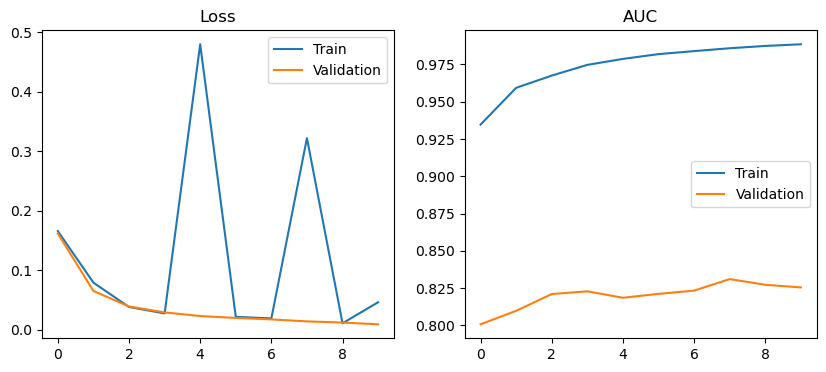

func:train took: 42.6997 sec
AUC (Test): 78.23%
ROC AUC: (Train): 98.85%
ROC AUC: (Valid): 82.55%
ROC AUC: (Test): 78.23%


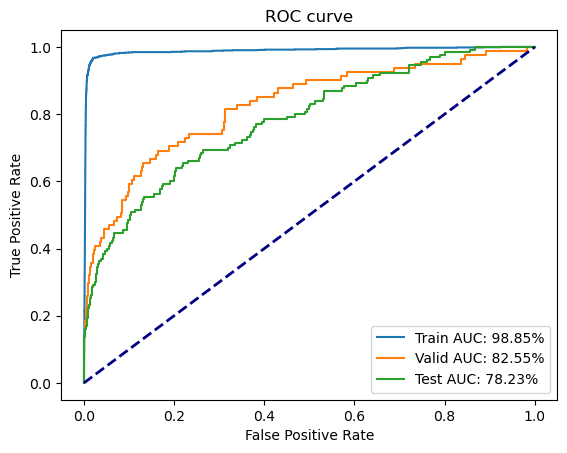

In [20]:
pca_model = MLPPCA(in_channels=X_train_pca.size()[1])
pca_model.to(device)

# Define the trainer
pca_trainer = Trainer(pca_model, batch_size=BATCH_SIZE, learning_rate=1e-3, epoch=10, l2=1e-5, device=device)

# Train the model
_ = pca_trainer.train(train_loader_pca, valid_loader_pca)

# Evaluate the model
_ = pca_trainer.evaluate(test_loader_pca, print_auc="Test")
pca_trainer.plot_results(train_loader_pca, valid_loader_pca, test_loader_pca, verbose=True)

**NB:** The PCA seem to improve the result.

#### Manual hyperparameters exploration

The exploration of the hyperparameters space was the following: 

| Hyperparameter       | Description                                                                                  | Space Explored                      |
|----------------------|----------------------------------------------------------------------------------------------|-------------------------------------|
| `dropout`            | The dropout rate for regularization during training.                                          | {0, 0.1, 0.5}                           |
| `l2` (weight decay)  | The L2 regularization factor.                                                                 | {0, 1e-3, 1e-5}                          |
| `gamma`              | Regularization term on the aggregation step (not standard in GCN, might be a custom addition).| {0, 0.5, 1, 2}                           |
| `imbalance_factor`   | Factor to adjust for class imbalance in the dataset.                                          | {0, 0.5, 1, 10}                          |

In [32]:
def evaluate_MLP(
        train_loader, valid_loader, test_loader, 
        in_channels:int=None, 
        n:int=5, 
        learning_rate:float=1e-3,
        epoch:int=10,
        l2:float=1e-5,
        gamma:float=None, imbalance_factor:int=1,
        device:str="cpu", plot:bool=True):
    train_loss_list, train_auc_list = [], []
    valid_loss_list, valid_auc_list = [], []
    train_aucs, valid_aucs, test_aucs = [], [], []
    results = pd.DataFrame()
    for _ in range(n):
        if not in_channels:
            model = MLP()
        else:
            model = MLPPCA(in_channels=in_channels)
        model.to(device)

        if not gamma:
            trainer = Trainer(
            model, 
            batch_size=BATCH_SIZE, 
            learning_rate=learning_rate, 
            epoch=epoch, l2=1e-5, 
            device=device) 
        else:
            trainer = Trainer(
                model, 
                batch_size=BATCH_SIZE, 
                learning_rate=learning_rate, 
                epoch=epoch, l2=l2, 
                gamma=gamma, imbalance_factor=imbalance_factor,
                device=device)

        dic = trainer.train(train_loader, valid_loader, early_stop=False, draw_curve=False)
        train_loss_list.append(dic["train_loss_list"])
        train_auc_list.append(dic["train_auc_list"])
        valid_loss_list.append(dic["val_loss_list"])
        valid_auc_list.append(dic["val_auc_list"])

        _, train_auc, _ = trainer.evaluate(train_loader)
        train_aucs.append(train_auc)
        _, valid_auc, _ = trainer.evaluate(valid_loader)
        valid_aucs.append(valid_auc)
        _, test_auc, _ = trainer.evaluate(test_loader)
        test_aucs.append(test_auc)

        for label, loss, auc in [
            ('Train', dic["train_loss_list"], dic["train_auc_list"]), 
            ('Valid', dic["val_loss_list"], dic["val_auc_list"]), 
            ]:
            try_results = pd.DataFrame({
                "epoch": np.arange(10),
                "loss": loss,
                "auc": auc,
                "dataset": [label] * 10
            })
            results = pd.concat([results, try_results])

    print(f"\t-> Training AUC: {np.mean(train_aucs) * 100:.2f}% +/- {np.std(train_aucs) * 100:.2f}")
    print(f"\t-> Validation AUC: {np.mean(valid_aucs) * 100:.2f}% +/- {np.std(valid_aucs) * 100:.2f}")
    print(f"\t-> Test AUC: {np.mean(test_aucs) * 100:.2f}% +/- {np.std(test_aucs) * 100:.2f}")    

    if plot: 
        # Plot the results with seaborn lineplot, using transparency to show the variance along the different trials
        sns.set_theme()
        plt.figure(figsize=(10, 6))
        sns.lineplot(data=results, x="epoch", y="auc", hue="dataset", alpha=0.5)
        plt.title("AUC over epochs")
        plt.show()

MLPPCA - Number of parameters: 49945
Device: mps


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:45<00:00,  4.55s/it]


func:train took: 45.5424 sec
MLPPCA - Number of parameters: 49945
Device: mps


100%|██████████| 10/10 [00:41<00:00,  4.19s/it]


func:train took: 41.9030 sec
MLPPCA - Number of parameters: 49945
Device: mps


100%|██████████| 10/10 [00:42<00:00,  4.21s/it]


func:train took: 42.1032 sec
MLPPCA - Number of parameters: 49945
Device: mps


100%|██████████| 10/10 [00:42<00:00,  4.25s/it]


func:train took: 42.5439 sec
MLPPCA - Number of parameters: 49945
Device: mps


100%|██████████| 10/10 [00:40<00:00,  4.08s/it]


func:train took: 40.8413 sec
	-> Training AUC: 99.24% +/- 0.19
	-> Validation AUC: 82.34% +/- 0.43
	-> Test AUC: 76.73% +/- 1.13


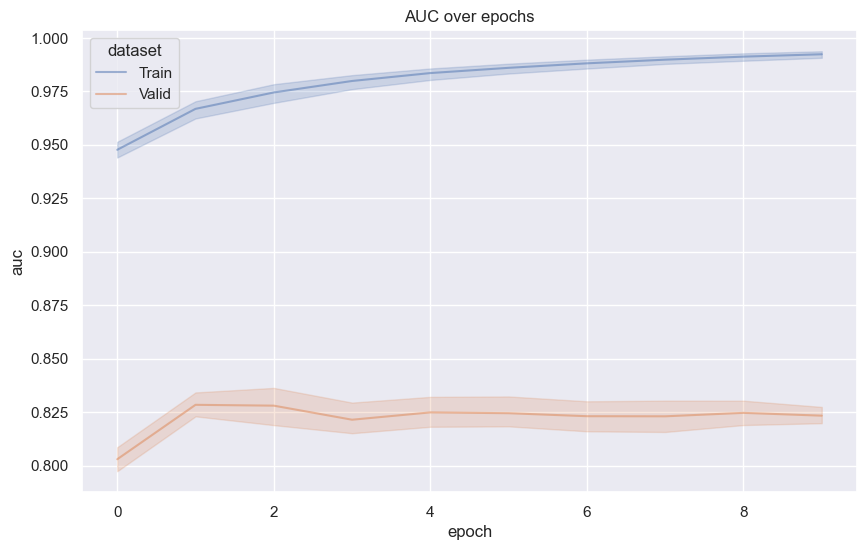

In [30]:
evaluate_MLP(train_loader_pca, valid_loader_pca, test_loader_pca, in_channels=X_train_pca.size()[1], n=5, device=device, plot=True)

MLPPCA - Number of parameters: 49945
Device: mps


100%|██████████| 10/10 [00:51<00:00,  5.15s/it]


func:train took: 51.5143 sec
MLPPCA - Number of parameters: 49945
Device: mps


100%|██████████| 10/10 [00:57<00:00,  5.77s/it]


func:train took: 57.7341 sec
MLPPCA - Number of parameters: 49945
Device: mps


100%|██████████| 10/10 [00:48<00:00,  4.83s/it]


func:train took: 48.3511 sec
MLPPCA - Number of parameters: 49945
Device: mps


100%|██████████| 10/10 [00:48<00:00,  4.83s/it]


func:train took: 48.2959 sec
MLPPCA - Number of parameters: 49945
Device: mps


100%|██████████| 10/10 [00:46<00:00,  4.61s/it]


func:train took: 46.0908 sec
	-> Training AUC: 99.72% +/- 0.04
	-> Validation AUC: 80.75% +/- 0.99
	-> Test AUC: 76.10% +/- 0.64


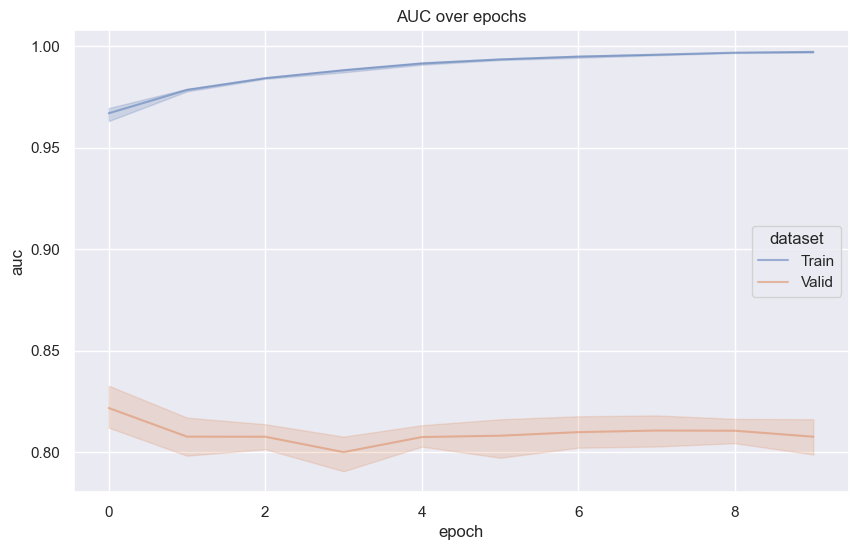

In [33]:
evaluate_MLP(train_loader_pca, valid_loader_pca, test_loader_pca, in_channels=X_train_pca.size()[1], n=5, gamma=2.0, imbalance_factor=10, device=device, plot=True)

**Conclusion:** The Random Forest classifier stays the best option on fingerprints.

## 5. Graph Neural Network

The HIV dataset we are working on contains only the SMILES for each molecule and does not explicitly give the Graph representation of each molecule. We will choose the same dataset taken from the [Open Graph Benchmark](https://ogb.stanford.edu/) (a repository of datasets where people can submit their performance on several kinds of tasks). The [MolHIV](https://ogb.stanford.edu/docs/graphprop/#ogbg-mol) is already implemented in a graph format, using [this repository](https://github.com/snap-stanford/ogb/blob/master/ogb/utils/mol.py) to transform SMILES into graphs.

In [2]:
# Download Dataset
from ogb.graphproppred import PygGraphPropPredDataset

DATASET_NAME = "ogbg-molhiv"
DATASET_ROOT = "./Datasets"
dataset = PygGraphPropPredDataset(name=DATASET_NAME, root=DATASET_ROOT)

In [3]:
ogb_molhiv_df = pd.read_csv(f"{DATASET_ROOT}/ogbg_molhiv/mapping/mol.csv.gz")
ogb_molhiv_df.head()

HIV_active                                             smiles  mol_id
0           0  CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...     NaN
1           0  C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...     NaN
2           0                   CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21     NaN
3           0    Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1     NaN
4           0                             O=S(=O)(O)CCS(=O)(=O)O     NaN

The dataset has the same `HIV_active` column as the previous one but lacks the `activity` column that we can add. We will also remove the `mol_id`column which seems useless.

In [4]:
# Remove mol_id 
ogb_molhiv_df = ogb_molhiv_df.drop(columns=["mol_id"])

# Merge the OGB dataset with the HIV dataset: only the `activity` column is kept
hiv = pd.read_csv("./Datasets/HIV/HIV.csv")
hiv_ogb_df = hiv.merge(ogb_molhiv_df, on="smiles")

# Verify that all smiles were found: we do not have nan in the `activity` column and the number of rows is 41127
assert hiv_ogb_df["activity"].isna().sum() == 0, "Issue with the activity column..."
assert hiv_ogb_df.shape[0] == 41127, "Issue with the number of rows..."

Now let's check the graph structure for one example.

In [5]:
import io
import random

from torch_geometric.utils import to_networkx
from rdkit.Chem import MolFromSmiles
from rdkit.Chem.Draw import MolToImage, MolDraw2DCairo
import networkx as nx
from PIL import Image

def smiles_to_image(smiles):
    """
        Convert a SMILES string to a picture of the molecule

        @param smiles(str): the SMILES descriptor of the molecule

        @return the bytes for the pictures of the molecule given in the SMILES
    """
    return MolToImage(MolFromSmiles(smiles), size=(300,300))

def compare_mol_graph(smiles, nx_graph, picture_height=5, picture_width=5):
    """ 
        Put side to side a molecule and the graph

        @param smiles(str): the SMILES descriptor of the molecule
        @param nx_graph(nx.Graph): the graph in networkx format
        @param picture_height(float): the height of one picture
        @param picture_width(float): the width of one picture
    """
    # Get position of the atom in the drawing
    mol = MolFromSmiles(smiles)
    draw = MolDraw2DCairo(300, 300)
    draw.DrawMolecule(mol)
    draw.FinishDrawing()
    coords = [[draw.GetDrawCoords(i).x, draw.GetDrawCoords(i).y] for i in range(mol.GetNumAtoms())] 
    
    # Save the graph to a picture
    fig = plt.figure(figsize=(picture_width, picture_height))
    graph_io = io.BytesIO()
    nx.draw(nx_graph, pos=coords)
    fig.savefig(graph_io, format="png")
    graph_pic = Image.open(graph_io)
    plt.close()
    
    # Then put both images side to side
    fig = plt.figure(figsize=(2*picture_width, picture_height))
    fig.add_subplot(1, 2, 1)
    plt.imshow(graph_pic)
    plt.axis('off')
    fig.add_subplot(1, 2, 2)
    plt.imshow(smiles_to_image(smiles))
    plt.axis('off')
    fig.suptitle(f"Molecule {smiles} and its graph", fontsize=16)
 

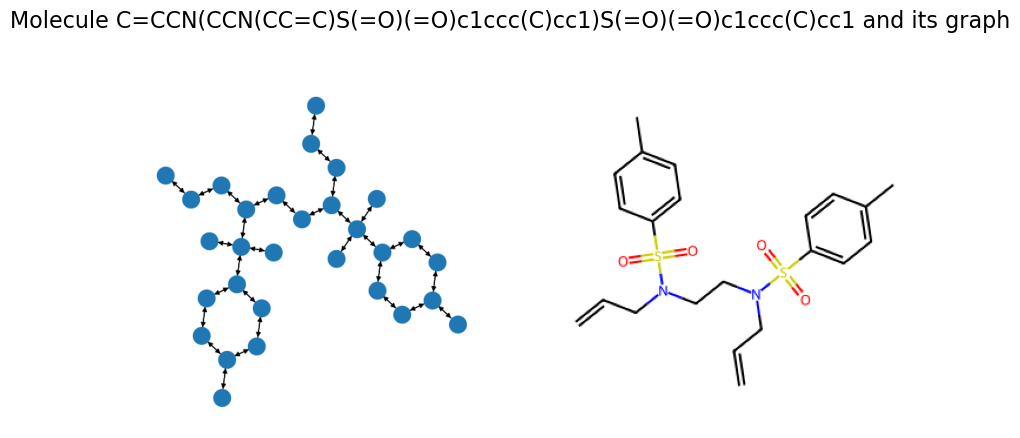

In [7]:
sample_num = random.randint(0, len(dataset))
sample_smiles = hiv_ogb_df["smiles"][sample_num]
sample_graph = to_networkx(dataset[sample_num])
compare_mol_graph(sample_smiles, sample_graph)

### Descriptors for the nodes and the edges

For the nodes and the edges of the graphs, a description of each feature is provided in the [source code](https://github.com/snap-stanford/ogb/blob/master/ogb/utils/features.py).

For atoms (nodes), we have the following 9 features:
- atomic number,
- chirality,
- degree,
- formal electric charge,
- number of hydrogen atoms connected,
- number of radical electrons,
- hybridization state,
- part of ring,
- aromaticity.

For bonds (edges), we have the following 3 features:
- bond multiplicity,
- stereoisomery info,
- conjugation.

Let's verify the dimensions of `data.x`, `data.edge_attr` and `data.edge_index`:

In [8]:
from torch_geometric.loader import DataLoader as GraphDataLoader

dataloader = GraphDataLoader(dataset, batch_size=1)
for data in dataloader:
    print(data)
    break

DataBatch(edge_index=[2, 40], edge_attr=[40, 3], x=[19, 9], y=[1, 1], num_nodes=19, batch=[19], ptr=[2])


### Train, validation and test sets

[OpenGraph Benchmark](https://ogb.stanford.edu/docs/graphprop/#ogbg-mol) defines the train, validation and test datasets. Besides, as advised on the [MoleculeNet website](https://moleculenet.org/datasets-1), they adopt a scaffold splitting procedure that splits the molecules based on their two-dimensional structural frameworks. This can be performed using the `get_idx_split()` method on the dataset.

In [9]:
# Split dataset
from torch_geometric.loader import DataLoader

BATCH_SIZE = 128

split_idx = dataset.get_idx_split()
train_loader = DataLoader(dataset[split_idx["train"]], batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(dataset[split_idx["valid"]], batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset[split_idx["test"]], batch_size=BATCH_SIZE, shuffle=False)

print(f"Dataset size: batch size({BATCH_SIZE})")
print(f"  - train: {len(split_idx['train'])} (#batches {len(train_loader)})")
print(f"  - validation: {len(split_idx['valid'])} (#batches {len(valid_loader)})")  
print(f"  - test: {len(split_idx['test'])} (#batches {len(test_loader)})")

Dataset size: batch size(128)
  - train: 32901 (#batches 258)
  - validation: 4113 (#batches 33)
  - test: 4113 (#batches 33)


### Evaluation of the performance

The MoleculeNet website mentions the ROC-AUC score as a performance metric for this dataset.

In [10]:
from ogb.graphproppred import Evaluator

EVALUATOR = Evaluator(name=DATASET_NAME)
print(f"Expected Input Format: {EVALUATOR.expected_input_format}")
print(f"Expected Output Format: {EVALUATOR.expected_output_format}")
ACC_CRIT = "rocauc"

Expected Input Format: ==== Expected input format of Evaluator for ogbg-molhiv
{'y_true': y_true, 'y_pred': y_pred}
- y_true: numpy ndarray or torch tensor of shape (num_graphs, num_tasks)
- y_pred: numpy ndarray or torch tensor of shape (num_graphs, num_tasks)
where y_pred stores score values (for computing AUC score),
num_task is 1, and each row corresponds to one graph.
nan values in y_true are ignored during evaluation.

Expected Output Format: ==== Expected output format of Evaluator for ogbg-molhiv
{'rocauc': rocauc}
- rocauc (float): ROC-AUC score averaged across 1 task(s)



### Focal Loss: Handle the imbalanced dataset

This [paper](https://arxiv.org/pdf/1709.03741v2.pdf) from Li et al. presents a focal loss that can be tuned to handle the imbalance dataset we face.

In [11]:
def focal_loss(inputs, targets, weight, gamma=1.0):
    """
    Compute the focal loss given inputs and targets.

    @param inputs(torch.Tensor): the input tensor
    @param targets(torch.Tensor): the target tensor
    @param weight(torch.Tensor): the weight tensor
    @param gamma(float): the gamma parameter

    @return the focal loss
    """
    probas = torch.sigmoid(inputs)
    loss = (targets * torch.pow(1 - probas, gamma) * torch.log(probas + 1e-12) +
            (1 - targets) * torch.pow(probas, gamma) * torch.log(1 - probas + 1e-12))
    loss = -loss * weight
    return torch.sum(loss)

### Trainer

In [12]:
import time

def timeit(f):
    """
    Time the execution of a function
    @param f: the function to time
    """

    def timed(*args, **kw):

        ts = time.time()
        result = f(*args, **kw)
        te = time.time()

        print(f'func: {f.__name__} took: {te-ts:.4f} sec')
        return result

    return timed

def print_perf_curves(learning_curves):
    """
        Print the performance for training, validation, test
        @param learning_curves(dict): dictionary hold the performance curves
    """
    
    plt.figure(figsize=(12, 6))
    for key, value in learning_curves.items():
        plt.plot(value, label=f"{key}")
        
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Performance curves")
    
    plt.legend()
    plt.show()

In [13]:
from sklearn.metrics import roc_curve


class GCNTrainer:
    """
    Trainer for the GCN model
    """
    def __init__(self, model, batch_size, learning_rate, epoch, l2=0.0, device: str="cpu"):
        self.model = model
        
        num_params = sum(item.numel() for item in model.parameters())
        print(f"{model.__class__.__name__} - Number of parameters: {num_params}")
        
        self.device = device
        print(f"Device: {self.device}")

        self.batch_size = batch_size
        self.optimizer = torch.optim.Adam(model.parameters(), learning_rate, weight_decay=l2)
        self.epoch = epoch
    
    @timeit
    def train(self, train_loader, valid_loader, gamma:float = 0.0, imbalance_factor: int = None, draw_curve:bool=True):
        self.model.train()

        train_evals, valid_evals = [], []
        loss_func = nn.BCEWithLogitsLoss() if gamma == 0.0 else focal_loss
        batch_loss_list = []
        for i in range(self.epoch):
            print(f"Epoch: {i}/{self.epoch}")
            for batch_data in train_loader:
                self.model.train()
                batch_data = batch_data.to(self.device) # Move the data to the device
                batch_pred = self.model(batch_data.x, batch_data.edge_attr, batch_data.edge_index, batch_data.batch)
                targets = batch_data.y.to(torch.float)

                if gamma == 0.0:
                    batch_loss = loss_func(batch_pred, targets)
                else:
                    # Prepare weights
                    if imbalance_factor: 
                        weight = torch.where(targets == 1, imbalance_factor * torch.ones_like(targets), torch.ones_like(targets))
                    else:
                        weight = torch.ones_like(targets)  # Assuming equal weight for all samples; modify as needed

                    batch_loss = loss_func(batch_pred, targets, weight, gamma=gamma)

                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()

                batch_loss_list.append(batch_loss.detach().numpy())
            
            # Evaluate the model
            train_evals.append(self.evaluate(train_loader, draw_curve=False))
            valid_evals.append(self.evaluate(valid_loader, draw_curve=False))

        
        if draw_curve:
            _, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
            ax.set_yscale("log")
            ax.plot(np.arange(len(batch_loss_list)), batch_loss_list)
            ax.set_xlabel("# Batch")
            ax.set_ylabel("Loss")

            print_perf_curves({
                "Train": train_evals,
                "Validation": valid_evals
            })
        
        return batch_loss_list
    
    def evaluate(self, loader, draw_curve=True, plot:bool=False):
        self.model.eval()

        y_true, y_pred = [], []
        with torch.no_grad():
            for batch_data in loader:
                batch_data = batch_data.to(self.device) # Move the data to the device
                batch_pred = self.model(batch_data.x, batch_data.edge_attr, batch_data.edge_index, batch_data.batch)
                y_true.append(batch_data.y.view(batch_pred.shape).detach().cpu())
                y_pred.append(batch_pred.detach().cpu())
            
        
        perf_dict = {
            "y_true": np.concatenate(y_true, axis=0), 
            "y_pred": np.concatenate(y_pred, axis=0)
        }
        eval = EVALUATOR.eval(perf_dict)[ACC_CRIT]
        
        if draw_curve:
            # Plot the ROC curve
            fpr, tpr, _ = roc_curve(perf_dict["y_true"], perf_dict["y_pred"])
            plt.figure(figsize=(6, 6))
            plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC AUC = {eval:.2f}")
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('ROC curve')
            plt.legend(loc="lower right")
            plt.show()
            
        if plot:
            return eval, perf_dict 
        else:
            return eval
    
    def plot_results(self, train_loader, valid_loader, test_loader, verbose:bool=False):
        loader_dict = {
            "Train": train_loader,
            "Valid": valid_loader,
            "Test": test_loader
        }
        for _, (key, loader) in enumerate(loader_dict.items()):
            eval, perf_dict = self.evaluate(loader, draw_curve=False, plot=True)
            fpr, tpr, _ = roc_curve(perf_dict["y_true"], perf_dict["y_pred"])
            plt.plot(fpr, tpr, label=f"{key} AUC: {eval*100:.2f}%")

            if verbose:
                print(f"ROC AUC: ({key}): {eval*100:.2f}%")
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC curve')
        plt.legend(loc="lower right")
        plt.show()

### 5.1. GNN Model 1: Graph Convolution with Message Passing

A first attempt will be to use a Graph Convolution Network (GCN). The model is taken from Weihua Hu's paper available [here](https://arxiv.org/abs/1609.02907).

In [14]:
import torch
import torch.nn as nn
from torch_geometric.nn import MessagePassing, global_add_pool, global_mean_pool, global_max_pool
from torch_geometric.utils import degree, scatter

from ogb.graphproppred.mol_encoder import AtomEncoder,BondEncoder

class GCNConv(MessagePassing):
    """
    Message passing layer for the GCN model
    """
    def __init__(self, hidden_dim, aggr="add"):
        """
        Initialize the GCNConv layer
        @param hidden_dim(int): the hidden dimension
        @param aggr(str): the aggregation method (default is "add")
        """
        super().__init__(aggr=aggr)
        
        self.aggr = aggr
        self.hidden_dim = hidden_dim

        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.root_emb = nn.Embedding(1, hidden_dim)
        self.bond_encoder = BondEncoder(emb_dim=hidden_dim)

    def forward(self, x, edge_index, edge_attr):
        """
        Forward pass of the GCNConv layer
        @param x(torch.Tensor): the input features
        @param edge_index(torch.Tensor): the edge index
        @param edge_attr(torch.Tensor): the edge attributes

        @return the output features
        """
        x = self.linear(x)
        edge_embedding = self.bond_encoder(edge_attr)

        src, dest = edge_index
    
        deg = degree(src, x.size(0), dtype=x.dtype) + 1
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[src] * deg_inv_sqrt[dest]

        return self.propagate(edge_index, x=x, edge_attr=edge_embedding, norm=norm) + self.relu(x + self.root_emb.weight)*1.0/deg.view(-1,1)


    def message(self, x_j, edge_attr, norm):
        """
        Message function
        @param x_j(torch.Tensor): the features of the neighbors
        @param edge_attr(torch.Tensor): the edge attributes
        @param norm(torch.Tensor): the normalization tensor
        """
        # Flatten the norm tensor
        return norm.view(-1, 1) * self.relu(x_j + edge_attr)

    def update(self, aggr_out):
        """
        Update function
        @param aggr_out(torch.Tensor): the aggregated features"""
        return aggr_out
    
class NormLayer(nn.Module):
    """
    Normalization layer
    """
    def __init__(self, hidden_dim:int, norm="batch"):
        """
        Initialize the normalization layer
        @param hidden_dim(int): the hidden dimension
        @param norm(str): the normalization method (default is "batch")
        """
        super().__init__()
        if norm == "batch":
            self.norm = nn.BatchNorm1d(hidden_dim)
        elif norm == "layer":
            self.norm = nn.LayerNorm(hidden_dim)
        else: 
            raise ValueError(f"Normalization method {norm} is not supported")
    
    def forward(self, x):
        """
        Forward pass of the normalization layer
        @param x(torch.Tensor): the input tensor
        """
        return self.norm(x)

class GCN(nn.Module):
    """
    Graph Convolutional Network model
    """
    def __init__(
        self, 
        hidden_dim:int=100, 
        num_layers:int=5, 
        num_classes:int=1, 
        dropout:float=0.0, 
        norm:str="batch", 
        res:bool=False, 
        graph_pooling:str="sum"
    ):
        """
        Initialize the GCN model
        @param hidden_dim(int): the hidden dimension
        @param num_layers(int): the number of convolutional layers
        @param num_classes(int): the number of classes
        @param dropout(float): the dropout rate
        @param norm(str): the normalization method
        @param res(bool): whether to use residual connections
        """
        super().__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.num_classes = num_classes
        self.res = res 

        self.atom_encoder = AtomEncoder(emb_dim=hidden_dim)
        self.convs = nn.ModuleList([GCNConv(hidden_dim) for _ in range(num_layers)])
        self.norms = nn.ModuleList([NormLayer(hidden_dim, norm) for _ in range(num_layers)])
        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()
        self.readout = nn.Linear(hidden_dim, num_classes)

        if graph_pooling == "sum":
            self.pool = global_add_pool
        elif graph_pooling == "mean":
            self.pool = global_mean_pool
        elif graph_pooling == "max":
            self.pool = global_max_pool
        else:
            raise Exception('Unknown Pool Type')

    def forward(self, x, edge_attr, edge_index, batch):
        """
        Forward pass of the GCN model
        @param data(torch_geometric.data.Data): the input data
        """
        h = self.atom_encoder(x)

        for i in range(self.num_layers-1):
            h_res = h
            h = self.convs[i](h, edge_index, edge_attr)
            h = self.norms[i](h)
            h = self.relu(h)
            h = self.dropout(h)
            if self.res: 
                h = h + h_res

        h = self.convs[-1](h, edge_index, edge_attr)
        h = self.norms[-1](h)
        h = self.dropout(h)

        h_graph = self.pool(h, batch)

        return self.readout(h_graph)

In [15]:
# Split dataset
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split

BATCH_SIZE = 128
split_method = "scaffold"

if split_method == "scaffold":
    split_idx = dataset.get_idx_split()
elif split_method == "random": # Random split with 80% train, 10% validation, 10% test 
    train_idx, test_idx = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)
    valid_idx, test_idx = train_test_split(test_idx, test_size=0.5, random_state=42)

    split_idx = {
        "train": train_idx,
        "valid": valid_idx,
        "test": test_idx
    }
else:
    raise ValueError("Unknown split method")
train_loader = DataLoader(dataset[split_idx["train"]], batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(dataset[split_idx["valid"]], batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset[split_idx["test"]], batch_size=BATCH_SIZE, shuffle=False)

print(f"Dataset size: batch size({BATCH_SIZE})")
print(f"  - train: {len(split_idx['train'])} (#batches {len(train_loader)})")
print(f"  - validation: {len(split_idx['valid'])} (#batches {len(valid_loader)})")  
print(f"  - test: {len(split_idx['test'])} (#batches {len(test_loader)})")

Dataset size: batch size(128)
  - train: 32901 (#batches 258)
  - validation: 4113 (#batches 33)
  - test: 4113 (#batches 33)


#### First model

In [33]:
# Define the model
model = GCN(hidden_dim=25, num_layers=2, num_classes=1)
num_params = sum(item.numel() for item in model.parameters())
print(f"{model.__class__.__name__} - Number of parameters: {num_params}")
print(model)

GCN - Number of parameters: 6476
GCN(
  (atom_encoder): AtomEncoder(
    (atom_embedding_list): ModuleList(
      (0): Embedding(119, 25)
      (1): Embedding(5, 25)
      (2-3): 2 x Embedding(12, 25)
      (4): Embedding(10, 25)
      (5-6): 2 x Embedding(6, 25)
      (7-8): 2 x Embedding(2, 25)
    )
  )
  (convs): ModuleList(
    (0-1): 2 x GCNConv()
  )
  (norms): ModuleList(
    (0-1): 2 x NormLayer(
      (norm): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (relu): ReLU()
  (readout): Linear(in_features=25, out_features=1, bias=True)
)


GCN - Number of parameters: 6476
Device: cpu
Epoch: 0/10
Epoch: 1/10
Epoch: 2/10
Epoch: 3/10
Epoch: 4/10
Epoch: 5/10
Epoch: 6/10
Epoch: 7/10
Epoch: 8/10
Epoch: 9/10


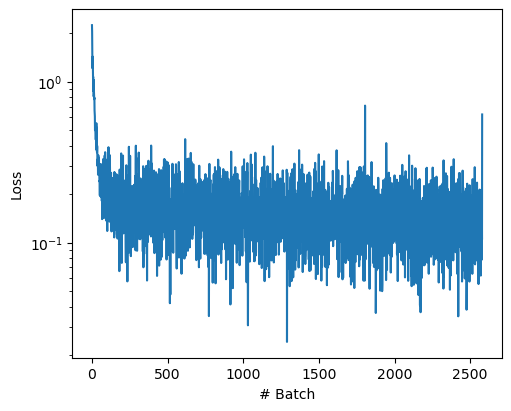

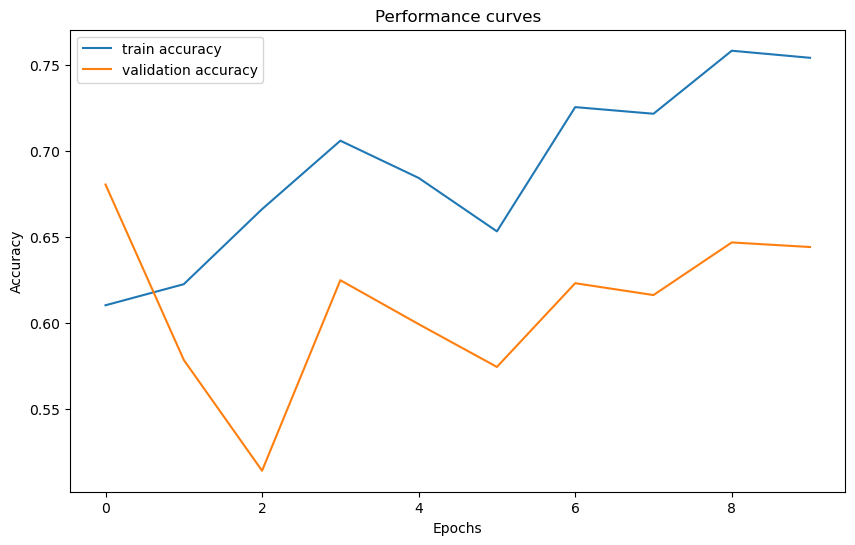

func: train took: 61.0179 sec


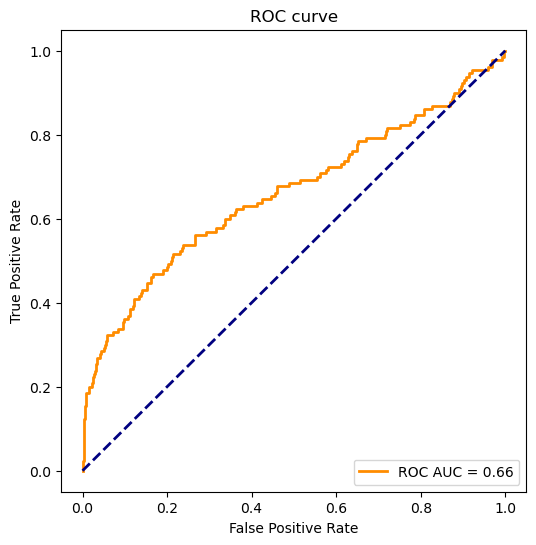

ROC AUC (Test): 66.17%


In [34]:
# Define the trainer
trainer = GCNTrainer(model, batch_size=BATCH_SIZE, learning_rate=1e-3, epoch=10)

# Train the model
learning_curves = trainer.train(train_loader, valid_loader)

# Evaluate the model
perf = trainer.evaluate(test_loader, draw_curve=True)
print(f"ROC AUC (Test): {perf*100:.2f}%")

#### L2 Regularization

Let's try to add l2 regularization:

In [18]:
trainer = GCNTrainer(model, batch_size=BATCH_SIZE, learning_rate=1e-3, epoch=10, l2=1e-3)

# Train the model
learning_curves = trainer.train(train_loader, valid_loader, draw_curve=False)

# Evaluate the model
perf = trainer.evaluate(test_loader, draw_curve=False)
print(f"ROC AUC (Test): {perf*100:.2f}%")

GCN - Number of parameters: 6476
Device: cpu
Epoch: 0/10
Epoch: 1/10
Epoch: 2/10
Epoch: 3/10
Epoch: 4/10
Epoch: 5/10
Epoch: 6/10
Epoch: 7/10
Epoch: 8/10
Epoch: 9/10
func: train took: 63.7195 sec
ROC AUC (Test): 67.78%


In [19]:
trainer = GCNTrainer(model, batch_size=BATCH_SIZE, learning_rate=1e-3, epoch=10, l2=1e-5)

# Train the model
learning_curves = trainer.train(train_loader, valid_loader, draw_curve=False)

# Evaluate the model
perf = trainer.evaluate(test_loader, draw_curve=False)
print(f"ROC AUC (Test): {perf*100:.2f}%")

GCN - Number of parameters: 6476
Device: cpu
Epoch: 0/10
Epoch: 1/10
Epoch: 2/10
Epoch: 3/10
Epoch: 4/10
Epoch: 5/10
Epoch: 6/10
Epoch: 7/10
Epoch: 8/10
Epoch: 9/10
func: train took: 64.4857 sec
ROC AUC (Test): 71.79%


#### Dropout 

Let's try to change the model and add dropout as well during the training:

In [20]:
model = GCN(hidden_dim=25, num_layers=2, num_classes=1, dropout=0.15)

In [21]:
trainer = GCNTrainer(model, batch_size=BATCH_SIZE, learning_rate=1e-3, epoch=10)

# Train the model
learning_curves = trainer.train(train_loader, valid_loader, draw_curve=False)

# Evaluate the model
perf = trainer.evaluate(test_loader, draw_curve=False)
print(f"ROC AUC (Test): {perf*100:.2f}%")

GCN - Number of parameters: 6476
Device: cpu
Epoch: 0/10
Epoch: 1/10
Epoch: 2/10
Epoch: 3/10
Epoch: 4/10
Epoch: 5/10
Epoch: 6/10
Epoch: 7/10
Epoch: 8/10
Epoch: 9/10
func: train took: 68.2067 sec
ROC AUC (Test): 61.98%


With l2 regularization:

In [22]:
trainer = GCNTrainer(model, batch_size=BATCH_SIZE, learning_rate=1e-3, epoch=10, l2=1e-5)

# Train the model
learning_curves = trainer.train(train_loader, valid_loader, draw_curve=False)

# Evaluate the model
perf = trainer.evaluate(test_loader, draw_curve=False)
print(f"ROC AUC (Test): {perf*100:.2f}%")

GCN - Number of parameters: 6476
Device: cpu
Epoch: 0/10
Epoch: 1/10
Epoch: 2/10
Epoch: 3/10
Epoch: 4/10
Epoch: 5/10
Epoch: 6/10
Epoch: 7/10
Epoch: 8/10
Epoch: 9/10
func: train took: 68.5797 sec
ROC AUC (Test): 64.44%


What if we increase the dropout?

In [23]:
model = GCN(hidden_dim=25, num_layers=2, num_classes=1, dropout=0.5)

In [24]:
trainer = GCNTrainer(model, batch_size=BATCH_SIZE, learning_rate=1e-3, epoch=10, l2=1e-5)

# Train the model
learning_curves = trainer.train(train_loader, valid_loader, draw_curve=False)

# Evaluate the model
perf = trainer.evaluate(test_loader, draw_curve=False)
print(f"ROC AUC (Test): {perf*100:.2f}%")

GCN - Number of parameters: 6476
Device: cpu
Epoch: 0/10
Epoch: 1/10
Epoch: 2/10
Epoch: 3/10
Epoch: 4/10
Epoch: 5/10
Epoch: 6/10
Epoch: 7/10
Epoch: 8/10
Epoch: 9/10
func: train took: 67.7477 sec
ROC AUC (Test): 51.50%


The dropout does not seem very efficient for such a small network. Let's try for a bigger network:

In [25]:
model = GCN(hidden_dim=100, num_layers=5, num_classes=1, dropout=0.15)

In [26]:
trainer = GCNTrainer(model, batch_size=BATCH_SIZE, learning_rate=1e-3, epoch=10)

# Train the model
learning_curves = trainer.train(train_loader, valid_loader, draw_curve=False)

# Evaluate the model
perf = trainer.evaluate(test_loader, draw_curve=False)
print(f"ROC AUC (Test): {perf*100:.2f}%")

GCN - Number of parameters: 76001
Device: cpu
Epoch: 0/10
Epoch: 1/10
Epoch: 2/10
Epoch: 3/10
Epoch: 4/10
Epoch: 5/10
Epoch: 6/10
Epoch: 7/10
Epoch: 8/10
Epoch: 9/10
func: train took: 273.1982 sec
ROC AUC (Test): 66.41%


#### Focal loss for imbalance dataset

In [27]:
model = GCN(hidden_dim=25, num_layers=2, num_classes=1, dropout=0.15)

In [28]:
trainer = GCNTrainer(model, batch_size=BATCH_SIZE, learning_rate=1e-3, epoch=10, l2=1e-5)

# Train the model
learning_curves = trainer.train(
    train_loader, valid_loader, 
    gamma=2.0, 
    draw_curve=False
)

# Evaluate the model
perf = trainer.evaluate(test_loader, draw_curve=False)
print(f"ROC AUC (Test): {perf*100:.2f}%")

GCN - Number of parameters: 6476
Device: cpu
Epoch: 0/10
Epoch: 1/10
Epoch: 2/10
Epoch: 3/10
Epoch: 4/10
Epoch: 5/10
Epoch: 6/10
Epoch: 7/10
Epoch: 8/10
Epoch: 9/10
func: train took: 69.4341 sec
ROC AUC (Test): 60.16%


In [29]:
trainer = GCNTrainer(model, batch_size=BATCH_SIZE, learning_rate=1e-3, epoch=10, l2=1e-5)

# Train the model
learning_curves = trainer.train(
    train_loader, valid_loader, 
    gamma=2.0, imbalance_factor=10,
    draw_curve=False
)

# Evaluate the model
perf = trainer.evaluate(test_loader, draw_curve=False)
print(f"ROC AUC (Test): {perf*100:.2f}%")

GCN - Number of parameters: 6476
Device: cpu
Epoch: 0/10
Epoch: 1/10
Epoch: 2/10
Epoch: 3/10
Epoch: 4/10
Epoch: 5/10
Epoch: 6/10
Epoch: 7/10
Epoch: 8/10
Epoch: 9/10
func: train took: 69.5943 sec
ROC AUC (Test): 74.32%


#### Manual exploration of the hyperparameter space

The exploration of the hyperparameters space was the following: 

| Hyperparameter       | Description                                                                                  | Space Explored                      |
|----------------------|----------------------------------------------------------------------------------------------|-------------------------------------|
| `pooling`            | The graph pooling strategy to generate a graph-level representation from node representations. | "sum", "mean", "max"                |
| `norm`               | The type of normalization layer used within the GCN.                                         | "batch", "layer"                    |
| `hidden_dim`         | The dimensionality of the hidden layers in the GCN.                                          | {10, 25, 100}                         |
| `num_layers`         | The number of GCNConv layers in the model.                                                   | {2, 3, 4, 5, 10}                      |
| `dropout`            | The dropout rate for regularization during training.                                          | {0, 0.15, 0.5}                           |
| `l2` (weight decay)  | The L2 regularization factor.                                                                 | {0, 1e-3, 1e-5}                          |
| `res` (residual)     | Whether to use residual connections between layers.                                           | `True`, `False`                         |
| `gamma`              | Regularization term on the aggregation step (not standard in GCN, might be a custom addition).| {0, 0.5, 1, 2}                           |
| `imbalance_factor`   | Factor to adjust for class imbalance in the dataset.                                          | {0, 0.5, 1, 10}                          |

In [206]:
model = GCN(hidden_dim=25, num_layers=3, num_classes=1, norm="batch", res=False, graph_pooling="max")

trainer = GCNTrainer(model, batch_size=BATCH_SIZE, learning_rate=1e-3, epoch=10, l2=1e-5)

# Train the model
learning_curves = trainer.train(
    train_loader, valid_loader, 
    gamma=0.5, imbalance_factor=10,
    draw_curve=False
)

# Evaluate the model
train_perf = trainer.evaluate(train_loader, draw_curve=False)
test_perf = trainer.evaluate(test_loader, draw_curve=False)
print(f"ROC AUC (Train): {train_perf*100:.2f}%")
print(f"ROC AUC (Test): {test_perf*100:.2f}%")

GCN - Number of parameters: 7526
Device: cpu
Epoch: 0/10
Epoch: 1/10
Epoch: 2/10
Epoch: 3/10
Epoch: 4/10
Epoch: 5/10
Epoch: 6/10
Epoch: 7/10
Epoch: 8/10
Epoch: 9/10
func: train took: 68.3740 sec
ROC AUC (Train): 84.84%
ROC AUC (Test): 76.26%


GCN - Number of parameters: 7526
Device: cpu
Epoch: 0/10
Epoch: 1/10
Epoch: 2/10
Epoch: 3/10
Epoch: 4/10
Epoch: 5/10
Epoch: 6/10
Epoch: 7/10
Epoch: 8/10
Epoch: 9/10
func: train took: 71.7489 sec
ROC AUC (Train): 85.22%
ROC AUC (Validation): 76.58%
ROC AUC (Test): 74.81%


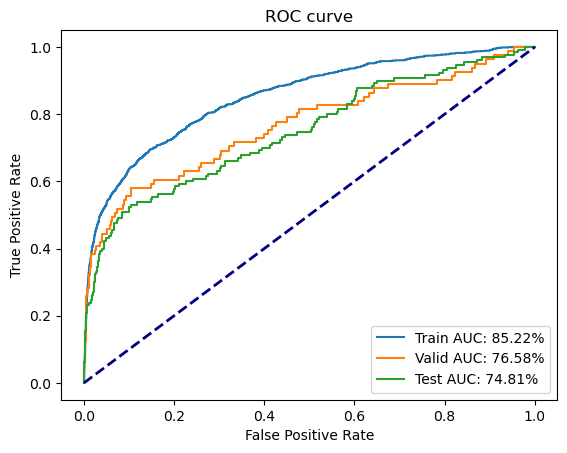

In [235]:
model = GCN(hidden_dim=25, num_layers=3, num_classes=1, norm="batch", res=False, graph_pooling="max")

trainer = GCNTrainer(model, batch_size=BATCH_SIZE, learning_rate=1e-3, epoch=10, l2=1e-5)

# Train the model
learning_curves = trainer.train(
    train_loader, valid_loader, 
    gamma=0.5, imbalance_factor=10,
    draw_curve=False
)

# Evaluate the model
train_perf = trainer.evaluate(train_loader, draw_curve=False)
valid_perf = trainer.evaluate(valid_loader, draw_curve=False)
test_perf = trainer.evaluate(test_loader, draw_curve=False)
print(f"ROC AUC (Train): {train_perf*100:.2f}%")
print(f"ROC AUC (Validation): {valid_perf*100:.2f}%")
print(f"ROC AUC (Test): {test_perf*100:.2f}%")
trainer.plot_results(train_loader, valid_loader, test_loader)

GCN - Number of parameters: 7526
Device: cpu
Epoch: 0/10
Epoch: 1/10
Epoch: 2/10
Epoch: 3/10
Epoch: 4/10
Epoch: 5/10
Epoch: 6/10
Epoch: 7/10
Epoch: 8/10
Epoch: 9/10


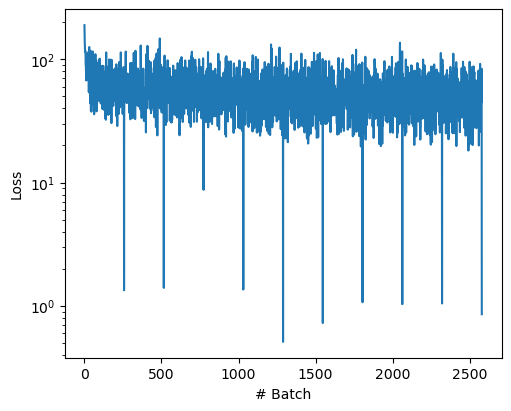

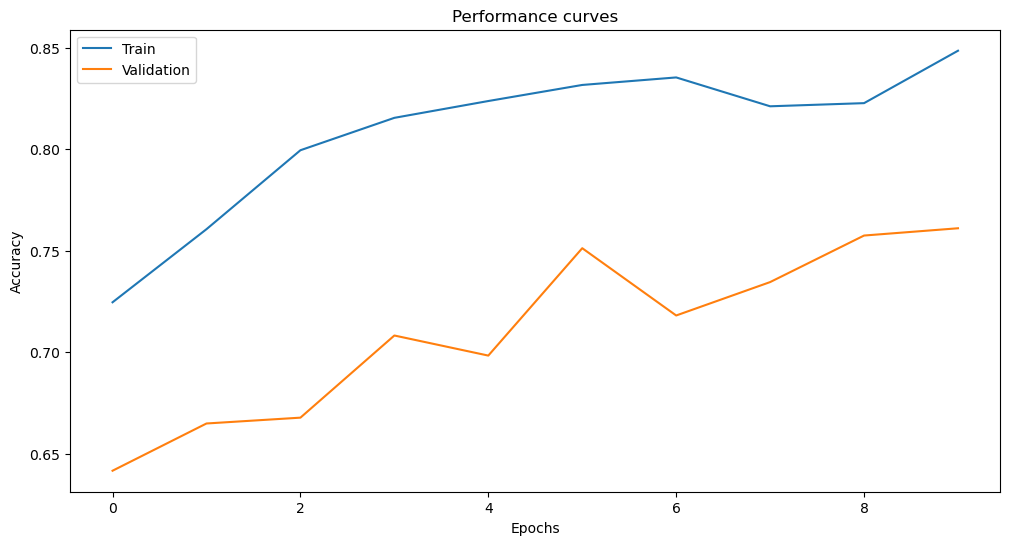

func: train took: 68.1596 sec
ROC AUC: (Train): 84.86%
ROC AUC: (Valid): 76.11%
ROC AUC: (Test): 74.00%


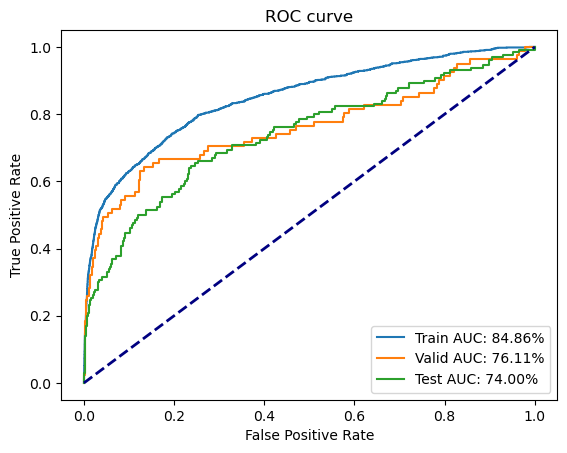

In [246]:
model = GCN(hidden_dim=25, num_layers=3, num_classes=1, norm="batch", res=False, graph_pooling="max")

trainer = GCNTrainer(model, batch_size=BATCH_SIZE, learning_rate=1e-3, epoch=10, l2=1e-5)

# Train the model
learning_curves = trainer.train(
    train_loader, valid_loader, 
    gamma=0.5, imbalance_factor=10,
    draw_curve=True
)

# Evaluate the model
trainer.plot_results(train_loader, valid_loader, test_loader, verbose=True)

### 5.2. GNN Model 2: GCN + Dummy Super Node

This model comes from the paper [Learning Graph-Level Representation for Drug Discovery](https://arxiv.org/pdf/1709.03741v2.pdf). The previous GCN simply sums all feature vectors for all nodes in the graph to obtain the graph feature vector for drug prediction. This new model introduces a dummy super node that is connected with all nodes in the graph by a directed edge as the representation of the graph and modifies the graph operation to help the dummy super node learn graph-level features. It allows handling graph-level classification.

In [16]:
from torch_geometric.nn import global_max_pool

class GCNWithSuperNode(nn.Module):
    def __init__(
            self, 
            hidden_dim:int=100, 
            num_layers:int=3,
            num_classes:int=1, 
            dropout=0.5, 
            norm:str="batch",
            res:bool=False, 
        ):
        super().__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.num_classes = num_classes
        self.res = res 

        self.atom_encoder = AtomEncoder(emb_dim=hidden_dim)
        
        self.convs = nn.ModuleList([GCNConv(hidden_dim) for _ in range(num_layers)])
        self.norms = nn.ModuleList([NormLayer(hidden_dim, norm) for _ in range(num_layers)])
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)

        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x, edge_attr, edge_index, batch):
        # Initial feature encoding
        h = self.atom_encoder(x)
        
        # Initialize super node features and add them to the feature matrix
        num_graphs = batch.max().item() + 1
        super_node_features = torch.zeros(num_graphs, h.size(1), device=h.device)
        h = torch.cat([h, super_node_features], dim=0)
        batch = torch.cat([batch, torch.arange(num_graphs, device=batch.device)])

        # Connect super nodes to all nodes within their respective graphs
        edge_index, edge_attr = self.add_dummy_super_node(edge_index, edge_attr, num_graphs, batch)

        # Apply GCN layers
        for i in range(self.num_layers-1):
            h_res = h
            h = self.convs[i](h, edge_index, edge_attr)
            h = self.norms[i](h)
            h = self.relu(h)
            h = self.dropout(h)
            if self.res: 
                h = h + h_res
        
        h = self.convs[-1](h, edge_index, edge_attr)
        h = self.norms[-1](h)
        h = self.dropout(h)

        # Extract super node features for classification
        super_node_features = h[-num_graphs:]  # Last num_graphs features are the super nodes
        out = self.dropout(super_node_features)
        out = self.classifier(out)

        return out

    def add_dummy_super_node(self, edge_index, edge_attr, num_graphs, batch):
        num_nodes = batch.size(0) - num_graphs
        row = torch.arange(num_nodes, num_nodes + num_graphs)
        col = torch.arange(num_nodes, device=edge_index.device)
        
        # Each super node connects to all nodes in its graph
        row = batch[col]
        new_edge_index = torch.stack([col, row + num_nodes], dim=0)
        new_edge_index = torch.cat([edge_index, new_edge_index, new_edge_index[[1, 0]]], dim=1)

        # Assuming no edge attributes or using a default for simplicity
        if edge_attr is not None:
            default_attr = torch.zeros(new_edge_index.size(1) - edge_index.size(1), edge_attr.size(1), dtype=edge_attr.dtype)
            edge_attr = torch.cat([edge_attr, default_attr], dim=0)

        return new_edge_index, edge_attr

#### First path

In [72]:
model = GCNWithSuperNode(hidden_dim=100, num_classes=1, dropout=0.15)
print(model)

GCNWithSuperNode(
  (atom_encoder): AtomEncoder(
    (atom_embedding_list): ModuleList(
      (0): Embedding(119, 100)
      (1): Embedding(5, 100)
      (2-3): 2 x Embedding(12, 100)
      (4): Embedding(10, 100)
      (5-6): 2 x Embedding(6, 100)
      (7-8): 2 x Embedding(2, 100)
    )
  )
  (conv1): GCNConv()
  (conv2): GCNConv()
  (conv3): GCNConv()
  (relu): ReLU()
  (dropout): Dropout(p=0.15, inplace=False)
  (bn1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (classifier): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=1, bias=True)
  )
)


GCNWithSuperNode - Number of parameters: 62701
Device: cpu
Epoch: 0/10
Epoch: 1/10
Epoch: 2/10
Epoch: 3/10
Epoch: 4/10
Epoch: 5/10
Epoch: 6/10
Epoch: 7/10
Epoch: 8/10
Epoch: 9/10
func: train took: 286.2975 sec


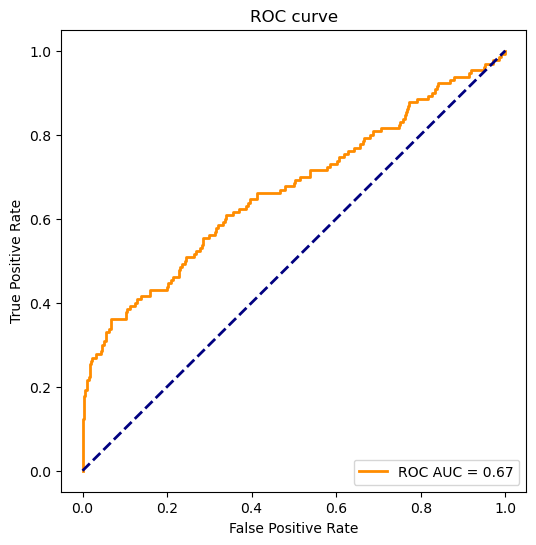

In [73]:
trainer = GCNTrainer(model, batch_size=BATCH_SIZE, learning_rate=1e-3, epoch=10, l2=1e-5)

# Train the model
learning_curves = trainer.train(train_loader, valid_loader, draw_curve=False)

# Evaluate the model
perf = trainer.evaluate(test_loader, draw_curve=True)

In [74]:
model = GCNWithSuperNode(hidden_dim=100, num_classes=1, dropout=0.0)
print(model)

GCNWithSuperNode(
  (atom_encoder): AtomEncoder(
    (atom_embedding_list): ModuleList(
      (0): Embedding(119, 100)
      (1): Embedding(5, 100)
      (2-3): 2 x Embedding(12, 100)
      (4): Embedding(10, 100)
      (5-6): 2 x Embedding(6, 100)
      (7-8): 2 x Embedding(2, 100)
    )
  )
  (conv1): GCNConv()
  (conv2): GCNConv()
  (conv3): GCNConv()
  (relu): ReLU()
  (dropout): Dropout(p=0.0, inplace=False)
  (bn1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (classifier): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=1, bias=True)
  )
)


GCNWithSuperNode - Number of parameters: 62701
Device: cpu
Epoch: 0/10
Epoch: 1/10
Epoch: 2/10
Epoch: 3/10
Epoch: 4/10
Epoch: 5/10
Epoch: 6/10
Epoch: 7/10
Epoch: 8/10
Epoch: 9/10
func: train took: 264.7493 sec


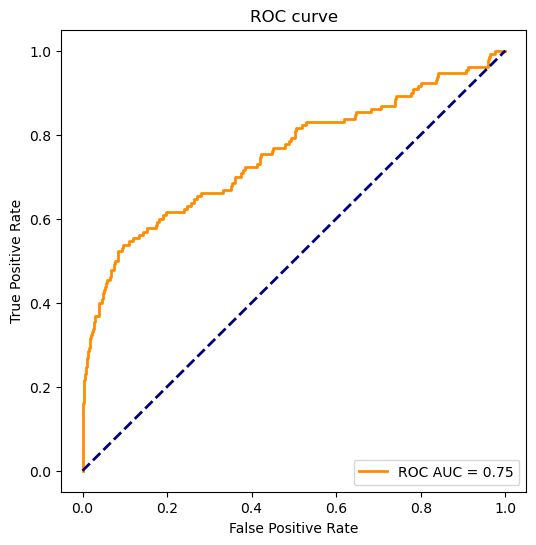

In [75]:
trainer = GCNTrainer(model, batch_size=BATCH_SIZE, learning_rate=1e-3, epoch=10, l2=1e-5)

# Train the model
learning_curves = trainer.train(train_loader, valid_loader, draw_curve=False)

# Evaluate the model
perf = trainer.evaluate(test_loader, draw_curve=True)

GCNWithSuperNode - Number of parameters: 62701
Device: cpu
Epoch: 0/10


Epoch: 1/10
Epoch: 2/10
Epoch: 3/10
Epoch: 4/10
Epoch: 5/10
Epoch: 6/10
Epoch: 7/10
Epoch: 8/10
Epoch: 9/10
func: train took: 249.5919 sec


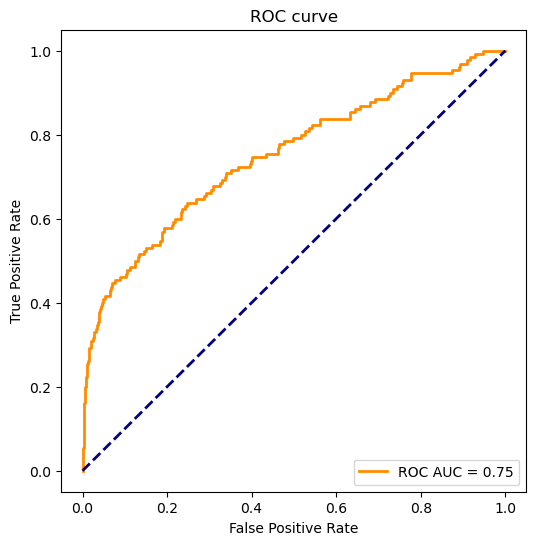

In [76]:
trainer = GCNTrainer(model, batch_size=BATCH_SIZE, learning_rate=1e-3, epoch=10, l2=1e-5)

# Train the model
learning_curves = trainer.train(
    train_loader, valid_loader, 
    gamma=0.2, imbalance_factor=10,                             
    draw_curve=False
)

# Evaluate the model
perf = trainer.evaluate(test_loader, draw_curve=True)

#### Manual exploration of the hyperparameter space

The exploration of the hyperparameters space was the following: 

| Hyperparameter       | Description                                                                                  | Space Explored                      |
|----------------------|----------------------------------------------------------------------------------------------|-------------------------------------|
| `norm`               | The type of normalization layer used within the GCN.                                         | "batch", "layer"                    |
| `hidden_dim`         | The dimensionality of the hidden layers in the GCN.                                          | {10, 25, 100}                         |
| `num_layers`         | The number of GCNConv layers in the model.                                                   | {2, 3, 4, 5, 10}                      |
| `dropout`            | The dropout rate for regularization during training.                                          | {0, 0.15, 0.5}                           |
| `l2` (weight decay)  | The L2 regularization factor.                                                                 | {0, 1e-3, 1e-5}                          |
| `res` (residual)     | Whether to use residual connections between layers.                                           | `True`, `False`                         |
| `gamma`              | Regularization term on the aggregation step (not standard in GCN, might be a custom addition).| {0, 0.5, 1, 2}                           |
| `imbalance_factor`   | Factor to adjust for class imbalance in the dataset.                                          | {0, 0.5, 1, 10}                          |

In [106]:
model = GCNWithSuperNode(hidden_dim=100, num_layers=3, num_classes=1, norm="batch", res=False, dropout=0.15)

trainer = GCNTrainer(model, batch_size=BATCH_SIZE, learning_rate=1e-3, epoch=10, l2=1e-5)

# Train the model
learning_curves = trainer.train(
    train_loader, valid_loader, 
    gamma=0.5, imbalance_factor=10,
    draw_curve=False
)

# Evaluate the model
train_perf = trainer.evaluate(train_loader, draw_curve=False)
test_perf = trainer.evaluate(test_loader, draw_curve=False)
print(f"ROC AUC (Train): {train_perf*100:.2f}%")
print(f"ROC AUC (Test): {test_perf*100:.2f}%")

GCNWithSuperNode - Number of parameters: 62701
Device: cpu
Epoch: 0/10
Epoch: 1/10
Epoch: 2/10
Epoch: 3/10
Epoch: 4/10
Epoch: 5/10
Epoch: 6/10
Epoch: 7/10
Epoch: 8/10
Epoch: 9/10
func: train took: 238.0530 sec
ROC AUC (Train): 84.68%
ROC AUC (Test): 77.70%


GCNWithSuperNode - Number of parameters: 62701
Device: cpu
Epoch: 0/10
Epoch: 1/10
Epoch: 2/10
Epoch: 3/10
Epoch: 4/10
Epoch: 5/10
Epoch: 6/10
Epoch: 7/10
Epoch: 8/10
Epoch: 9/10
func: train took: 238.5794 sec
ROC AUC: (Train): 86.40%
ROC AUC: (Valid): 84.85%
ROC AUC: (Test): 79.16%


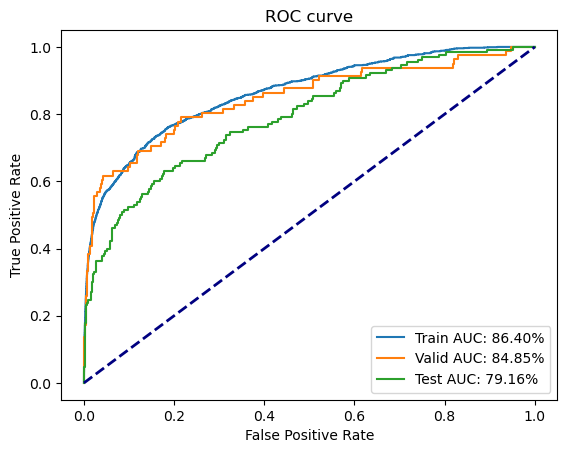

In [250]:
model = GCNWithSuperNode(hidden_dim=100, num_layers=3, num_classes=1, norm="batch", res=False, dropout=0.15)

trainer = GCNTrainer(model, batch_size=BATCH_SIZE, learning_rate=1e-3, epoch=10, l2=1e-5)

# Train the model
learning_curves = trainer.train(
    train_loader, valid_loader, 
    gamma=0.5, imbalance_factor=10,
    draw_curve=False
)

# Evaluate the model
trainer.plot_results(train_loader, valid_loader, test_loader, verbose=True)

GCNWithSuperNode - Number of parameters: 62701
Device: cpu
Epoch: 0/10
Epoch: 1/10
Epoch: 2/10
Epoch: 3/10
Epoch: 4/10
Epoch: 5/10
Epoch: 6/10
Epoch: 7/10
Epoch: 8/10
Epoch: 9/10


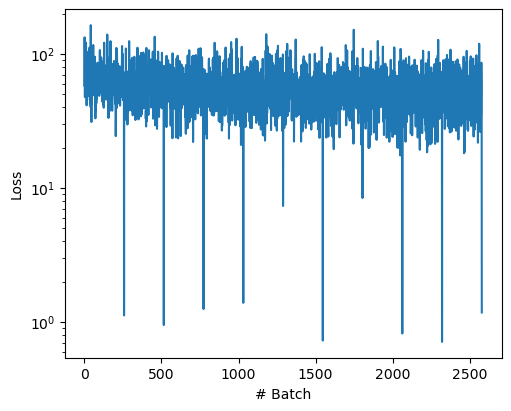

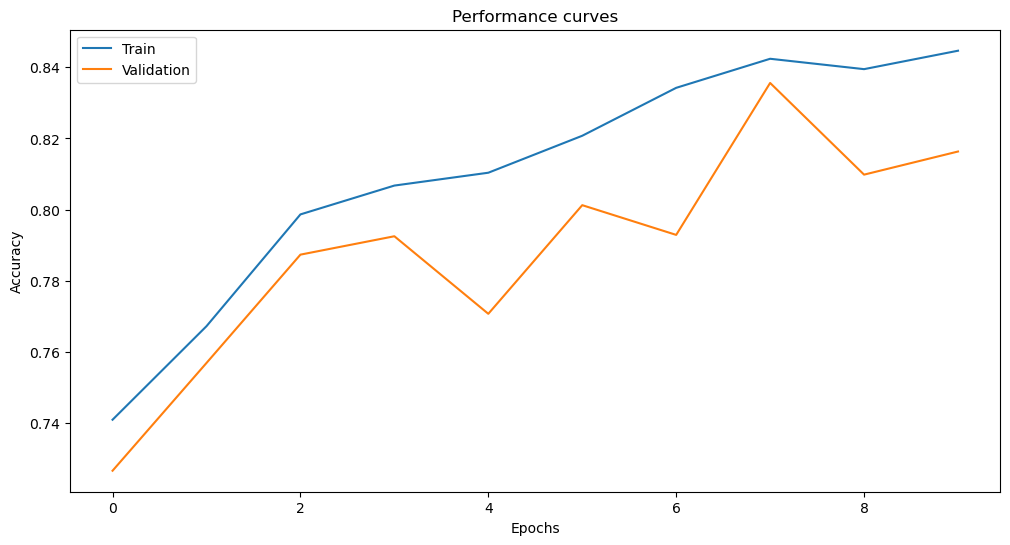

func: train took: 231.0028 sec
ROC AUC: (Train): 84.47%
ROC AUC: (Valid): 81.63%
ROC AUC: (Test): 80.16%


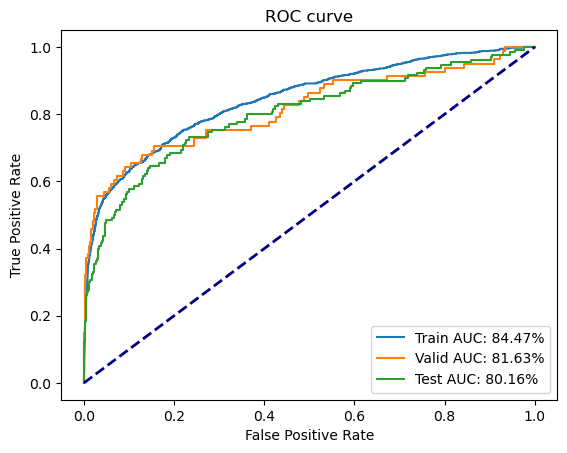

In [17]:
model = GCNWithSuperNode(hidden_dim=100, num_layers=3, num_classes=1, norm="batch", res=False, dropout=0.15)

trainer = GCNTrainer(model, batch_size=BATCH_SIZE, learning_rate=1e-3, epoch=10, l2=1e-5)

# Train the model
learning_curves = trainer.train(
    train_loader, valid_loader, 
    gamma=0.5, imbalance_factor=10,
    draw_curve=True
)

# Evaluate the model
trainer.plot_results(train_loader, valid_loader, test_loader, verbose=True)

**Conclusion:** This GCNConv + Super Node network seems better than the simple GCN network we trained previously. Besides, handling the imbalance dataset with the focal loss (`gamma` and `imbalance_factor` parameters) seems to improve the results.

### 5.3. GNN Model 2: GCN + Dummy Super Node + Max Pooling

In the same paper, they introduce pooling layers after the first two GCNConv layers. We can try to see what result it brings.

In [18]:
from torch_geometric.utils import add_self_loops


class MaxPoolingLocal(MessagePassing):
    def __init__(self):
        super().__init__(aggr='max')  # Use max aggregation.

    def forward(self, x, edge_index):
        # Start by adding self-loops to include each node's own features in the pooling.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        return self.propagate(edge_index, x=x)

class GCNWithSuperNodeAndPooling(nn.Module):
    def __init__(self, 
            hidden_dim:int=100, 
            num_layers:int=3,
            num_classes:int=1, 
            dropout=0.5, 
            norm:str="batch",
            res:bool=False,):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.num_classes = num_classes
        self.res = res 
        
        self.atom_encoder = AtomEncoder(emb_dim=hidden_dim)
        
        self.convs = nn.ModuleList([GCNConv(hidden_dim) for _ in range(num_layers)])
        self.norms = nn.ModuleList([NormLayer(hidden_dim, norm) for _ in range(num_layers)])
        self.pools = nn.ModuleList([MaxPoolingLocal() for _ in range(num_layers-1)])
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)

        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x, edge_attr, edge_index, batch):
        # Initial feature encoding
        h = self.atom_encoder(x)
        
        # Initialize super node features and add them to the feature matrix
        num_graphs = batch.max().item() + 1
        super_node_features = torch.zeros(num_graphs, h.size(1), device=h.device)
        h = torch.cat([h, super_node_features], dim=0)
        batch = torch.cat([batch, torch.arange(num_graphs, device=batch.device)])

        # Connect super nodes to all nodes within their respective graphs
        edge_index, edge_attr = self.add_dummy_super_node(edge_index, edge_attr, num_graphs, batch)

        # Apply GCN layers + Pooling
        for i in range(self.num_layers-1):
            h_res = h
            h = self.convs[i](h, edge_index, edge_attr)
            h = self.norms[i](h)
            h = self.relu(h)
            h = self.pools[i](h, edge_index)
            h = self.dropout(h)
            if self.res: 
                h = h + h_res
        
        h = self.convs[-1](h, edge_index, edge_attr)
        h = self.norms[-1](h)
        h = self.dropout(h)

        # Extract super node features for classification
        super_node_features = h[-num_graphs:]  # Last num_graphs features are the super nodes
        out = self.dropout(super_node_features)
        out = self.classifier(out)

        return out

    def add_dummy_super_node(self, edge_index, edge_attr, num_graphs, batch):
        num_nodes = batch.size(0) - num_graphs
        row = torch.arange(num_nodes, num_nodes + num_graphs)
        col = torch.arange(num_nodes, device=edge_index.device)
        
        # Each super node connects to all nodes in its graph
        row = batch[col]
        new_edge_index = torch.stack([col, row + num_nodes], dim=0)
        new_edge_index = torch.cat([edge_index, new_edge_index, new_edge_index[[1, 0]]], dim=1)

        # Assuming no edge attributes or using a default for simplicity
        if edge_attr is not None:
            default_attr = torch.zeros(new_edge_index.size(1) - edge_index.size(1), edge_attr.size(1), dtype=edge_attr.dtype)
            edge_attr = torch.cat([edge_attr, default_attr], dim=0)

        return new_edge_index, edge_attr

#### First path

In [190]:
model = GCNWithSuperNodeAndPooling(hidden_dim=100, num_classes=1, dropout=0.15)
print(model)

GCNWithSuperNodeAndPooling(
  (atom_encoder): AtomEncoder(
    (atom_embedding_list): ModuleList(
      (0): Embedding(119, 100)
      (1): Embedding(5, 100)
      (2-3): 2 x Embedding(12, 100)
      (4): Embedding(10, 100)
      (5-6): 2 x Embedding(6, 100)
      (7-8): 2 x Embedding(2, 100)
    )
  )
  (conv1): GCNConv()
  (conv2): GCNConv()
  (conv3): GCNConv()
  (relu): ReLU()
  (dropout): Dropout(p=0.15, inplace=False)
  (bn1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPoolingLocal()
  (pool2): MaxPoolingLocal()
  (classifier): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=1, bias=True)
  )
)


GCNWithSuperNodeAndPooling - Number of parameters: 62701
Device: cpu
Epoch: 0/10
Epoch: 1/10
Epoch: 2/10
Epoch: 3/10
Epoch: 4/10
Epoch: 5/10
Epoch: 6/10
Epoch: 7/10
Epoch: 8/10
Epoch: 9/10
func: train took: 286.8807 sec


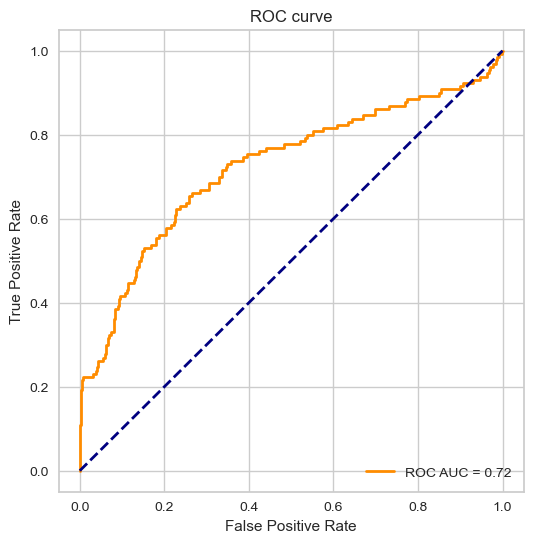

In [191]:
trainer = GCNTrainer(model, batch_size=BATCH_SIZE, learning_rate=1e-3, epoch=10, l2=1e-5)

# Train the model
learning_curves = trainer.train(train_loader, valid_loader, draw_curve=False)

# Evaluate the model
perf = trainer.evaluate(test_loader, draw_curve=True)

In [192]:
model = GCNWithSuperNodeAndPooling(hidden_dim=100, num_classes=1)
print(model)

GCNWithSuperNodeAndPooling(
  (atom_encoder): AtomEncoder(
    (atom_embedding_list): ModuleList(
      (0): Embedding(119, 100)
      (1): Embedding(5, 100)
      (2-3): 2 x Embedding(12, 100)
      (4): Embedding(10, 100)
      (5-6): 2 x Embedding(6, 100)
      (7-8): 2 x Embedding(2, 100)
    )
  )
  (conv1): GCNConv()
  (conv2): GCNConv()
  (conv3): GCNConv()
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (bn1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPoolingLocal()
  (pool2): MaxPoolingLocal()
  (classifier): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=1, bias=True)
  )
)


GCNWithSuperNodeAndPooling - Number of parameters: 62701
Device: cpu
Epoch: 0/10
Epoch: 1/10
Epoch: 2/10
Epoch: 3/10
Epoch: 4/10
Epoch: 5/10
Epoch: 6/10
Epoch: 7/10
Epoch: 8/10
Epoch: 9/10
func: train took: 284.1217 sec


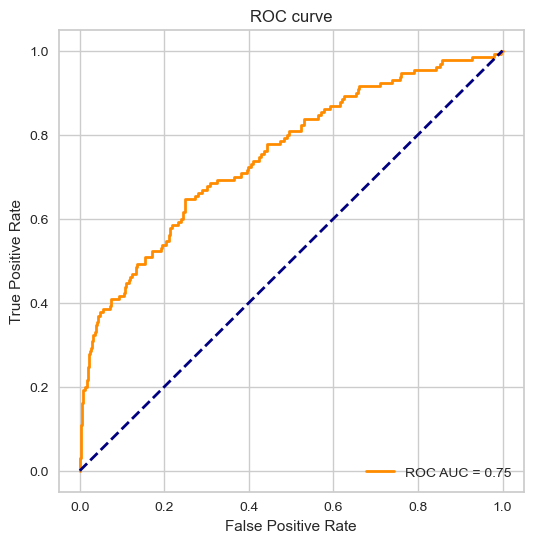

In [193]:
trainer = GCNTrainer(model, batch_size=BATCH_SIZE, learning_rate=1e-3, epoch=10, l2=1e-5)

# Train the model
learning_curves = trainer.train(
    train_loader, valid_loader, 
    gamma=0.2, imbalance_factor=10,                             
    draw_curve=False
)

# Evaluate the model
perf = trainer.evaluate(test_loader, draw_curve=True)

#### Manual exploration of the hyperparameter space

The exploration of the hyperparameters space was the following: 

| Hyperparameter       | Description                                                                                  | Space Explored                      |
|----------------------|----------------------------------------------------------------------------------------------|-------------------------------------|
| `norm`               | The type of normalization layer used within the GCN.                                         | "batch", "layer"                    |
| `hidden_dim`         | The dimensionality of the hidden layers in the GCN.                                          | {10, 25, 100}                         |
| `num_layers`         | The number of GCNConv layers in the model.                                                   | {2, 3, 4, 5, 10}                      |
| `dropout`            | The dropout rate for regularization during training.                                          | {0, 0.15, 0.5}                           |
| `l2` (weight decay)  | The L2 regularization factor.                                                                 | {0, 1e-3, 1e-5}                          |
| `res` (residual)     | Whether to use residual connections between layers.                                           | `True`, `False`                         |
| `gamma`              | Regularization term on the aggregation step (not standard in GCN, might be a custom addition).| {0, 0.5, 1, 2}                           |
| `imbalance_factor`   | Factor to adjust for class imbalance in the dataset.                                          | {0, 0.5, 1, 10}                          |

GCNWithSuperNodeAndPooling - Number of parameters: 62701
Device: cpu
Epoch: 0/10
Epoch: 1/10
Epoch: 2/10
Epoch: 3/10
Epoch: 4/10
Epoch: 5/10
Epoch: 6/10
Epoch: 7/10
Epoch: 8/10
Epoch: 9/10


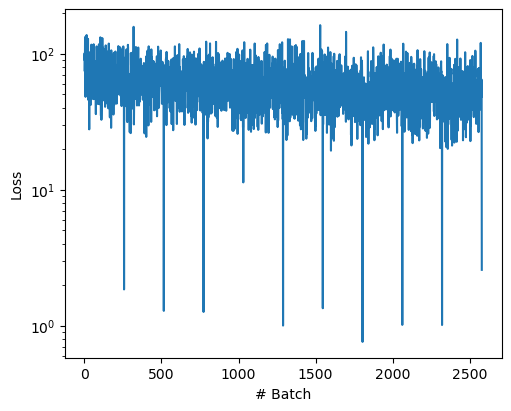

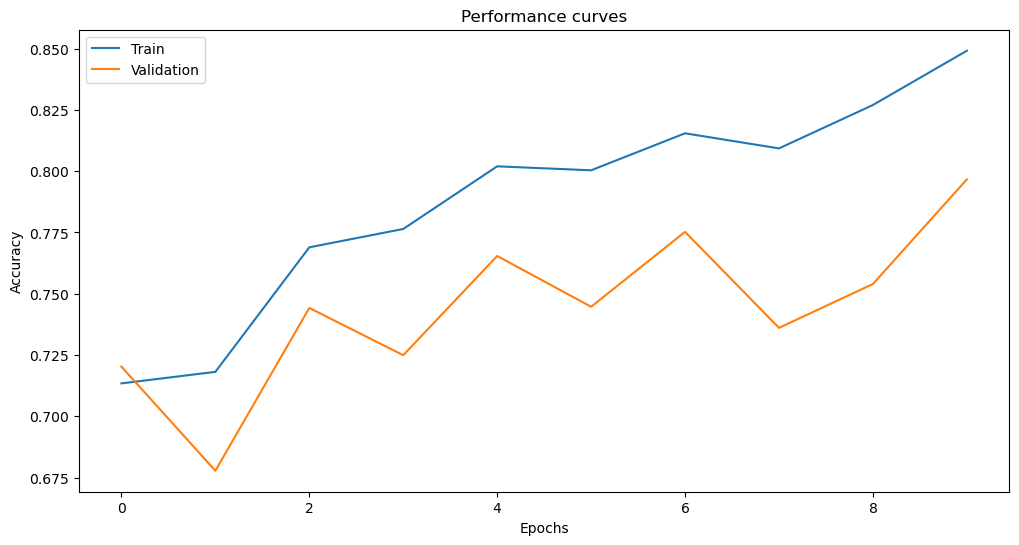

func: train took: 375.5670 sec
ROC AUC: (Train): 84.91%
ROC AUC: (Valid): 79.66%
ROC AUC: (Test): 74.58%


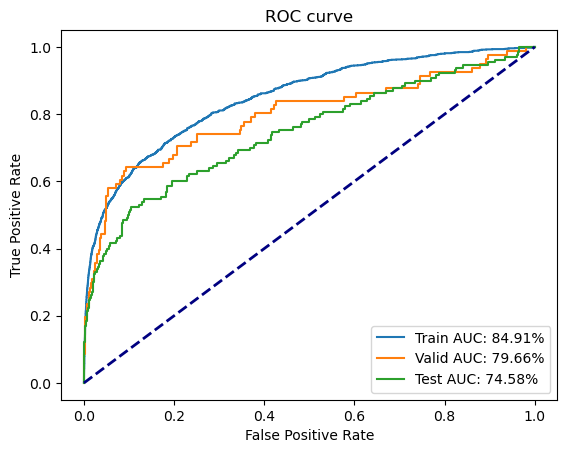

In [19]:
model = GCNWithSuperNodeAndPooling(hidden_dim=100, num_layers=3, num_classes=1, norm="batch", res=False, dropout=0.15)

trainer = GCNTrainer(model, batch_size=BATCH_SIZE, learning_rate=1e-3, epoch=10, l2=1e-5)

# Train the model
learning_curves = trainer.train(
    train_loader, valid_loader, 
    gamma=0.5, imbalance_factor=10,
    draw_curve=True
)

# Evaluate the model
trainer.plot_results(train_loader, valid_loader, test_loader, verbose=True)

**NB:** The pooling layers from the paper do not seem to improve the GCN+Super Node model that we already trained.

## 6. Conclusion

To conclude, we performed extensive training on different models on different forms of the HIV dataset. The following table summarizes all our results: 

| Features Type              | Model                            | AUC Training | AUC Validation | AUC Test   |
|----------------------------|----------------------------------|--------------|----------------|------------|
| General Descriptors        | XGBoost                          | 97.94%       | 80.15%         | 76.34%     |
| Molecular Fingerprints     | XGBoost                          | 98.85%       | 82.66%         | 75.66%     |
| **Molecular Fingerprints** | **Random Forest**                | **99.24%**   | **80.63%**     | **82.38%** |
| Molecular Fingerprints     | MLPPCA                           | 98.85%       | 82.55%         | 78.23%     |
| Graph                      | GCN                              | 85.22%       | 76.58%         | 74.81%     |
| **Graph**                  | **GCN + Super Dummy Node**       | **84.47%**   | **81.63%**     | **80.16%** |
| Graph                      | GCN + Super Dummy Node + Pooling | 84.91%       | 79.66%%        | 74.58%     |

In terms of performance, the **Random Forest classifier** on the Fingerprints seems to give the best results on the test set. Nonetheless, it seems to overfit a bit the training set. In this matter, the **GCN + Super Dummy Node** seems to give the best trade-off between overfitting and underfitting.

### Future work

For future work, more complex neural networks could be tried. Some work on graph done by [X. Zhang et al.](https://github.com/zhangxwww/HyperFusion/blob/master/Multi_Model_Ensemble_on_Hypergraph.pdf), [X. Wang et al.](https://github.com/LARS-research/PAS-OGB/blob/main/report/PAS_OGB.pdf) and [Y. Wang et al.](https://github.com/LARS-research/PAS-OGB/blob/main/report/PAS_OGB.pdf) seem to improve the Test AUC to >84%. Our models are not far from these results.